# 🔬 RetinaLiteNet - COMPLETE Training & Validation Pipeline

**Paper**: RetinaLiteNet - A Lightweight Transformer-based CNN for Retinal Feature Segmentation (CVPR 2024)  
**Datasets**: 
- **DRIVE** - Blood Vessel (BV) Segmentation
- **IOSTAR** - Optic Disc (OD) Segmentation  

**Features**:
✅ Latest TensorFlow 2.17.0 (T4 GPU optimized)
✅ Complete training pipeline with data augmentation
✅ Multi-task learning (BV + OD)
✅ Model checkpointing & early stopping
✅ Comprehensive evaluation metrics
✅ Download pre-trained weights from GitHub

---

## 📊 Expected Results (from paper)

### DRIVE Dataset (Blood Vessels):
| Metric | Paper | Target Range |
|--------|-------|--------------||
| F1-Score | 80.6% | 78-82% |
| Specificity | **~98%** | **97-99%** |

### IOSTAR Dataset (Optic Disc):
| Metric | Paper | Target Range |
|--------|-------|--------------||
| F1-Score | 93.3% | 91-95% |
| Specificity | **~98%** | **97-99%** |

---

## 1. Install Latest Dependencies (T4 GPU Optimized)

In [2]:
# Latest TensorFlow with CUDA 12.x support for T4 GPU
!pip install -q tensorflow==2.17.0

# GPU-optimized scientific packages
!pip install -q scikit-image==0.24.0
!pip install -q opencv-python-headless==4.10.0.84
!pip install -q scikit-learn==1.5.2
!pip install -q matplotlib==3.9.2
!pip install -q seaborn==0.13.2
!pip install -q imageio==2.36.0
!pip install -q pillow==10.4.0
!pip install -q albumentations==1.4.18  # Advanced data augmentation

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.4 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.8 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompat

### Environment Setup and GPU Configuration

- Import essential libraries for data processing, deep learning, and visualization (TensorFlow, Keras, OpenCV, PIL, scikit-learn, Albumentations, matplotlib, seaborn).  
- Set reproducibility seeds for NumPy and TensorFlow.  
- Display TensorFlow version and available GPUs.  
- Enable **mixed precision (FP16)** for faster training on compatible GPUs.  
- Check CUDA availability and print GPU name.  
- Suppress warnings for cleaner output.

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import register_keras_serializable

import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

sns.set_style("whitegrid")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

# Enable mixed precision for T4 GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✅ Mixed precision enabled (FP16) for faster training!")

# Check CUDA version
print(f"\n📊 CUDA Available: {tf.test.is_built_with_cuda()}")
if tf.config.list_physical_devices('GPU'):
    print(f"📊 GPU Name: {tf.config.list_physical_devices('GPU')[0].name}")

✅ TensorFlow: 2.18.0
✅ GPUs available: 2
✅ Mixed precision enabled (FP16) for faster training!

📊 CUDA Available: True
📊 GPU Name: /physical_device:GPU:0


### Model and Training Configuration

- **Model Weights:**  
  - `PRETRAINED_WEIGHTS_URL`: URL to download pre-trained weights.  
  - `WEIGHTS_PATH`: Local path to save pre-trained weights.  
  - `CHECKPOINT_PATH`: Path to save the best model during training.  

- **Training Settings:**  
  - Image dimensions: 512 × 512 with 3 channels.  
  - Batch size: 8 (optimized for T4 GPU).  
  - Epochs: 300.  
  - Learning rate: 1e-4.  
  - Validation split: 20%.  

- **Evaluation Settings:**  
  - Threshold for predictions: 0.5.  
  - Option to use FOV (field-of-view) mask: enabled.  

- **Training Mode:**  
  - `TRAIN_FROM_SCRATCH`: True to train from scratch.  
  - `USE_PRETRAINED`: True to download and use pre-trained weights.  

- Prints configuration summary including mode, batch size, image size, and mixed precision status.

In [ ]:
# Model weights
PRETRAINED_WEIGHTS_URL = 'https://github.com/Mehwish4593/RetinaLiteNet/raw/main/MTLTransfuseep300bs16head4.h5'
WEIGHTS_PATH = '/kaggle/working/retinalitenet_weights.h5'
CHECKPOINT_PATH = '/kaggle/working/checkpoints/best_model.h5'

# Training settings
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
BATCH_SIZE = 8  # Optimized for T4 GPU (16GB)
EPOCHS = 300
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2

# Evaluation settings
THRESHOLD = 0.5
USE_FOV_MASK = True

# Training mode
TRAIN_FROM_SCRATCH = True  # Set to True to train from scratch
USE_PRETRAINED = True       # Set to True to download pre-trained weights

print("✅ Configuration loaded")
print(f"   Mode: {'Training from scratch' if TRAIN_FROM_SCRATCH else 'Using pre-trained weights'}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"   Mixed precision: Enabled (FP16)")

✅ Configuration loaded
   Mode: Training from scratch
   Batch size: 8
   Image size: 512x512
   Mixed precision: Enabled (FP16)


### Pre-trained Weights Download

- Checks if pre-trained weights should be used (`USE_PRETRAINED`) and training is **not** from scratch.  
- Downloads the weights from the specified GitHub URL using `wget` and saves them locally.  
- Verifies the download: prints confirmation and file size if successful.  
- If download fails, switches to training from scratch (`TRAIN_FROM_SCRATCH = True`).  
- If pre-trained weights are not used, skips the download and proceeds with training from scratch.

In [5]:
if USE_PRETRAINED and not TRAIN_FROM_SCRATCH:
    print("📥 Downloading pre-trained weights from GitHub...")
    !wget -O {WEIGHTS_PATH} {PRETRAINED_WEIGHTS_URL}
    
    if os.path.exists(WEIGHTS_PATH):
        print(f"✅ Downloaded weights: {WEIGHTS_PATH}")
        print(f"   Size: {os.path.getsize(WEIGHTS_PATH) / 1e6:.2f} MB")
    else:
        print("❌ Download failed! Will train from scratch.")
        TRAIN_FROM_SCRATCH = True
else:
    print("⚠️ Skipping pre-trained weights download (will train from scratch)")

⚠️ Skipping pre-trained weights download (will train from scratch)


### Custom Keras Layers for RetinaLiteNet

- **TileLayer:**  
  - Tiles the input tensor along height and width to a specified `target_height` and `target_width`.  
  - Preserves the batch size and number of channels.  
  - Includes `get_config` for serialization.  

- **ChannelMeanLayer:**  
  - Computes the mean across the channel dimension.  
  - Output shape has a single channel.  

- **ChannelMaxLayer:**  
  - Computes the maximum across the channel dimension.  
  - Output shape has a single channel.  

- All layers are registered with `@register_keras_serializable` to ensure proper saving/loading in Keras models.  
- Prints a confirmation once the custom layers are defined.

In [6]:
@register_keras_serializable(package="RetinaLiteNet")
class TileLayer(layers.Layer):
    def __init__(self, target_height=64, target_width=64, **kwargs):
        super(TileLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width
    
    def call(self, inputs):
        return tf.tile(inputs, [1, self.target_height, self.target_width, 1])
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.target_height, self.target_width, input_shape[-1])
    
    def get_config(self):
        config = super(TileLayer, self).get_config()
        config.update({
            'target_height': self.target_height,
            'target_width': self.target_width
        })
        return config

@register_keras_serializable(package="RetinaLiteNet")
class ChannelMeanLayer(layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=3, keepdims=True)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)

@register_keras_serializable(package="RetinaLiteNet")
class ChannelMaxLayer(layers.Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=3, keepdims=True)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)

print("✅ Custom layers defined")

✅ Custom layers defined


### CBAM (Convolutional Block Attention Module) Definition

- **Channel Attention (`channel_attention`)**  
  - Uses global average and max pooling to compute attention weights per channel.  
  - Passes pooled features through shared dense layers and a sigmoid activation.  
  - Multiplies the input feature map by the resulting channel attention map.  

- **Spatial Attention (`spatial_attention`)**  
  - Computes channel-wise mean and max, concatenates them, and applies a 7×7 convolution with sigmoid activation.  
  - Multiplies the input feature map by the spatial attention map.  

- **CBAM Block (`cbam_block`)**  
  - Combines channel and spatial attention sequentially.  
  - Can be applied to any feature map to enhance important regions and suppress irrelevant ones.  

- Prints a confirmation once the CBAM modules are defined.

In [7]:
def channel_attention(input_feature, ratio=8, name_prefix=''):
    channel = input_feature.shape[-1]
    
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', name=f'{name_prefix}ca_dense1')
    shared_layer_two = layers.Dense(channel, name=f'{name_prefix}ca_dense2')
    
    avg_pool = layers.GlobalAveragePooling2D(name=f'{name_prefix}ca_avgpool')(input_feature)
    avg_pool = layers.Reshape((1, 1, channel), name=f'{name_prefix}ca_reshape1')(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D(name=f'{name_prefix}ca_maxpool')(input_feature)
    max_pool = layers.Reshape((1, 1, channel), name=f'{name_prefix}ca_reshape2')(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add(name=f'{name_prefix}ca_add')([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid', name=f'{name_prefix}ca_sigmoid')(cbam_feature)
    
    return layers.Multiply(name=f'{name_prefix}ca_multiply')([input_feature, cbam_feature])

def spatial_attention(input_feature, name_prefix=''):
    avg_pool = ChannelMeanLayer(name=f'{name_prefix}sa_mean')(input_feature)
    max_pool = ChannelMaxLayer(name=f'{name_prefix}sa_max')(input_feature)
    concat = layers.Concatenate(axis=3, name=f'{name_prefix}sa_concat')([avg_pool, max_pool])
    
    cbam_feature = layers.Conv2D(1, 7, padding='same', activation='sigmoid', 
                                  use_bias=False, name=f'{name_prefix}sa_conv')(concat)
    
    return layers.Multiply(name=f'{name_prefix}sa_multiply')([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8, name_prefix='cbam'):
    cbam_feature = channel_attention(cbam_feature, ratio, name_prefix=name_prefix)
    cbam_feature = spatial_attention(cbam_feature, name_prefix=name_prefix)
    return cbam_feature

print("✅ CBAM modules defined")

✅ CBAM modules defined


### Custom Metrics and Loss Functions

- **Threshold Binarization (`threshold_binarize`)**  
  - Converts predicted probabilities to binary values based on a specified threshold (default 0.5).  

- **Dice Coefficient (`dice_coef`)**  
  - Measures overlap between predicted and true masks.  
  - Values range from 0 (no overlap) to 1 (perfect overlap).  

- **Intersection over Union (`iou`)**  
  - Evaluates the ratio of intersection to union between predicted and true masks.  

- **Sensitivity (`sensitivity`)**  
  - Fraction of true positives correctly predicted.  

- **Specificity (`specificity`)**  
  - Fraction of true negatives correctly predicted.  

- **Dice Loss (`DiceLoss`)**  
  - Converts Dice coefficient into a loss function for training.  

- **Combined Loss (`combo_loss`)**  
  - Sum of Dice Loss and IoU Loss to improve segmentation performance.  

- Prints a confirmation once all custom metrics and loss functions are defined.

In [8]:
from tensorflow.keras import backend as K

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def dice_coef(y_true, y_pred, threshold=0.5, smooth=1e-6):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, threshold=0.5, smooth=1e-6):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def sensitivity(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def specificity(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    return 1 - tf.divide(nominator, denominator)

def combo_loss(y_true, y_pred):
    """Combined Dice Loss + IoU Loss (from paper)"""
    return DiceLoss(y_true, y_pred) + (1 - iou(y_true, y_pred, threshold=0.5))

print("✅ Custom metrics and loss functions defined")

✅ Custom metrics and loss functions defined


### RetinaLiteNet Multi-Task Model

- **Purpose:** Multi-Task Learning for retinal image segmentation  
  - **Output 1:** Blood Vessel segmentation (DRIVE dataset)  
  - **Output 2:** Optic Disc segmentation (IOSTAR dataset)  
- **Total Parameters:** ~66K (lightweight for fast training)

**Architecture Overview:**
1. **Encoder:**  
   - 3 convolutional blocks with Conv2D → MaxPooling → BatchNormalization.  
2. **Transformer Block:**  
   - Reshape feature map, apply Multi-Head Attention, Global Average Pooling, and tile back to spatial dimensions.  
3. **Feature Fusion:**  
   - Apply CBAM attention block and concatenate with encoder features.  
4. **Decoder:**  
   - 3 transposed convolutional layers with CBAM attention and skip connections from encoder.  
5. **Multi-Task Outputs:**  
   - `final_output1` → Blood Vessel mask (sigmoid)  
   - `final_output2` → Optic Disc mask (sigmoid)

- Prints the number of parameters and confirms the output tasks once the model is created.


In [10]:
def create_retinalitenet_multitask(input_shape=(512, 512, 3)):
    """
    RetinaLiteNet for Multi-Task Learning:
    - Blood Vessel segmentation (DRIVE)
    - Optic Disc segmentation (IOSTAR)
    
    Total Parameters: ~66K
    """
    inputs = layers.Input(shape=input_shape, name='input')
    
    # Encoder
    conv1 = layers.Conv2D(8, 3, padding='same', activation='relu', name='enc_conv1')(inputs)
    conv1 = layers.MaxPooling2D(2, name='enc_pool1')(conv1)
    conv1 = layers.BatchNormalization(name='enc_bn1')(conv1)
    
    conv2 = layers.Conv2D(16, 3, padding='same', activation='relu', name='enc_conv2')(conv1)
    conv2 = layers.MaxPooling2D(2, name='enc_pool2')(conv2)
    conv2 = layers.BatchNormalization(name='enc_bn2')(conv2)
    
    conv3 = layers.Conv2D(32, 3, padding='same', activation='relu', name='enc_conv3')(conv2)
    conv3 = layers.MaxPooling2D(2, name='enc_pool3')(conv3)
    conv3 = layers.BatchNormalization(name='enc_bn3')(conv3)
    
    # Transformer Block
    trans = layers.Reshape((-1, conv3.shape[3]), name='trans_reshape1')(conv3)
    trans = layers.MultiHeadAttention(num_heads=4, key_dim=32, name='trans_mha')(trans, trans)
    trans = layers.GlobalAveragePooling1D(name='trans_gap')(trans)
    trans = layers.Reshape((1, 1, trans.shape[1]), name='trans_reshape2')(trans)
    trans = TileLayer(conv3.shape[1], conv3.shape[2], name='trans_tile')(trans)
    
    # Feature Fusion
    att1 = cbam_block(trans, name_prefix='fusion_cbam')
    fused = layers.Concatenate(name='fusion_concat')([conv3, att1])
    
    # Decoder
    dec1 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu', name='dec_transpose1')(fused)
    att2 = cbam_block(dec1, name_prefix='dec1_cbam')
    dec1 = layers.Concatenate(name='dec_concat1')([att2, conv2])
    dec1 = layers.Conv2D(32, 3, padding='same', activation='relu', name='dec_conv1')(dec1)
    
    dec2 = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu', name='dec_transpose2')(dec1)
    att3 = cbam_block(dec2, name_prefix='dec2_cbam')
    dec2 = layers.Concatenate(name='dec_concat2')([att3, conv1])
    dec2 = layers.Conv2D(16, 3, padding='same', activation='relu', name='dec_conv2')(dec2)
    
    dec3 = layers.Conv2DTranspose(8, 3, strides=2, padding='same', activation='relu', name='dec_transpose3')(dec2)
    dec3 = layers.Conv2D(8, 3, padding='same', activation='relu', name='dec_conv3')(dec3)
    
    # Multi-Task Outputs (must match paper's naming: final_output1, final_output2)
    output_bv = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32', name='final_output1')(dec3)
    output_od = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32', name='final_output2')(dec3)
    
    model = models.Model(inputs=inputs, outputs=[output_bv, output_od], name='RetinaLiteNet_MultiTask')
    return model

# Create model
model = create_retinalitenet_multitask((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
print(f"✅ Model created: {model.count_params():,} parameters")
print(f"   Output 1 (final_output1): Blood Vessels (BV)")
print(f"   Output 2 (final_output2): Optic Disc (OD)")

✅ Model created: 66,194 parameters
   Output 1 (final_output1): Blood Vessels (BV)
   Output 2 (final_output2): Optic Disc (OD)


### Compile RetinaLiteNet Multi-Task Model

- **Optimizer:** Adam with learning rate specified by `LEARNING_RATE`.  
- **Loss Functions:**  
  - `final_output1` (Blood Vessel) → Combo Loss (Dice + IoU)  
  - `final_output2` (Optic Disc) → Combo Loss (Dice + IoU)  
- **Metrics:** Dice coefficient, IoU, Sensitivity, and Specificity for both outputs.  
- Prints confirmation of successful compilation along with optimizer, learning rate, loss, and metrics.  
- Displays the full model summary showing layer details and output shapes.


In [11]:
# Compile with multi-task losses and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss={
        'final_output1': combo_loss,  # BV loss
        'final_output2': combo_loss   # OD loss
    },
    metrics={
        'final_output1': [dice_coef, iou, sensitivity, specificity],
        'final_output2': [dice_coef, iou, sensitivity, specificity]
    }
)

print("✅ Model compiled successfully")
print("   Optimizer: Adam")
print(f"   Learning rate: {LEARNING_RATE}")
print("   Loss: Dice + IoU (Combo Loss)")
print("   Metrics: Dice, IoU, Sensitivity, Specificity")

# Display model summary
model.summary()

✅ Model compiled successfully
   Optimizer: Adam
   Learning rate: 0.0001
   Loss: Dice + IoU (Combo Loss)
   Metrics: Dice, IoU, Sensitivity, Specificity


Model: "RetinaLiteNet_MultiTask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 512, 512,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv1 (Conv2D)  │ (None, 512, 512,  │        224 │ cast_3[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_pool1           │ (None, 256, 256,  │          0 │ enc_conv1[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn1             │ (None, 256, 256,  │         32 │ enc_pool1[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv2 (Conv2D)  │ (None, 256, 256,  │      1,168 │ enc_bn1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_pool2           │ (None, 128, 128,  │          0 │ enc_conv2[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn2             │ (None, 128, 128,  │         64 │ enc_pool2[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv3 (Conv2D)  │ (None, 128, 128,  │      4,640 │ enc_bn2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_pool3           │ (None, 64, 64,    │          0 │ enc_conv3[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn3             │ (None, 64, 64,    │        128 │ enc_pool3[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_reshape1      │ (None, 4096, 32)  │          0 │ enc_bn3[0][0]     │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_mha           │ (None, 4096, 32)  │     16,800 │ trans_reshape1[0… │
│ (MultiHeadAttentio… │                   │            │ trans_reshape1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_gap           │ (None, 32)        │          0 │ trans_mha[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_reshape2      │ (None, 1, 1, 32)  │          0 │ trans_gap[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_tile          │ (None, 64, 64,    │          0 │ trans_reshape2[0… │
│ (TileLayer)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_cbamca_avgp… │ (None, 32)        │          0 │ trans_tile[0][0]

 Total params: 66,194 (258.57 KB)

 Trainable params: 66,082 (258.13 KB)

 Non-trainable params: 112 (448.00 B)

### Load Augmented Dataset from Folder

- Defines a function to load pre-augmented images and masks from `./dataset/drive_iostar_augmented`.  
- Supports both **train** and **validation** splits.  
- Loads:
  - Input images (`X`) normalized to `[0, 1]`  
  - Blood Vessel masks (`y_bv`)  
  - Optic Disc masks (`y_od`)  
- Preserves the original folder structure: `images/`, `bv_masks/`, `od_masks/`.  
- Prints confirmation of the number of images loaded for each split.  
- Assigns data to the original training variables: `X_train_split`, `X_val_split`, `y_train_bv_split`, `y_val_bv_split`, `y_train_od_split`, `y_val_od_split` for direct use in training.

In [ ]:
# ===================== LOAD AUGMENTED DATA ===================== #
def load_dataset_from_folder(base_path="./dataset/drive_iostar_augmented"):
    splits = ["train", "val"]
    data = {}
    
    for split in splits:
        images_path = os.path.join(base_path, split, "images")
        bv_masks_path = os.path.join(base_path, split, "bv_masks")
        od_masks_path = os.path.join(base_path, split, "od_masks")
        
        image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
        bv_files = sorted([f for f in os.listdir(bv_masks_path) if f.endswith('.png')])
        od_files = sorted([f for f in os.listdir(od_masks_path) if f.endswith('.png')])
        
        X = np.array([np.array(Image.open(os.path.join(images_path, f))).astype(np.float32)/255.0 for f in image_files])
        y_bv = np.array([np.expand_dims(np.array(Image.open(os.path.join(bv_masks_path, f))).astype(np.float32)/255.0, -1) for f in bv_files])
        y_od = np.array([np.expand_dims(np.array(Image.open(os.path.join(od_masks_path, f))).astype(np.float32)/255.0, -1) for f in od_files])
        
        data[split] = (X, y_bv, y_od)
        print(f"✅ Loaded {split}: {len(X)} images")
    
    return data

# ===================== LOAD DATA ===================== #
dataset = load_dataset_from_folder()

X_train_split, y_train_bv_split, y_train_od_split = dataset["train"]
X_val_split, y_val_bv_split, y_val_od_split = dataset["val"]

print(f"\n📌 Dataset ready: {len(X_train_split)} train | {len(X_val_split)} validation")


LOADING DRIVE TRAINING DATA (Blood Vessels)
Found 20 DRIVE training images
✅ DRIVE loaded: 20 images → 400 samples so far

LOADING IOSTAR TRAINING DATA (Optic Disc)
Found 18 IOSTAR training images
Base augmentations per image: 21
Images with +1 extra augmentation: 4
✅ IOSTAR loaded exactly 400 samples

TRAINING DATA SUMMARY
✅ Total training samples: 800
   Images shape: (800, 512, 512, 3)
   BV masks shape: (800, 512, 512, 1)
   OD masks shape: (800, 512, 512, 1)
   Memory usage: 4.19 GB

✅ Train/Val split:
   Training: 640 samples
   Validation: 160 samples


### Training Callbacks Configuration

- Only set up if `TRAIN_FROM_SCRATCH = True`.  
- **Callbacks Defined:**
  - **ModelCheckpoint:** Saves the best model weights based on validation loss.  
  - **EarlyStopping:** Stops training if validation loss does not improve for 30 epochs and restores the best weights.  
  - **ReduceLROnPlateau:** Reduces learning rate by 0.5 if validation loss plateaus for 10 epochs, with a minimum LR of 1e-7.  
  - **TensorBoard:** Logs training metrics and graphs to `/kaggle/working/logs` for visualization.  
  - **CSVLogger:** Records training progress to `training_log.csv`.  

- Creates checkpoint directory if it does not exist.  
- Prints confirmation and details of all configured callbacks.

In [14]:
from tensorflow.keras import callbacks
import os

if TRAIN_FROM_SCRATCH:
    # Create checkpoint directory
    os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)
    
    # ✅ Option 2: Save full model (architecture + weights)
    checkpoint = callbacks.ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,  # save full model
        verbose=1
    )
    
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
    
    tensorboard = callbacks.TensorBoard(
        log_dir='/kaggle/working/logs',
        histogram_freq=1,
        write_graph=True
    )
    
    csv_logger = callbacks.CSVLogger(
        '/kaggle/working/training_log.csv',
        append=True
    )
    
    callback_list = [checkpoint, early_stop, reduce_lr, tensorboard, csv_logger]
    
    print("✅ Training callbacks configured:")
    print("   - ModelCheckpoint (save full model)")
    print("   - EarlyStopping (patience=30)")
    print("   - ReduceLROnPlateau (patience=10)")
    print("   - TensorBoard (log directory: /kaggle/working/logs)")
    print("   - CSVLogger (training_log.csv)")


✅ Training callbacks configured:
   - ModelCheckpoint (save full model)
   - EarlyStopping (patience=30)
   - ReduceLROnPlateau (patience=10)
   - TensorBoard (log directory: /kaggle/working/logs)
   - CSVLogger (training_log.csv)


### Model Training Execution

- Training only runs if `TRAIN_FROM_SCRATCH = True`.  
- **Training Details Printed:**
  - Number of training and validation samples.  
  - Batch size, epochs, and steps per epoch.  

- **Model Fitting:**
  - Inputs: `X_train_split`  
  - Outputs: `[y_train_bv_split, y_train_od_split]`  
  - Validation data: `X_val_split` and corresponding masks.  
  - Uses the previously defined `callback_list` for checkpointing, early stopping, learning rate adjustment, TensorBoard logging, and CSV logging.  

- **Post-Training:**
  - Confirms completion of training.  
  - Saves best model weights to `CHECKPOINT_PATH`.  
  - Saves final model weights to `final_model_weights.h5`.  

- **If Not Training from Scratch:**
  - Skips training.  
  - Attempts to load pre-trained weights from `WEIGHTS_PATH` and prints confirmation or error if not found.

In [15]:
if TRAIN_FROM_SCRATCH:
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)
    print(f"Training samples: {len(X_train_split)}")
    print(f"Validation samples: {len(X_val_split)}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")
    print(f"Steps per epoch: {len(X_train_split) // BATCH_SIZE}")
    print("="*70 + "\n")
    
    history = model.fit(
        X_train_split,
        [y_train_bv_split, y_train_od_split],
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val_split, [y_val_bv_split, y_val_od_split]),
        callbacks=callback_list,
        verbose=1
    )
    
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"✅ Best weights saved to: {CHECKPOINT_PATH}")
    print(f"✅ Training log saved to: /kaggle/working/training_log.csv")
    
    # Save final weights
    model.save_weights('/kaggle/working/final_model_weights.h5')
    print(f"✅ Final weights saved to: /kaggle/working/final_model_weights.h5")
    
else:
    print("⚠️ Skipping training (loading pre-trained weights)")
    if os.path.exists(WEIGHTS_PATH):
        model.load_weights(WEIGHTS_PATH)
        print(f"✅ Loaded pre-trained weights from: {WEIGHTS_PATH}")
    else:
        print(f"❌ Weights not found: {WEIGHTS_PATH}")


STARTING TRAINING
Training samples: 640
Validation samples: 160
Batch size: 8
Epochs: 300
Steps per epoch: 80

Epoch 1/300


I0000 00:00:1763547412.273766     168 service.cc:148] XLA service 0x7ac124001f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763547412.273815     168 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763547412.273819     168 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763547414.386843     168 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763547438.076788     168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - final_output1_dice_coef: 0.0714 - final_output1_iou: 0.0373 - final_output1_loss: 1.8212 - final_output1_sensitivity: 0.2340 - final_output1_specificity: 0.7722 - final_output2_dice_coef: 0.0779 - final_output2_iou: 0.0408 - final_output2_loss: 1.7952 - final_output2_sensitivity: 0.4921 - final_output2_specificity: 0.4037 - loss: 3.6164
Epoch 1: val_loss improved from inf to 3.63962, saving model to /kaggle/working/checkpoints/best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 242ms/step - final_output1_dice_coef: 0.0714 - final_output1_iou: 0.0372 - final_output1_loss: 1.8212 - final_output1_sensitivity: 0.2331 - final_output1_specificity: 0.7730 - final_output2_dice_coef: 0.0778 - final_output2_iou: 0.0408 - final_output2_loss: 1.7953 - final_output2_sensitivity: 0.4911 - final_output2_specificity: 0.4046 - loss: 3.6165 - val_final_output1_dice_coef: 0.0078 - val_final_output1_iou: 0.0039 - val_final_output1_loss: 1.8482 - val_final_output1_sensitivity: 0.0043 - val_final_output1_specificity: 0.9965 - val_final_output2_dice_coef: 0.0818 - val_final_output2_iou: 0.0428 - val_final_output2_loss: 1.7915 - val_final_output2_sensitivity: 0.2623 - val_final_output2_specificity: 0.7339 - val_loss: 3.6396 - learning_rate: 1.0000e-04
Epoch 2/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - final_output1_dice_coef: 0.0204 - final_output1_iou: 0.0104 - final_output1_loss: 1.8347 - final_output1_sensitivity: 0.0156 - final_output1_specific

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.0203 - final_output1_iou: 0.0103 - final_output1_loss: 1.8345 - final_output1_sensitivity: 0.0156 - final_output1_specificity: 0.9826 - final_output2_dice_coef: 0.0745 - final_output2_iou: 0.0389 - final_output2_loss: 1.7922 - final_output2_sensitivity: 0.2985 - final_output2_specificity: 0.6368 - loss: 3.6267 - val_final_output1_dice_coef: 9.1763e-05 - val_final_output1_iou: 4.5886e-05 - val_final_output1_loss: 1.8357 - val_final_output1_sensitivity: 4.6796e-05 - val_final_output1_specificity: 0.9991 - val_final_output2_dice_coef: 0.0482 - val_final_output2_iou: 0.0248 - val_final_output2_loss: 1.7990 - val_final_output2_sensitivity: 0.0384 - val_final_output2_specificity: 0.9745 - val_loss: 3.6347 - learning_rate: 1.0000e-04
Epoch 3/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.0025 - final_output1_iou: 0.0012 - final_output1_loss: 1.7875 - final_output1_sensitivity: 0.0014 - final_outp

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.0025 - final_output1_iou: 0.0012 - final_output1_loss: 1.7872 - final_output1_sensitivity: 0.0014 - final_output1_specificity: 0.9981 - final_output2_dice_coef: 0.0459 - final_output2_iou: 0.0239 - final_output2_loss: 1.7496 - final_output2_sensitivity: 0.0520 - final_output2_specificity: 0.9638 - loss: 3.5368 - val_final_output1_dice_coef: 5.5174e-05 - val_final_output1_iou: 2.7590e-05 - val_final_output1_loss: 1.7903 - val_final_output1_sensitivity: 2.8184e-05 - val_final_output1_specificity: 0.9990 - val_final_output2_dice_coef: 8.5206e-05 - val_final_output2_iou: 4.2609e-05 - val_final_output2_loss: 1.7826 - val_final_output2_sensitivity: 4.3660e-05 - val_final_output2_specificity: 0.9987 - val_loss: 3.5730 - learning_rate: 1.0000e-04
Epoch 4/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 5.1058e-05 - final_output1_iou: 2.5534e-05 - final_output1_loss: 1.7639 - final_output1_sensitivity:

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 5.1306e-05 - final_output1_iou: 2.5658e-05 - final_output1_loss: 1.7638 - final_output1_sensitivity: 2.6252e-05 - final_output1_specificity: 0.9990 - final_output2_dice_coef: 5.1472e-04 - final_output2_iou: 2.5762e-04 - final_output2_loss: 1.7598 - final_output2_sensitivity: 2.6608e-04 - final_output2_specificity: 0.9981 - loss: 3.5235 - val_final_output1_dice_coef: 5.5170e-05 - val_final_output1_iou: 2.7588e-05 - val_final_output1_loss: 1.7650 - val_final_output1_sensitivity: 2.8184e-05 - val_final_output1_specificity: 0.9990 - val_final_output2_dice_coef: 1.9037e-05 - val_final_output2_iou: 9.5188e-06 - val_final_output2_loss: 1.7558 - val_final_output2_sensitivity: 9.6630e-06 - val_final_output2_specificity: 0.9992 - val_loss: 3.5208 - learning_rate: 1.0000e-04
Epoch 5/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 3.4817e-05 - final_output1_iou: 1.7412e-05 - final_output1_loss: 1.7560 - fi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 3.5067e-05 - final_output1_iou: 1.7537e-05 - final_output1_loss: 1.7558 - final_output1_sensitivity: 1.7929e-05 - final_output1_specificity: 0.9990 - final_output2_dice_coef: 9.3315e-05 - final_output2_iou: 4.6666e-05 - final_output2_loss: 1.7567 - final_output2_sensitivity: 4.7347e-05 - final_output2_specificity: 0.9991 - loss: 3.5125 - val_final_output1_dice_coef: 5.0707e-05 - val_final_output1_iou: 2.5356e-05 - val_final_output1_loss: 1.7536 - val_final_output1_sensitivity: 2.5896e-05 - val_final_output1_specificity: 0.9990 - val_final_output2_dice_coef: 3.2825e-06 - val_final_output2_iou: 1.6413e-06 - val_final_output2_loss: 1.7499 - val_final_output2_sensitivity: 1.6483e-06 - val_final_output2_specificity: 0.9996 - val_loss: 3.5035 - learning_rate: 1.0000e-04
Epoch 6/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 2.5873e-05 - final_output1_iou: 1.2942e-05 - final_output1_loss: 1.7467 - fi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 2.6428e-05 - final_output1_iou: 1.3220e-05 - final_output1_loss: 1.7465 - final_output1_sensitivity: 1.3330e-05 - final_output1_specificity: 0.9992 - final_output2_dice_coef: 3.9000e-05 - final_output2_iou: 1.9502e-05 - final_output2_loss: 1.7565 - final_output2_sensitivity: 1.9665e-05 - final_output2_specificity: 0.9995 - loss: 3.5030 - val_final_output1_dice_coef: 4.8830e-05 - val_final_output1_iou: 2.4417e-05 - val_final_output1_loss: 1.7473 - val_final_output1_sensitivity: 2.4807e-05 - val_final_output1_specificity: 0.9992 - val_final_output2_dice_coef: 1.0409e-11 - val_final_output2_iou: 1.0409e-11 - val_final_output2_loss: 1.7453 - val_final_output2_sensitivity: 0.0000e+00 - val_final_output2_specificity: 0.9996 - val_loss: 3.4925 - learning_rate: 1.0000e-04
Epoch 7/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - final_output1_dice_coef: 8.2214e-05 - final_output1_iou: 4.1381e-05 - final_output1_loss: 1.7377 - fi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 8.6490e-05 - final_output1_iou: 4.3535e-05 - final_output1_loss: 1.7376 - final_output1_sensitivity: 4.4878e-05 - final_output1_specificity: 0.9998 - final_output2_dice_coef: 2.4868e-05 - final_output2_iou: 1.2435e-05 - final_output2_loss: 1.7523 - final_output2_sensitivity: 1.2528e-05 - final_output2_specificity: 0.9996 - loss: 3.4899 - val_final_output1_dice_coef: 1.1023e-04 - val_final_output1_iou: 5.5127e-05 - val_final_output1_loss: 1.7327 - val_final_output1_sensitivity: 5.5765e-05 - val_final_output1_specificity: 0.9996 - val_final_output2_dice_coef: 7.7681e-06 - val_final_output2_iou: 3.8842e-06 - val_final_output2_loss: 1.7341 - val_final_output2_sensitivity: 3.9088e-06 - val_final_output2_specificity: 0.9996 - val_loss: 3.4668 - learning_rate: 1.0000e-04
Epoch 8/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.0022 - final_output1_iou: 0.0011 - final_output1_loss: 1.7245 - final_outp

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.0023 - final_output1_iou: 0.0012 - final_output1_loss: 1.7242 - final_output1_sensitivity: 0.0018 - final_output1_specificity: 0.9994 - final_output2_dice_coef: 7.6109e-05 - final_output2_iou: 3.8062e-05 - final_output2_loss: 1.7382 - final_output2_sensitivity: 3.8484e-05 - final_output2_specificity: 0.9996 - loss: 3.4624 - val_final_output1_dice_coef: 0.0066 - val_final_output1_iou: 0.0033 - val_final_output1_loss: 1.7025 - val_final_output1_sensitivity: 0.0034 - val_final_output1_specificity: 0.9994 - val_final_output2_dice_coef: 3.0443e-05 - val_final_output2_iou: 1.5223e-05 - val_final_output2_loss: 1.7082 - val_final_output2_sensitivity: 1.5321e-05 - val_final_output2_specificity: 0.9996 - val_loss: 3.4107 - learning_rate: 1.0000e-04
Epoch 9/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.0180 - final_output1_iou: 0.0094 - final_output1_loss: 1.7037 - final_output1_sensitivity: 0.0126 

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.0183 - final_output1_iou: 0.0095 - final_output1_loss: 1.7035 - final_output1_sensitivity: 0.0128 - final_output1_specificity: 0.9977 - final_output2_dice_coef: 1.3484e-04 - final_output2_iou: 6.7443e-05 - final_output2_loss: 1.7205 - final_output2_sensitivity: 6.8105e-05 - final_output2_specificity: 0.9996 - loss: 3.4240 - val_final_output1_dice_coef: 0.0075 - val_final_output1_iou: 0.0038 - val_final_output1_loss: 1.6928 - val_final_output1_sensitivity: 0.0040 - val_final_output1_specificity: 0.9994 - val_final_output2_dice_coef: 7.0219e-05 - val_final_output2_iou: 3.5114e-05 - val_final_output2_loss: 1.6945 - val_final_output2_sensitivity: 3.5350e-05 - val_final_output2_specificity: 0.9996 - val_loss: 3.3872 - learning_rate: 1.0000e-04
Epoch 10/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.0465 - final_output1_iou: 0.0247 - final_output1_loss: 1.6716 - final_output1_sensitivity: 0.0335

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.0468 - final_output1_iou: 0.0249 - final_output1_loss: 1.6712 - final_output1_sensitivity: 0.0339 - final_output1_specificity: 0.9952 - final_output2_dice_coef: 2.1977e-04 - final_output2_iou: 1.0994e-04 - final_output2_loss: 1.6965 - final_output2_sensitivity: 1.1028e-04 - final_output2_specificity: 0.9999 - loss: 3.3677 - val_final_output1_dice_coef: 0.0665 - val_final_output1_iou: 0.0356 - val_final_output1_loss: 1.6437 - val_final_output1_sensitivity: 0.0433 - val_final_output1_specificity: 0.9944 - val_final_output2_dice_coef: 4.1498e-05 - val_final_output2_iou: 2.0751e-05 - val_final_output2_loss: 1.6781 - val_final_output2_sensitivity: 2.0776e-05 - val_final_output2_specificity: 1.0000 - val_loss: 3.3219 - learning_rate: 1.0000e-04
Epoch 13/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.0575 - final_output1_iou: 0.0307 - final_output1_loss: 1.6610 - final_output1_sensitivity: 0.0404

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.0579 - final_output1_iou: 0.0309 - final_output1_loss: 1.6607 - final_output1_sensitivity: 0.0408 - final_output1_specificity: 0.9947 - final_output2_dice_coef: 2.1929e-04 - final_output2_iou: 1.0970e-04 - final_output2_loss: 1.6908 - final_output2_sensitivity: 1.0992e-04 - final_output2_specificity: 1.0000 - loss: 3.3515 - val_final_output1_dice_coef: 0.0850 - val_final_output1_iou: 0.0462 - val_final_output1_loss: 1.6301 - val_final_output1_sensitivity: 0.0585 - val_final_output1_specificity: 0.9929 - val_final_output2_dice_coef: 5.8914e-05 - val_final_output2_iou: 2.9460e-05 - val_final_output2_loss: 1.6763 - val_final_output2_sensitivity: 2.9489e-05 - val_final_output2_specificity: 1.0000 - val_loss: 3.3064 - learning_rate: 1.0000e-04
Epoch 14/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.0695 - final_output1_iou: 0.0374 - final_output1_loss: 1.6492 - final_output1_sensitivity: 0.0475

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.0698 - final_output1_iou: 0.0376 - final_output1_loss: 1.6488 - final_output1_sensitivity: 0.0479 - final_output1_specificity: 0.9946 - final_output2_dice_coef: 2.8068e-04 - final_output2_iou: 1.4041e-04 - final_output2_loss: 1.6846 - final_output2_sensitivity: 1.4067e-04 - final_output2_specificity: 1.0000 - loss: 3.3335 - val_final_output1_dice_coef: 0.0856 - val_final_output1_iou: 0.0466 - val_final_output1_loss: 1.6262 - val_final_output1_sensitivity: 0.0547 - val_final_output1_specificity: 0.9951 - val_final_output2_dice_coef: 1.2105e-04 - val_final_output2_iou: 6.0533e-05 - val_final_output2_loss: 1.6738 - val_final_output2_sensitivity: 6.0587e-05 - val_final_output2_specificity: 1.0000 - val_loss: 3.3000 - learning_rate: 1.0000e-04
Epoch 15/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.0912 - final_output1_iou: 0.0498 - final_output1_loss: 1.6314 - final_output1_sensitivity: 0.0656

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.0916 - final_output1_iou: 0.0500 - final_output1_loss: 1.6310 - final_output1_sensitivity: 0.0660 - final_output1_specificity: 0.9936 - final_output2_dice_coef: 5.0370e-04 - final_output2_iou: 2.5209e-04 - final_output2_loss: 1.6785 - final_output2_sensitivity: 2.5260e-04 - final_output2_specificity: 1.0000 - loss: 3.3095 - val_final_output1_dice_coef: 0.0846 - val_final_output1_iou: 0.0462 - val_final_output1_loss: 1.6238 - val_final_output1_sensitivity: 0.0519 - val_final_output1_specificity: 0.9967 - val_final_output2_dice_coef: 5.0400e-04 - val_final_output2_iou: 2.5215e-04 - val_final_output2_loss: 1.6711 - val_final_output2_sensitivity: 2.5246e-04 - val_final_output2_specificity: 1.0000 - val_loss: 3.2949 - learning_rate: 1.0000e-04
Epoch 16/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.1127 - final_output1_iou: 0.0621 - final_output1_loss: 1.6132 - final_output1_sensitivity: 0.0810

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.1131 - final_output1_iou: 0.0624 - final_output1_loss: 1.6128 - final_output1_sensitivity: 0.0815 - final_output1_specificity: 0.9932 - final_output2_dice_coef: 0.0013 - final_output2_iou: 6.3973e-04 - final_output2_loss: 1.6725 - final_output2_sensitivity: 6.4196e-04 - final_output2_specificity: 0.9999 - loss: 3.2853 - val_final_output1_dice_coef: 0.0908 - val_final_output1_iou: 0.0500 - val_final_output1_loss: 1.6185 - val_final_output1_sensitivity: 0.0551 - val_final_output1_specificity: 0.9973 - val_final_output2_dice_coef: 0.0015 - val_final_output2_iou: 7.7302e-04 - val_final_output2_loss: 1.6674 - val_final_output2_sensitivity: 7.7498e-04 - val_final_output2_specificity: 0.9999 - val_loss: 3.2859 - learning_rate: 1.0000e-04
Epoch 17/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.1350 - final_output1_iou: 0.0753 - final_output1_loss: 1.5936 - final_output1_sensitivity: 0.1010 - final

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.1354 - final_output1_iou: 0.0756 - final_output1_loss: 1.5931 - final_output1_sensitivity: 0.1015 - final_output1_specificity: 0.9919 - final_output2_dice_coef: 0.0034 - final_output2_iou: 0.0017 - final_output2_loss: 1.6658 - final_output2_sensitivity: 0.0017 - final_output2_specificity: 0.9998 - loss: 3.2589 - val_final_output1_dice_coef: 0.1059 - val_final_output1_iou: 0.0587 - val_final_output1_loss: 1.6053 - val_final_output1_sensitivity: 0.0649 - val_final_output1_specificity: 0.9971 - val_final_output2_dice_coef: 0.0050 - val_final_output2_iou: 0.0025 - val_final_output2_loss: 1.6642 - val_final_output2_sensitivity: 0.0025 - val_final_output2_specificity: 0.9998 - val_loss: 3.2695 - learning_rate: 1.0000e-04
Epoch 18/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.1564 - final_output1_iou: 0.0881 - final_output1_loss: 1.5735 - final_output1_sensitivity: 0.1190 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.1568 - final_output1_iou: 0.0884 - final_output1_loss: 1.5730 - final_output1_sensitivity: 0.1196 - final_output1_specificity: 0.9907 - final_output2_dice_coef: 0.0086 - final_output2_iou: 0.0044 - final_output2_loss: 1.6572 - final_output2_sensitivity: 0.0044 - final_output2_specificity: 0.9996 - loss: 3.2301 - val_final_output1_dice_coef: 0.1174 - val_final_output1_iou: 0.0654 - val_final_output1_loss: 1.5960 - val_final_output1_sensitivity: 0.0724 - val_final_output1_specificity: 0.9968 - val_final_output2_dice_coef: 0.0128 - val_final_output2_iou: 0.0065 - val_final_output2_loss: 1.6579 - val_final_output2_sensitivity: 0.0066 - val_final_output2_specificity: 0.9994 - val_loss: 3.2539 - learning_rate: 1.0000e-04
Epoch 19/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.1787 - final_output1_iou: 0.1019 - final_output1_loss: 1.5517 - final_output1_sensitivity: 0.1391 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.1792 - final_output1_iou: 0.1021 - final_output1_loss: 1.5512 - final_output1_sensitivity: 0.1396 - final_output1_specificity: 0.9893 - final_output2_dice_coef: 0.0198 - final_output2_iou: 0.0101 - final_output2_loss: 1.6457 - final_output2_sensitivity: 0.0105 - final_output2_specificity: 0.9991 - loss: 3.1969 - val_final_output1_dice_coef: 0.1298 - val_final_output1_iou: 0.0726 - val_final_output1_loss: 1.5851 - val_final_output1_sensitivity: 0.0805 - val_final_output1_specificity: 0.9965 - val_final_output2_dice_coef: 0.0281 - val_final_output2_iou: 0.0145 - val_final_output2_loss: 1.6472 - val_final_output2_sensitivity: 0.0153 - val_final_output2_specificity: 0.9985 - val_loss: 3.2323 - learning_rate: 1.0000e-04
Epoch 20/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.2032 - final_output1_iou: 0.1171 - final_output1_loss: 1.5267 - final_output1_sensitivity: 0.1641 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.2036 - final_output1_iou: 0.1173 - final_output1_loss: 1.5262 - final_output1_sensitivity: 0.1646 - final_output1_specificity: 0.9870 - final_output2_dice_coef: 0.0410 - final_output2_iou: 0.0214 - final_output2_loss: 1.6287 - final_output2_sensitivity: 0.0234 - final_output2_specificity: 0.9978 - loss: 3.1548 - val_final_output1_dice_coef: 0.1524 - val_final_output1_iou: 0.0860 - val_final_output1_loss: 1.5643 - val_final_output1_sensitivity: 0.0977 - val_final_output1_specificity: 0.9953 - val_final_output2_dice_coef: 0.0572 - val_final_output2_iou: 0.0303 - val_final_output2_loss: 1.6272 - val_final_output2_sensitivity: 0.0347 - val_final_output2_specificity: 0.9960 - val_loss: 3.1915 - learning_rate: 1.0000e-04
Epoch 21/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.2267 - final_output1_iou: 0.1317 - final_output1_loss: 1.5023 - final_output1_sensitivity: 0.1898 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.2271 - final_output1_iou: 0.1320 - final_output1_loss: 1.5018 - final_output1_sensitivity: 0.1903 - final_output1_specificity: 0.9845 - final_output2_dice_coef: 0.0719 - final_output2_iou: 0.0384 - final_output2_loss: 1.6052 - final_output2_sensitivity: 0.0451 - final_output2_specificity: 0.9954 - loss: 3.1071 - val_final_output1_dice_coef: 0.1738 - val_final_output1_iou: 0.0992 - val_final_output1_loss: 1.5439 - val_final_output1_sensitivity: 0.1142 - val_final_output1_specificity: 0.9946 - val_final_output2_dice_coef: 0.0954 - val_final_output2_iou: 0.0518 - val_final_output2_loss: 1.6012 - val_final_output2_sensitivity: 0.0663 - val_final_output2_specificity: 0.9915 - val_loss: 3.1451 - learning_rate: 1.0000e-04
Epoch 22/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.2495 - final_output1_iou: 0.1464 - final_output1_loss: 1.4786 - final_output1_sensitivity: 0.2142 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.2499 - final_output1_iou: 0.1467 - final_output1_loss: 1.4781 - final_output1_sensitivity: 0.2147 - final_output1_specificity: 0.9827 - final_output2_dice_coef: 0.1105 - final_output2_iou: 0.0604 - final_output2_loss: 1.5770 - final_output2_sensitivity: 0.0773 - final_output2_specificity: 0.9915 - loss: 3.0551 - val_final_output1_dice_coef: 0.2027 - val_final_output1_iou: 0.1173 - val_final_output1_loss: 1.5150 - val_final_output1_sensitivity: 0.1397 - val_final_output1_specificity: 0.9926 - val_final_output2_dice_coef: 0.1272 - val_final_output2_iou: 0.0704 - val_final_output2_loss: 1.5807 - val_final_output2_sensitivity: 0.0999 - val_final_output2_specificity: 0.9866 - val_loss: 3.0958 - learning_rate: 1.0000e-04
Epoch 23/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.2662 - final_output1_iou: 0.1576 - final_output1_loss: 1.4599 - final_output1_sensitivity: 0.2317 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.2665 - final_output1_iou: 0.1578 - final_output1_loss: 1.4594 - final_output1_sensitivity: 0.2322 - final_output1_specificity: 0.9817 - final_output2_dice_coef: 0.1486 - final_output2_iou: 0.0828 - final_output2_loss: 1.5486 - final_output2_sensitivity: 0.1156 - final_output2_specificity: 0.9864 - loss: 3.0080 - val_final_output1_dice_coef: 0.2334 - val_final_output1_iou: 0.1373 - val_final_output1_loss: 1.4831 - val_final_output1_sensitivity: 0.1711 - val_final_output1_specificity: 0.9899 - val_final_output2_dice_coef: 0.1591 - val_final_output2_iou: 0.0892 - val_final_output2_loss: 1.5588 - val_final_output2_sensitivity: 0.1375 - val_final_output2_specificity: 0.9811 - val_loss: 3.0420 - learning_rate: 1.0000e-04
Epoch 24/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.2817 - final_output1_iou: 0.1682 - final_output1_loss: 1.4417 - final_output1_sensitivity: 0.2480 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.2821 - final_output1_iou: 0.1685 - final_output1_loss: 1.4412 - final_output1_sensitivity: 0.2485 - final_output1_specificity: 0.9808 - final_output2_dice_coef: 0.1803 - final_output2_iou: 0.1020 - final_output2_loss: 1.5232 - final_output2_sensitivity: 0.1527 - final_output2_specificity: 0.9810 - loss: 2.9644 - val_final_output1_dice_coef: 0.2583 - val_final_output1_iou: 0.1538 - val_final_output1_loss: 1.4559 - val_final_output1_sensitivity: 0.2020 - val_final_output1_specificity: 0.9867 - val_final_output2_dice_coef: 0.1677 - val_final_output2_iou: 0.0945 - val_final_output2_loss: 1.5522 - val_final_output2_sensitivity: 0.1431 - val_final_output2_specificity: 0.9819 - val_loss: 3.0080 - learning_rate: 1.0000e-04
Epoch 25/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.2986 - final_output1_iou: 0.1800 - final_output1_loss: 1.4211 - final_output1_sensitivity: 0.2670 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.2989 - final_output1_iou: 0.1802 - final_output1_loss: 1.4207 - final_output1_sensitivity: 0.2676 - final_output1_specificity: 0.9799 - final_output2_dice_coef: 0.2027 - final_output2_iou: 0.1159 - final_output2_loss: 1.5035 - final_output2_sensitivity: 0.1779 - final_output2_specificity: 0.9780 - loss: 2.9241 - val_final_output1_dice_coef: 0.2817 - val_final_output1_iou: 0.1697 - val_final_output1_loss: 1.4301 - val_final_output1_sensitivity: 0.2321 - val_final_output1_specificity: 0.9838 - val_final_output2_dice_coef: 0.1801 - val_final_output2_iou: 0.1020 - val_final_output2_loss: 1.5414 - val_final_output2_sensitivity: 0.1505 - val_final_output2_specificity: 0.9826 - val_loss: 2.9715 - learning_rate: 1.0000e-04
Epoch 26/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.3117 - final_output1_iou: 0.1894 - final_output1_loss: 1.4040 - final_output1_sensitivity: 0.2769 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.3120 - final_output1_iou: 0.1896 - final_output1_loss: 1.4036 - final_output1_sensitivity: 0.2774 - final_output1_specificity: 0.9806 - final_output2_dice_coef: 0.2233 - final_output2_iou: 0.1288 - final_output2_loss: 1.4837 - final_output2_sensitivity: 0.1986 - final_output2_specificity: 0.9767 - loss: 2.8873 - val_final_output1_dice_coef: 0.3050 - val_final_output1_iou: 0.1858 - val_final_output1_loss: 1.4042 - val_final_output1_sensitivity: 0.2696 - val_final_output1_specificity: 0.9795 - val_final_output2_dice_coef: 0.1921 - val_final_output2_iou: 0.1094 - val_final_output2_loss: 1.5309 - val_final_output2_sensitivity: 0.1583 - val_final_output2_specificity: 0.9831 - val_loss: 2.9351 - learning_rate: 1.0000e-04
Epoch 27/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3234 - final_output1_iou: 0.1979 - final_output1_loss: 1.3881 - final_output1_sensitivity: 0.2941 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.3237 - final_output1_iou: 0.1981 - final_output1_loss: 1.3876 - final_output1_sensitivity: 0.2946 - final_output1_specificity: 0.9790 - final_output2_dice_coef: 0.2408 - final_output2_iou: 0.1401 - final_output2_loss: 1.4658 - final_output2_sensitivity: 0.2161 - final_output2_specificity: 0.9758 - loss: 2.8534 - val_final_output1_dice_coef: 0.3260 - val_final_output1_iou: 0.2009 - val_final_output1_loss: 1.3793 - val_final_output1_sensitivity: 0.3014 - val_final_output1_specificity: 0.9769 - val_final_output2_dice_coef: 0.1947 - val_final_output2_iou: 0.1112 - val_final_output2_loss: 1.5264 - val_final_output2_sensitivity: 0.1538 - val_final_output2_specificity: 0.9852 - val_loss: 2.9057 - learning_rate: 1.0000e-04
Epoch 28/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.3372 - final_output1_iou: 0.2081 - final_output1_loss: 1.3680 - final_output1_sensitivity: 0.3083 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.3375 - final_output1_iou: 0.2083 - final_output1_loss: 1.3676 - final_output1_sensitivity: 0.3088 - final_output1_specificity: 0.9791 - final_output2_dice_coef: 0.2585 - final_output2_iou: 0.1519 - final_output2_loss: 1.4460 - final_output2_sensitivity: 0.2292 - final_output2_specificity: 0.9765 - loss: 2.8136 - val_final_output1_dice_coef: 0.3440 - val_final_output1_iou: 0.2142 - val_final_output1_loss: 1.3578 - val_final_output1_sensitivity: 0.3260 - val_final_output1_specificity: 0.9756 - val_final_output2_dice_coef: 0.2109 - val_final_output2_iou: 0.1213 - val_final_output2_loss: 1.5085 - val_final_output2_sensitivity: 0.1638 - val_final_output2_specificity: 0.9854 - val_loss: 2.8663 - learning_rate: 1.0000e-04
Epoch 29/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3466 - final_output1_iou: 0.2154 - final_output1_loss: 1.3548 - final_output1_sensitivity: 0.3189 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.3468 - final_output1_iou: 0.2155 - final_output1_loss: 1.3544 - final_output1_sensitivity: 0.3194 - final_output1_specificity: 0.9790 - final_output2_dice_coef: 0.2759 - final_output2_iou: 0.1638 - final_output2_loss: 1.4264 - final_output2_sensitivity: 0.2476 - final_output2_specificity: 0.9759 - loss: 2.7808 - val_final_output1_dice_coef: 0.3600 - val_final_output1_iou: 0.2265 - val_final_output1_loss: 1.3384 - val_final_output1_sensitivity: 0.3510 - val_final_output1_specificity: 0.9739 - val_final_output2_dice_coef: 0.2338 - val_final_output2_iou: 0.1359 - val_final_output2_loss: 1.4850 - val_final_output2_sensitivity: 0.1844 - val_final_output2_specificity: 0.9838 - val_loss: 2.8234 - learning_rate: 1.0000e-04
Epoch 30/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3575 - final_output1_iou: 0.2237 - final_output1_loss: 1.3389 - final_output1_sensitivity: 0.3310 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.3577 - final_output1_iou: 0.2238 - final_output1_loss: 1.3386 - final_output1_sensitivity: 0.3314 - final_output1_specificity: 0.9789 - final_output2_dice_coef: 0.2952 - final_output2_iou: 0.1770 - final_output2_loss: 1.4034 - final_output2_sensitivity: 0.2611 - final_output2_specificity: 0.9770 - loss: 2.7420 - val_final_output1_dice_coef: 0.3704 - val_final_output1_iou: 0.2347 - val_final_output1_loss: 1.3224 - val_final_output1_sensitivity: 0.3530 - val_final_output1_specificity: 0.9761 - val_final_output2_dice_coef: 0.2550 - val_final_output2_iou: 0.1501 - val_final_output2_loss: 1.4598 - val_final_output2_sensitivity: 0.2046 - val_final_output2_specificity: 0.9825 - val_loss: 2.7822 - learning_rate: 1.0000e-04
Epoch 31/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.3617 - final_output1_iou: 0.2271 - final_output1_loss: 1.3312 - final_output1_sensitivity: 0.3363 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.3619 - final_output1_iou: 0.2272 - final_output1_loss: 1.3309 - final_output1_sensitivity: 0.3367 - final_output1_specificity: 0.9790 - final_output2_dice_coef: 0.3145 - final_output2_iou: 0.1906 - final_output2_loss: 1.3811 - final_output2_sensitivity: 0.2845 - final_output2_specificity: 0.9755 - loss: 2.7119 - val_final_output1_dice_coef: 0.3811 - val_final_output1_iou: 0.2429 - val_final_output1_loss: 1.3108 - val_final_output1_sensitivity: 0.3914 - val_final_output1_specificity: 0.9709 - val_final_output2_dice_coef: 0.2602 - val_final_output2_iou: 0.1541 - val_final_output2_loss: 1.4567 - val_final_output2_sensitivity: 0.2038 - val_final_output2_specificity: 0.9842 - val_loss: 2.7674 - learning_rate: 1.0000e-04
Epoch 32/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3695 - final_output1_iou: 0.2331 - final_output1_loss: 1.3195 - final_output1_sensitivity: 0.3439 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.3697 - final_output1_iou: 0.2333 - final_output1_loss: 1.3191 - final_output1_sensitivity: 0.3443 - final_output1_specificity: 0.9791 - final_output2_dice_coef: 0.3295 - final_output2_iou: 0.2017 - final_output2_loss: 1.3621 - final_output2_sensitivity: 0.2958 - final_output2_specificity: 0.9766 - loss: 2.6813 - val_final_output1_dice_coef: 0.3884 - val_final_output1_iou: 0.2489 - val_final_output1_loss: 1.2948 - val_final_output1_sensitivity: 0.3763 - val_final_output1_specificity: 0.9757 - val_final_output2_dice_coef: 0.2871 - val_final_output2_iou: 0.1723 - val_final_output2_loss: 1.4235 - val_final_output2_sensitivity: 0.2374 - val_final_output2_specificity: 0.9804 - val_loss: 2.7183 - learning_rate: 1.0000e-04
Epoch 33/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.3772 - final_output1_iou: 0.2389 - final_output1_loss: 1.3056 - final_output1_sensitivity: 0.3538 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - final_output1_dice_coef: 0.3774 - final_output1_iou: 0.2390 - final_output1_loss: 1.3053 - final_output1_sensitivity: 0.3542 - final_output1_specificity: 0.9788 - final_output2_dice_coef: 0.3495 - final_output2_iou: 0.2160 - final_output2_loss: 1.3376 - final_output2_sensitivity: 0.3206 - final_output2_specificity: 0.9749 - loss: 2.6428 - val_final_output1_dice_coef: 0.3965 - val_final_output1_iou: 0.2556 - val_final_output1_loss: 1.2829 - val_final_output1_sensitivity: 0.3880 - val_final_output1_specificity: 0.9754 - val_final_output2_dice_coef: 0.2957 - val_final_output2_iou: 0.1785 - val_final_output2_loss: 1.4146 - val_final_output2_sensitivity: 0.2473 - val_final_output2_specificity: 0.9798 - val_loss: 2.6975 - learning_rate: 1.0000e-04
Epoch 34/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.3839 - final_output1_iou: 0.2442 - final_output1_loss: 1.2949 - final_output1_sensitivity: 0.3574 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.3841 - final_output1_iou: 0.2443 - final_output1_loss: 1.2946 - final_output1_sensitivity: 0.3578 - final_output1_specificity: 0.9797 - final_output2_dice_coef: 0.3659 - final_output2_iou: 0.2282 - final_output2_loss: 1.3165 - final_output2_sensitivity: 0.3370 - final_output2_specificity: 0.9749 - loss: 2.6111 - val_final_output1_dice_coef: 0.4028 - val_final_output1_iou: 0.2609 - val_final_output1_loss: 1.2721 - val_final_output1_sensitivity: 0.3867 - val_final_output1_specificity: 0.9771 - val_final_output2_dice_coef: 0.3168 - val_final_output2_iou: 0.1932 - val_final_output2_loss: 1.3877 - val_final_output2_sensitivity: 0.2776 - val_final_output2_specificity: 0.9766 - val_loss: 2.6598 - learning_rate: 1.0000e-04
Epoch 35/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3872 - final_output1_iou: 0.2470 - final_output1_loss: 1.2882 - final_output1_sensitivity: 0.3608 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.3950 - final_output1_iou: 0.2531 - final_output1_loss: 1.2752 - final_output1_sensitivity: 0.3683 - final_output1_specificity: 0.9800 - final_output2_dice_coef: 0.3919 - final_output2_iou: 0.2482 - final_output2_loss: 1.2803 - final_output2_sensitivity: 0.3688 - final_output2_specificity: 0.9739 - loss: 2.5555 - val_final_output1_dice_coef: 0.4097 - val_final_output1_iou: 0.2668 - val_final_output1_loss: 1.2581 - val_final_output1_sensitivity: 0.3848 - val_final_output1_specificity: 0.9790 - val_final_output2_dice_coef: 0.3373 - val_final_output2_iou: 0.2083 - val_final_output2_loss: 1.3638 - val_final_output2_sensitivity: 0.3116 - val_final_output2_specificity: 0.9732 - val_loss: 2.6218 - learning_rate: 1.0000e-04
Epoch 37/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.3977 - final_output1_iou: 0.2553 - final_output1_loss: 1.2693 - final_output1_sensitivity: 0.3664 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4017 - final_output1_iou: 0.2589 - final_output1_loss: 1.2616 - final_output1_sensitivity: 0.3708 - final_output1_specificity: 0.9815 - final_output2_dice_coef: 0.4172 - final_output2_iou: 0.2680 - final_output2_loss: 1.2432 - final_output2_sensitivity: 0.4041 - final_output2_specificity: 0.9723 - loss: 2.5047 - val_final_output1_dice_coef: 0.4166 - val_final_output1_iou: 0.2723 - val_final_output1_loss: 1.2466 - val_final_output1_sensitivity: 0.4282 - val_final_output1_specificity: 0.9730 - val_final_output2_dice_coef: 0.3353 - val_final_output2_iou: 0.2085 - val_final_output2_loss: 1.3695 - val_final_output2_sensitivity: 0.2878 - val_final_output2_specificity: 0.9800 - val_loss: 2.6161 - learning_rate: 1.0000e-04
Epoch 39/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4065 - final_output1_iou: 0.2628 - final_output1_loss: 1.2528 - final_output1_sensitivity: 0.3746 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4068 - final_output1_iou: 0.2630 - final_output1_loss: 1.2525 - final_output1_sensitivity: 0.3750 - final_output1_specificity: 0.9816 - final_output2_dice_coef: 0.4277 - final_output2_iou: 0.2766 - final_output2_loss: 1.2255 - final_output2_sensitivity: 0.4182 - final_output2_specificity: 0.9718 - loss: 2.4780 - val_final_output1_dice_coef: 0.4208 - val_final_output1_iou: 0.2760 - val_final_output1_loss: 1.2383 - val_final_output1_sensitivity: 0.4234 - val_final_output1_specificity: 0.9749 - val_final_output2_dice_coef: 0.3435 - val_final_output2_iou: 0.2147 - val_final_output2_loss: 1.3576 - val_final_output2_sensitivity: 0.3053 - val_final_output2_specificity: 0.9780 - val_loss: 2.5959 - learning_rate: 1.0000e-04
Epoch 40/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4104 - final_output1_iou: 0.2660 - final_output1_loss: 1.2459 - final_output1_sensitivity: 0.3756 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4106 - final_output1_iou: 0.2662 - final_output1_loss: 1.2455 - final_output1_sensitivity: 0.3760 - final_output1_specificity: 0.9821 - final_output2_dice_coef: 0.4361 - final_output2_iou: 0.2836 - final_output2_loss: 1.2121 - final_output2_sensitivity: 0.4262 - final_output2_specificity: 0.9723 - loss: 2.4576 - val_final_output1_dice_coef: 0.4240 - val_final_output1_iou: 0.2790 - val_final_output1_loss: 1.2320 - val_final_output1_sensitivity: 0.4147 - val_final_output1_specificity: 0.9773 - val_final_output2_dice_coef: 0.3558 - val_final_output2_iou: 0.2235 - val_final_output2_loss: 1.3376 - val_final_output2_sensitivity: 0.3350 - val_final_output2_specificity: 0.9738 - val_loss: 2.5696 - learning_rate: 1.0000e-04
Epoch 41/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4134 - final_output1_iou: 0.2685 - final_output1_loss: 1.2407 - final_output1_sensitivity: 0.3775 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4136 - final_output1_iou: 0.2686 - final_output1_loss: 1.2403 - final_output1_sensitivity: 0.3780 - final_output1_specificity: 0.9824 - final_output2_dice_coef: 0.4429 - final_output2_iou: 0.2892 - final_output2_loss: 1.2006 - final_output2_sensitivity: 0.4345 - final_output2_specificity: 0.9721 - loss: 2.4410 - val_final_output1_dice_coef: 0.4736 - val_final_output1_iou: 0.3296 - val_final_output1_loss: 1.1814 - val_final_output1_sensitivity: 0.3945 - val_final_output1_specificity: 0.9811 - val_final_output2_dice_coef: 0.3779 - val_final_output2_iou: 0.2385 - val_final_output2_loss: 1.3081 - val_final_output2_sensitivity: 0.4118 - val_final_output2_specificity: 0.9599 - val_loss: 2.4895 - learning_rate: 1.0000e-04
Epoch 42/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4123 - final_output1_iou: 0.2676 - final_output1_loss: 1.2427 - final_output1_sensitivity: 0.3798 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4806 - final_output1_iou: 0.3316 - final_output1_loss: 1.1500 - final_output1_sensitivity: 0.4191 - final_output1_specificity: 0.9810 - final_output2_dice_coef: 0.4854 - final_output2_iou: 0.3266 - final_output2_loss: 1.1183 - final_output2_sensitivity: 0.4581 - final_output2_specificity: 0.9773 - loss: 2.2683 - val_final_output1_dice_coef: 0.4420 - val_final_output1_iou: 0.2950 - val_final_output1_loss: 1.1945 - val_final_output1_sensitivity: 0.4759 - val_final_output1_specificity: 0.9713 - val_final_output2_dice_coef: 0.3833 - val_final_output2_iou: 0.2514 - val_final_output2_loss: 1.2941 - val_final_output2_sensitivity: 0.3173 - val_final_output2_specificity: 0.9865 - val_loss: 2.4886 - learning_rate: 5.0000e-05
Epoch 58/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.4817 - final_output1_iou: 0.3327 - final_output1_loss: 1.1479 - final_output1_sensitivity: 0.4176 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4816 - final_output1_iou: 0.3325 - final_output1_loss: 1.1479 - final_output1_sensitivity: 0.4177 - final_output1_specificity: 0.9815 - final_output2_dice_coef: 0.4872 - final_output2_iou: 0.3283 - final_output2_loss: 1.1148 - final_output2_sensitivity: 0.4609 - final_output2_specificity: 0.9771 - loss: 2.2627 - val_final_output1_dice_coef: 0.4433 - val_final_output1_iou: 0.2961 - val_final_output1_loss: 1.1924 - val_final_output1_sensitivity: 0.4771 - val_final_output1_specificity: 0.9714 - val_final_output2_dice_coef: 0.3831 - val_final_output2_iou: 0.2512 - val_final_output2_loss: 1.2947 - val_final_output2_sensitivity: 0.3160 - val_final_output2_specificity: 0.9868 - val_loss: 2.4870 - learning_rate: 5.0000e-05
Epoch 59/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4828 - final_output1_iou: 0.3338 - final_output1_loss: 1.1454 - final_output1_sensitivity: 0.4169 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4827 - final_output1_iou: 0.3336 - final_output1_loss: 1.1454 - final_output1_sensitivity: 0.4170 - final_output1_specificity: 0.9819 - final_output2_dice_coef: 0.4884 - final_output2_iou: 0.3294 - final_output2_loss: 1.1123 - final_output2_sensitivity: 0.4627 - final_output2_specificity: 0.9771 - loss: 2.2577 - val_final_output1_dice_coef: 0.4446 - val_final_output1_iou: 0.2974 - val_final_output1_loss: 1.1897 - val_final_output1_sensitivity: 0.4739 - val_final_output1_specificity: 0.9722 - val_final_output2_dice_coef: 0.3850 - val_final_output2_iou: 0.2528 - val_final_output2_loss: 1.2901 - val_final_output2_sensitivity: 0.3188 - val_final_output2_specificity: 0.9866 - val_loss: 2.4798 - learning_rate: 5.0000e-05
Epoch 60/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.4838 - final_output1_iou: 0.3346 - final_output1_loss: 1.1434 - final_output1_sensitivity: 0.4164 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4836 - final_output1_iou: 0.3345 - final_output1_loss: 1.1434 - final_output1_sensitivity: 0.4165 - final_output1_specificity: 0.9821 - final_output2_dice_coef: 0.4897 - final_output2_iou: 0.3306 - final_output2_loss: 1.1097 - final_output2_sensitivity: 0.4639 - final_output2_specificity: 0.9772 - loss: 2.2531 - val_final_output1_dice_coef: 0.4458 - val_final_output1_iou: 0.2986 - val_final_output1_loss: 1.1872 - val_final_output1_sensitivity: 0.4721 - val_final_output1_specificity: 0.9728 - val_final_output2_dice_coef: 0.3861 - val_final_output2_iou: 0.2537 - val_final_output2_loss: 1.2872 - val_final_output2_sensitivity: 0.3204 - val_final_output2_specificity: 0.9865 - val_loss: 2.4745 - learning_rate: 5.0000e-05
Epoch 61/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4847 - final_output1_iou: 0.3355 - final_output1_loss: 1.1415 - final_output1_sensitivity: 0.4157 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.4845 - final_output1_iou: 0.3353 - final_output1_loss: 1.1414 - final_output1_sensitivity: 0.4159 - final_output1_specificity: 0.9824 - final_output2_dice_coef: 0.4911 - final_output2_iou: 0.3319 - final_output2_loss: 1.1070 - final_output2_sensitivity: 0.4658 - final_output2_specificity: 0.9771 - loss: 2.2485 - val_final_output1_dice_coef: 0.4470 - val_final_output1_iou: 0.2997 - val_final_output1_loss: 1.1849 - val_final_output1_sensitivity: 0.4712 - val_final_output1_specificity: 0.9732 - val_final_output2_dice_coef: 0.3869 - val_final_output2_iou: 0.2544 - val_final_output2_loss: 1.2860 - val_final_output2_sensitivity: 0.3214 - val_final_output2_specificity: 0.9865 - val_loss: 2.4709 - learning_rate: 5.0000e-05
Epoch 62/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.4857 - final_output1_iou: 0.3364 - final_output1_loss: 1.1395 - final_output1_sensitivity: 0.4155 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4856 - final_output1_iou: 0.3362 - final_output1_loss: 1.1394 - final_output1_sensitivity: 0.4157 - final_output1_specificity: 0.9827 - final_output2_dice_coef: 0.4923 - final_output2_iou: 0.3330 - final_output2_loss: 1.1045 - final_output2_sensitivity: 0.4677 - final_output2_specificity: 0.9771 - loss: 2.2439 - val_final_output1_dice_coef: 0.4480 - val_final_output1_iou: 0.3007 - val_final_output1_loss: 1.1832 - val_final_output1_sensitivity: 0.4723 - val_final_output1_specificity: 0.9733 - val_final_output2_dice_coef: 0.3877 - val_final_output2_iou: 0.2552 - val_final_output2_loss: 1.2848 - val_final_output2_sensitivity: 0.3225 - val_final_output2_specificity: 0.9865 - val_loss: 2.4680 - learning_rate: 5.0000e-05
Epoch 63/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4865 - final_output1_iou: 0.3371 - final_output1_loss: 1.1377 - final_output1_sensitivity: 0.4153 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4864 - final_output1_iou: 0.3369 - final_output1_loss: 1.1377 - final_output1_sensitivity: 0.4155 - final_output1_specificity: 0.9829 - final_output2_dice_coef: 0.4934 - final_output2_iou: 0.3341 - final_output2_loss: 1.1023 - final_output2_sensitivity: 0.4688 - final_output2_specificity: 0.9771 - loss: 2.2400 - val_final_output1_dice_coef: 0.4490 - val_final_output1_iou: 0.3016 - val_final_output1_loss: 1.1812 - val_final_output1_sensitivity: 0.4702 - val_final_output1_specificity: 0.9738 - val_final_output2_dice_coef: 0.3885 - val_final_output2_iou: 0.2558 - val_final_output2_loss: 1.2828 - val_final_output2_sensitivity: 0.3233 - val_final_output2_specificity: 0.9864 - val_loss: 2.4640 - learning_rate: 5.0000e-05
Epoch 64/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4874 - final_output1_iou: 0.3379 - final_output1_loss: 1.1360 - final_output1_sensitivity: 0.4153 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4873 - final_output1_iou: 0.3377 - final_output1_loss: 1.1360 - final_output1_sensitivity: 0.4155 - final_output1_specificity: 0.9830 - final_output2_dice_coef: 0.4943 - final_output2_iou: 0.3349 - final_output2_loss: 1.1004 - final_output2_sensitivity: 0.4696 - final_output2_specificity: 0.9772 - loss: 2.2364 - val_final_output1_dice_coef: 0.4501 - val_final_output1_iou: 0.3026 - val_final_output1_loss: 1.1794 - val_final_output1_sensitivity: 0.4705 - val_final_output1_specificity: 0.9740 - val_final_output2_dice_coef: 0.3889 - val_final_output2_iou: 0.2562 - val_final_output2_loss: 1.2829 - val_final_output2_sensitivity: 0.3235 - val_final_output2_specificity: 0.9865 - val_loss: 2.4623 - learning_rate: 5.0000e-05
Epoch 65/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.4882 - final_output1_iou: 0.3387 - final_output1_loss: 1.1343 - final_output1_sensitivity: 0.4149 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4881 - final_output1_iou: 0.3385 - final_output1_loss: 1.1342 - final_output1_sensitivity: 0.4150 - final_output1_specificity: 0.9833 - final_output2_dice_coef: 0.4956 - final_output2_iou: 0.3361 - final_output2_loss: 1.0978 - final_output2_sensitivity: 0.4716 - final_output2_specificity: 0.9771 - loss: 2.2321 - val_final_output1_dice_coef: 0.4508 - val_final_output1_iou: 0.3034 - val_final_output1_loss: 1.1776 - val_final_output1_sensitivity: 0.4684 - val_final_output1_specificity: 0.9745 - val_final_output2_dice_coef: 0.3897 - val_final_output2_iou: 0.2568 - val_final_output2_loss: 1.2810 - val_final_output2_sensitivity: 0.3239 - val_final_output2_specificity: 0.9866 - val_loss: 2.4587 - learning_rate: 5.0000e-05
Epoch 66/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4890 - final_output1_iou: 0.3394 - final_output1_loss: 1.1328 - final_output1_sensitivity: 0.4149 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4889 - final_output1_iou: 0.3392 - final_output1_loss: 1.1327 - final_output1_sensitivity: 0.4151 - final_output1_specificity: 0.9834 - final_output2_dice_coef: 0.4966 - final_output2_iou: 0.3370 - final_output2_loss: 1.0959 - final_output2_sensitivity: 0.4725 - final_output2_specificity: 0.9772 - loss: 2.2286 - val_final_output1_dice_coef: 0.4526 - val_final_output1_iou: 0.3050 - val_final_output1_loss: 1.1744 - val_final_output1_sensitivity: 0.4634 - val_final_output1_specificity: 0.9756 - val_final_output2_dice_coef: 0.3913 - val_final_output2_iou: 0.2580 - val_final_output2_loss: 1.2779 - val_final_output2_sensitivity: 0.3279 - val_final_output2_specificity: 0.9861 - val_loss: 2.4523 - learning_rate: 5.0000e-05
Epoch 67/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4894 - final_output1_iou: 0.3398 - final_output1_loss: 1.1317 - final_output1_sensitivity: 0.4137 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.4893 - final_output1_iou: 0.3396 - final_output1_loss: 1.1316 - final_output1_sensitivity: 0.4139 - final_output1_specificity: 0.9837 - final_output2_dice_coef: 0.4978 - final_output2_iou: 0.3383 - final_output2_loss: 1.0932 - final_output2_sensitivity: 0.4744 - final_output2_specificity: 0.9772 - loss: 2.2249 - val_final_output1_dice_coef: 0.4532 - val_final_output1_iou: 0.3057 - val_final_output1_loss: 1.1727 - val_final_output1_sensitivity: 0.4568 - val_final_output1_specificity: 0.9767 - val_final_output2_dice_coef: 0.3926 - val_final_output2_iou: 0.2590 - val_final_output2_loss: 1.2767 - val_final_output2_sensitivity: 0.3322 - val_final_output2_specificity: 0.9854 - val_loss: 2.4494 - learning_rate: 5.0000e-05
Epoch 68/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4894 - final_output1_iou: 0.3399 - final_output1_loss: 1.1312 - final_output1_sensitivity: 0.4120 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4893 - final_output1_iou: 0.3397 - final_output1_loss: 1.1312 - final_output1_sensitivity: 0.4122 - final_output1_specificity: 0.9839 - final_output2_dice_coef: 0.4991 - final_output2_iou: 0.3395 - final_output2_loss: 1.0907 - final_output2_sensitivity: 0.4773 - final_output2_specificity: 0.9770 - loss: 2.2219 - val_final_output1_dice_coef: 0.4542 - val_final_output1_iou: 0.3066 - val_final_output1_loss: 1.1709 - val_final_output1_sensitivity: 0.4556 - val_final_output1_specificity: 0.9771 - val_final_output2_dice_coef: 0.3932 - val_final_output2_iou: 0.2595 - val_final_output2_loss: 1.2748 - val_final_output2_sensitivity: 0.3311 - val_final_output2_specificity: 0.9858 - val_loss: 2.4456 - learning_rate: 5.0000e-05
Epoch 69/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - final_output1_dice_coef: 0.4904 - final_output1_iou: 0.3407 - final_output1_loss: 1.1295 - final_output1_sensitivity: 0.4123 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.4902 - final_output1_iou: 0.3405 - final_output1_loss: 1.1295 - final_output1_sensitivity: 0.4125 - final_output1_specificity: 0.9840 - final_output2_dice_coef: 0.4999 - final_output2_iou: 0.3402 - final_output2_loss: 1.0890 - final_output2_sensitivity: 0.4773 - final_output2_specificity: 0.9771 - loss: 2.2185 - val_final_output1_dice_coef: 0.4557 - val_final_output1_iou: 0.3080 - val_final_output1_loss: 1.1684 - val_final_output1_sensitivity: 0.4579 - val_final_output1_specificity: 0.9771 - val_final_output2_dice_coef: 0.3929 - val_final_output2_iou: 0.2596 - val_final_output2_loss: 1.2752 - val_final_output2_sensitivity: 0.3276 - val_final_output2_specificity: 0.9865 - val_loss: 2.4436 - learning_rate: 5.0000e-05
Epoch 70/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4914 - final_output1_iou: 0.3417 - final_output1_loss: 1.1272 - final_output1_sensitivity: 0.4122 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4931 - final_output1_iou: 0.3431 - final_output1_loss: 1.1240 - final_output1_sensitivity: 0.4141 - final_output1_specificity: 0.9843 - final_output2_dice_coef: 0.5023 - final_output2_iou: 0.3424 - final_output2_loss: 1.0841 - final_output2_sensitivity: 0.4787 - final_output2_specificity: 0.9774 - loss: 2.2081 - val_final_output1_dice_coef: 0.4573 - val_final_output1_iou: 0.3095 - val_final_output1_loss: 1.1656 - val_final_output1_sensitivity: 0.4597 - val_final_output1_specificity: 0.9772 - val_final_output2_dice_coef: 0.3936 - val_final_output2_iou: 0.2604 - val_final_output2_loss: 1.2743 - val_final_output2_sensitivity: 0.3251 - val_final_output2_specificity: 0.9871 - val_loss: 2.4398 - learning_rate: 5.0000e-05
Epoch 73/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.4939 - final_output1_iou: 0.3439 - final_output1_loss: 1.1226 - final_output1_sensitivity: 0.4138 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4938 - final_output1_iou: 0.3437 - final_output1_loss: 1.1225 - final_output1_sensitivity: 0.4140 - final_output1_specificity: 0.9844 - final_output2_dice_coef: 0.5032 - final_output2_iou: 0.3433 - final_output2_loss: 1.0821 - final_output2_sensitivity: 0.4803 - final_output2_specificity: 0.9773 - loss: 2.2046 - val_final_output1_dice_coef: 0.4583 - val_final_output1_iou: 0.3105 - val_final_output1_loss: 1.1640 - val_final_output1_sensitivity: 0.4621 - val_final_output1_specificity: 0.9770 - val_final_output2_dice_coef: 0.3937 - val_final_output2_iou: 0.2605 - val_final_output2_loss: 1.2752 - val_final_output2_sensitivity: 0.3246 - val_final_output2_specificity: 0.9872 - val_loss: 2.4392 - learning_rate: 5.0000e-05
Epoch 74/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4945 - final_output1_iou: 0.3445 - final_output1_loss: 1.1212 - final_output1_sensitivity: 0.4137 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4944 - final_output1_iou: 0.3443 - final_output1_loss: 1.1211 - final_output1_sensitivity: 0.4139 - final_output1_specificity: 0.9846 - final_output2_dice_coef: 0.5042 - final_output2_iou: 0.3442 - final_output2_loss: 1.0802 - final_output2_sensitivity: 0.4822 - final_output2_specificity: 0.9772 - loss: 2.2014 - val_final_output1_dice_coef: 0.4589 - val_final_output1_iou: 0.3111 - val_final_output1_loss: 1.1628 - val_final_output1_sensitivity: 0.4616 - val_final_output1_specificity: 0.9772 - val_final_output2_dice_coef: 0.3946 - val_final_output2_iou: 0.2612 - val_final_output2_loss: 1.2736 - val_final_output2_sensitivity: 0.3264 - val_final_output2_specificity: 0.9871 - val_loss: 2.4364 - learning_rate: 5.0000e-05
Epoch 75/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4952 - final_output1_iou: 0.3451 - final_output1_loss: 1.1199 - final_output1_sensitivity: 0.4138 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.4957 - final_output1_iou: 0.3456 - final_output1_loss: 1.1184 - final_output1_sensitivity: 0.4138 - final_output1_specificity: 0.9848 - final_output2_dice_coef: 0.5058 - final_output2_iou: 0.3457 - final_output2_loss: 1.0770 - final_output2_sensitivity: 0.4835 - final_output2_specificity: 0.9773 - loss: 2.1954 - val_final_output1_dice_coef: 0.4600 - val_final_output1_iou: 0.3120 - val_final_output1_loss: 1.1614 - val_final_output1_sensitivity: 0.4651 - val_final_output1_specificity: 0.9769 - val_final_output2_dice_coef: 0.3950 - val_final_output2_iou: 0.2616 - val_final_output2_loss: 1.2739 - val_final_output2_sensitivity: 0.3249 - val_final_output2_specificity: 0.9874 - val_loss: 2.4353 - learning_rate: 5.0000e-05
Epoch 77/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4967 - final_output1_iou: 0.3465 - final_output1_loss: 1.1170 - final_output1_sensitivity: 0.4149 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4966 - final_output1_iou: 0.3463 - final_output1_loss: 1.1170 - final_output1_sensitivity: 0.4151 - final_output1_specificity: 0.9847 - final_output2_dice_coef: 0.5065 - final_output2_iou: 0.3464 - final_output2_loss: 1.0755 - final_output2_sensitivity: 0.4832 - final_output2_specificity: 0.9776 - loss: 2.1924 - val_final_output1_dice_coef: 0.4604 - val_final_output1_iou: 0.3125 - val_final_output1_loss: 1.1603 - val_final_output1_sensitivity: 0.4623 - val_final_output1_specificity: 0.9774 - val_final_output2_dice_coef: 0.3951 - val_final_output2_iou: 0.2616 - val_final_output2_loss: 1.2732 - val_final_output2_sensitivity: 0.3239 - val_final_output2_specificity: 0.9877 - val_loss: 2.4335 - learning_rate: 5.0000e-05
Epoch 78/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4974 - final_output1_iou: 0.3471 - final_output1_loss: 1.1158 - final_output1_sensitivity: 0.4150 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4973 - final_output1_iou: 0.3469 - final_output1_loss: 1.1157 - final_output1_sensitivity: 0.4152 - final_output1_specificity: 0.9849 - final_output2_dice_coef: 0.5069 - final_output2_iou: 0.3467 - final_output2_loss: 1.0745 - final_output2_sensitivity: 0.4823 - final_output2_specificity: 0.9778 - loss: 2.1902 - val_final_output1_dice_coef: 0.4621 - val_final_output1_iou: 0.3140 - val_final_output1_loss: 1.1574 - val_final_output1_sensitivity: 0.4619 - val_final_output1_specificity: 0.9778 - val_final_output2_dice_coef: 0.3955 - val_final_output2_iou: 0.2620 - val_final_output2_loss: 1.2720 - val_final_output2_sensitivity: 0.3245 - val_final_output2_specificity: 0.9876 - val_loss: 2.4295 - learning_rate: 5.0000e-05
Epoch 79/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4981 - final_output1_iou: 0.3478 - final_output1_loss: 1.1143 - final_output1_sensitivity: 0.4150 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.4979 - final_output1_iou: 0.3476 - final_output1_loss: 1.1142 - final_output1_sensitivity: 0.4152 - final_output1_specificity: 0.9850 - final_output2_dice_coef: 0.5079 - final_output2_iou: 0.3477 - final_output2_loss: 1.0725 - final_output2_sensitivity: 0.4844 - final_output2_specificity: 0.9777 - loss: 2.1867 - val_final_output1_dice_coef: 0.4629 - val_final_output1_iou: 0.3148 - val_final_output1_loss: 1.1560 - val_final_output1_sensitivity: 0.4629 - val_final_output1_specificity: 0.9778 - val_final_output2_dice_coef: 0.3967 - val_final_output2_iou: 0.2630 - val_final_output2_loss: 1.2700 - val_final_output2_sensitivity: 0.3260 - val_final_output2_specificity: 0.9875 - val_loss: 2.4260 - learning_rate: 5.0000e-05
Epoch 80/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4987 - final_output1_iou: 0.3483 - final_output1_loss: 1.1130 - final_output1_sensitivity: 0.4148 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4986 - final_output1_iou: 0.3481 - final_output1_loss: 1.1130 - final_output1_sensitivity: 0.4150 - final_output1_specificity: 0.9851 - final_output2_dice_coef: 0.5088 - final_output2_iou: 0.3486 - final_output2_loss: 1.0707 - final_output2_sensitivity: 0.4855 - final_output2_specificity: 0.9776 - loss: 2.1837 - val_final_output1_dice_coef: 0.4635 - val_final_output1_iou: 0.3153 - val_final_output1_loss: 1.1550 - val_final_output1_sensitivity: 0.4626 - val_final_output1_specificity: 0.9780 - val_final_output2_dice_coef: 0.3972 - val_final_output2_iou: 0.2634 - val_final_output2_loss: 1.2689 - val_final_output2_sensitivity: 0.3257 - val_final_output2_specificity: 0.9876 - val_loss: 2.4239 - learning_rate: 5.0000e-05
Epoch 81/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.4993 - final_output1_iou: 0.3488 - final_output1_loss: 1.1118 - final_output1_sensitivity: 0.4152 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.4991 - final_output1_iou: 0.3487 - final_output1_loss: 1.1118 - final_output1_sensitivity: 0.4155 - final_output1_specificity: 0.9852 - final_output2_dice_coef: 0.5131 - final_output2_iou: 0.3529 - final_output2_loss: 1.0656 - final_output2_sensitivity: 0.4858 - final_output2_specificity: 0.9777 - loss: 2.1774 - val_final_output1_dice_coef: 0.4646 - val_final_output1_iou: 0.3164 - val_final_output1_loss: 1.1530 - val_final_output1_sensitivity: 0.4619 - val_final_output1_specificity: 0.9783 - val_final_output2_dice_coef: 0.3977 - val_final_output2_iou: 0.2639 - val_final_output2_loss: 1.2675 - val_final_output2_sensitivity: 0.3258 - val_final_output2_specificity: 0.9877 - val_loss: 2.4204 - learning_rate: 5.0000e-05
Epoch 82/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.4999 - final_output1_iou: 0.3495 - final_output1_loss: 1.1105 - final_output1_sensitivity: 0.4153 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.4998 - final_output1_iou: 0.3493 - final_output1_loss: 1.1104 - final_output1_sensitivity: 0.4155 - final_output1_specificity: 0.9853 - final_output2_dice_coef: 0.5140 - final_output2_iou: 0.3537 - final_output2_loss: 1.0638 - final_output2_sensitivity: 0.4863 - final_output2_specificity: 0.9778 - loss: 2.1743 - val_final_output1_dice_coef: 0.4651 - val_final_output1_iou: 0.3169 - val_final_output1_loss: 1.1519 - val_final_output1_sensitivity: 0.4616 - val_final_output1_specificity: 0.9785 - val_final_output2_dice_coef: 0.3988 - val_final_output2_iou: 0.2647 - val_final_output2_loss: 1.2647 - val_final_output2_sensitivity: 0.3272 - val_final_output2_specificity: 0.9876 - val_loss: 2.4166 - learning_rate: 5.0000e-05
Epoch 83/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5006 - final_output1_iou: 0.3501 - final_output1_loss: 1.1092 - final_output1_sensitivity: 0.4161 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5005 - final_output1_iou: 0.3499 - final_output1_loss: 1.1092 - final_output1_sensitivity: 0.4163 - final_output1_specificity: 0.9853 - final_output2_dice_coef: 0.5146 - final_output2_iou: 0.3543 - final_output2_loss: 1.0626 - final_output2_sensitivity: 0.4859 - final_output2_specificity: 0.9780 - loss: 2.1718 - val_final_output1_dice_coef: 0.4657 - val_final_output1_iou: 0.3175 - val_final_output1_loss: 1.1497 - val_final_output1_sensitivity: 0.4562 - val_final_output1_specificity: 0.9795 - val_final_output2_dice_coef: 0.4006 - val_final_output2_iou: 0.2660 - val_final_output2_loss: 1.2594 - val_final_output2_sensitivity: 0.3310 - val_final_output2_specificity: 0.9872 - val_loss: 2.4091 - learning_rate: 5.0000e-05
Epoch 84/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5010 - final_output1_iou: 0.3505 - final_output1_loss: 1.1081 - final_output1_sensitivity: 0.4144 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5008 - final_output1_iou: 0.3503 - final_output1_loss: 1.1081 - final_output1_sensitivity: 0.4147 - final_output1_specificity: 0.9857 - final_output2_dice_coef: 0.5153 - final_output2_iou: 0.3550 - final_output2_loss: 1.0610 - final_output2_sensitivity: 0.4867 - final_output2_specificity: 0.9780 - loss: 2.1691 - val_final_output1_dice_coef: 0.4668 - val_final_output1_iou: 0.3185 - val_final_output1_loss: 1.1483 - val_final_output1_sensitivity: 0.4592 - val_final_output1_specificity: 0.9792 - val_final_output2_dice_coef: 0.4003 - val_final_output2_iou: 0.2658 - val_final_output2_loss: 1.2603 - val_final_output2_sensitivity: 0.3298 - val_final_output2_specificity: 0.9874 - val_loss: 2.4086 - learning_rate: 5.0000e-05
Epoch 85/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5014 - final_output1_iou: 0.3510 - final_output1_loss: 1.1069 - final_output1_sensitivity: 0.4153 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5013 - final_output1_iou: 0.3508 - final_output1_loss: 1.1069 - final_output1_sensitivity: 0.4155 - final_output1_specificity: 0.9857 - final_output2_dice_coef: 0.5162 - final_output2_iou: 0.3559 - final_output2_loss: 1.0593 - final_output2_sensitivity: 0.4875 - final_output2_specificity: 0.9781 - loss: 2.1661 - val_final_output1_dice_coef: 0.4675 - val_final_output1_iou: 0.3193 - val_final_output1_loss: 1.1460 - val_final_output1_sensitivity: 0.4560 - val_final_output1_specificity: 0.9798 - val_final_output2_dice_coef: 0.4026 - val_final_output2_iou: 0.2676 - val_final_output2_loss: 1.2541 - val_final_output2_sensitivity: 0.3352 - val_final_output2_specificity: 0.9867 - val_loss: 2.4001 - learning_rate: 5.0000e-05
Epoch 86/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5018 - final_output1_iou: 0.3513 - final_output1_loss: 1.1062 - final_output1_sensitivity: 0.4143 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5045 - final_output1_iou: 0.3539 - final_output1_loss: 1.1003 - final_output1_sensitivity: 0.4171 - final_output1_specificity: 0.9862 - final_output2_dice_coef: 0.5233 - final_output2_iou: 0.3628 - final_output2_loss: 1.0480 - final_output2_sensitivity: 0.4905 - final_output2_specificity: 0.9785 - loss: 2.1483 - val_final_output1_dice_coef: 0.4721 - val_final_output1_iou: 0.3236 - val_final_output1_loss: 1.1377 - val_final_output1_sensitivity: 0.4559 - val_final_output1_specificity: 0.9808 - val_final_output2_dice_coef: 0.4065 - val_final_output2_iou: 0.2708 - val_final_output2_loss: 1.2452 - val_final_output2_sensitivity: 0.3379 - val_final_output2_specificity: 0.9870 - val_loss: 2.3829 - learning_rate: 5.0000e-05
Epoch 92/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5059 - final_output1_iou: 0.3551 - final_output1_loss: 1.0985 - final_output1_sensitivity: 0.4173 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5057 - final_output1_iou: 0.3550 - final_output1_loss: 1.0985 - final_output1_sensitivity: 0.4175 - final_output1_specificity: 0.9861 - final_output2_dice_coef: 0.5209 - final_output2_iou: 0.3603 - final_output2_loss: 1.0498 - final_output2_sensitivity: 0.4891 - final_output2_specificity: 0.9788 - loss: 2.1483 - val_final_output1_dice_coef: 0.4733 - val_final_output1_iou: 0.3249 - val_final_output1_loss: 1.1353 - val_final_output1_sensitivity: 0.4522 - val_final_output1_specificity: 0.9817 - val_final_output2_dice_coef: 0.4091 - val_final_output2_iou: 0.2726 - val_final_output2_loss: 1.2363 - val_final_output2_sensitivity: 0.3486 - val_final_output2_specificity: 0.9853 - val_loss: 2.3716 - learning_rate: 5.0000e-05
Epoch 93/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5047 - final_output1_iou: 0.3542 - final_output1_loss: 1.0996 - final_output1_sensitivity: 0.4145 - final_output1_specifi

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5090 - final_output1_iou: 0.3579 - final_output1_loss: 1.0922 - final_output1_sensitivity: 0.4192 - final_output1_specificity: 0.9863 - final_output2_dice_coef: 0.5268 - final_output2_iou: 0.3664 - final_output2_loss: 1.0399 - final_output2_sensitivity: 0.4912 - final_output2_specificity: 0.9791 - loss: 2.1321 - val_final_output1_dice_coef: 0.4786 - val_final_output1_iou: 0.3301 - val_final_output1_loss: 1.1260 - val_final_output1_sensitivity: 0.4554 - val_final_output1_specificity: 0.9823 - val_final_output2_dice_coef: 0.4103 - val_final_output2_iou: 0.2736 - val_final_output2_loss: 1.2354 - val_final_output2_sensitivity: 0.3450 - val_final_output2_specificity: 0.9863 - val_loss: 2.3614 - learning_rate: 5.0000e-05
Epoch 100/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5085 - final_output1_iou: 0.3578 - final_output1_loss: 1.0918 - final_output1_sensitivity: 0.4166 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5084 - final_output1_iou: 0.3576 - final_output1_loss: 1.0918 - final_output1_sensitivity: 0.4168 - final_output1_specificity: 0.9868 - final_output2_dice_coef: 0.5254 - final_output2_iou: 0.3649 - final_output2_loss: 1.0400 - final_output2_sensitivity: 0.4948 - final_output2_specificity: 0.9788 - loss: 2.1318 - val_final_output1_dice_coef: 0.4785 - val_final_output1_iou: 0.3303 - val_final_output1_loss: 1.1255 - val_final_output1_sensitivity: 0.4451 - val_final_output1_specificity: 0.9839 - val_final_output2_dice_coef: 0.4151 - val_final_output2_iou: 0.2768 - val_final_output2_loss: 1.2203 - val_final_output2_sensitivity: 0.3639 - val_final_output2_specificity: 0.9833 - val_loss: 2.3458 - learning_rate: 5.0000e-05
Epoch 101/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5062 - final_output1_iou: 0.3560 - final_output1_loss: 1.0946 - final_output1_sensitivity: 0.4135 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5153 - final_output1_iou: 0.3641 - final_output1_loss: 1.0786 - final_output1_sensitivity: 0.4275 - final_output1_specificity: 0.9865 - final_output2_dice_coef: 0.5350 - final_output2_iou: 0.3745 - final_output2_loss: 1.0224 - final_output2_sensitivity: 0.4871 - final_output2_specificity: 0.9813 - loss: 2.1010 - val_final_output1_dice_coef: 0.4854 - val_final_output1_iou: 0.3369 - val_final_output1_loss: 1.1132 - val_final_output1_sensitivity: 0.4558 - val_final_output1_specificity: 0.9835 - val_final_output2_dice_coef: 0.4180 - val_final_output2_iou: 0.2799 - val_final_output2_loss: 1.2168 - val_final_output2_sensitivity: 0.3575 - val_final_output2_specificity: 0.9852 - val_loss: 2.3300 - learning_rate: 1.2500e-05
Epoch 122/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5141 - final_output1_iou: 0.3632 - final_output1_loss: 1.0804 - final_output1_sensitivity: 0.4233 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5139 - final_output1_iou: 0.3630 - final_output1_loss: 1.0803 - final_output1_sensitivity: 0.4235 - final_output1_specificity: 0.9868 - final_output2_dice_coef: 0.5348 - final_output2_iou: 0.3743 - final_output2_loss: 1.0226 - final_output2_sensitivity: 0.4920 - final_output2_specificity: 0.9802 - loss: 2.1029 - val_final_output1_dice_coef: 0.4855 - val_final_output1_iou: 0.3370 - val_final_output1_loss: 1.1130 - val_final_output1_sensitivity: 0.4547 - val_final_output1_specificity: 0.9837 - val_final_output2_dice_coef: 0.4198 - val_final_output2_iou: 0.2814 - val_final_output2_loss: 1.2123 - val_final_output2_sensitivity: 0.3619 - val_final_output2_specificity: 0.9847 - val_loss: 2.3253 - learning_rate: 1.2500e-05
Epoch 123/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5139 - final_output1_iou: 0.3632 - final_output1_loss: 1.0802 - final_output1_sensitivity: 0.4219 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5138 - final_output1_iou: 0.3630 - final_output1_loss: 1.0802 - final_output1_sensitivity: 0.4221 - final_output1_specificity: 0.9871 - final_output2_dice_coef: 0.5350 - final_output2_iou: 0.3745 - final_output2_loss: 1.0223 - final_output2_sensitivity: 0.4928 - final_output2_specificity: 0.9800 - loss: 2.1025 - val_final_output1_dice_coef: 0.4855 - val_final_output1_iou: 0.3371 - val_final_output1_loss: 1.1128 - val_final_output1_sensitivity: 0.4535 - val_final_output1_specificity: 0.9839 - val_final_output2_dice_coef: 0.4209 - val_final_output2_iou: 0.2824 - val_final_output2_loss: 1.2092 - val_final_output2_sensitivity: 0.3629 - val_final_output2_specificity: 0.9848 - val_loss: 2.3220 - learning_rate: 1.2500e-05
Epoch 124/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5143 - final_output1_iou: 0.3635 - final_output1_loss: 1.0795 - final_output1_sensitivity: 0.4213 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5166 - final_output1_iou: 0.3655 - final_output1_loss: 1.0748 - final_output1_sensitivity: 0.4215 - final_output1_specificity: 0.9877 - final_output2_dice_coef: 0.5379 - final_output2_iou: 0.3772 - final_output2_loss: 1.0171 - final_output2_sensitivity: 0.4932 - final_output2_specificity: 0.9807 - loss: 2.0919 - val_final_output1_dice_coef: 0.4869 - val_final_output1_iou: 0.3384 - val_final_output1_loss: 1.1105 - val_final_output1_sensitivity: 0.4605 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4232 - val_final_output2_iou: 0.2844 - val_final_output2_loss: 1.2075 - val_final_output2_sensitivity: 0.3685 - val_final_output2_specificity: 0.9843 - val_loss: 2.3180 - learning_rate: 6.2500e-06
Epoch 135/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5168 - final_output1_iou: 0.3657 - final_output1_loss: 1.0748 - final_output1_sensitivity: 0.4203 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5166 - final_output1_iou: 0.3656 - final_output1_loss: 1.0748 - final_output1_sensitivity: 0.4206 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5382 - final_output2_iou: 0.3775 - final_output2_loss: 1.0165 - final_output2_sensitivity: 0.4967 - final_output2_specificity: 0.9803 - loss: 2.0913 - val_final_output1_dice_coef: 0.4869 - val_final_output1_iou: 0.3383 - val_final_output1_loss: 1.1104 - val_final_output1_sensitivity: 0.4599 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4232 - val_final_output2_iou: 0.2843 - val_final_output2_loss: 1.2073 - val_final_output2_sensitivity: 0.3683 - val_final_output2_specificity: 0.9844 - val_loss: 2.3177 - learning_rate: 6.2500e-06
Epoch 136/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5169 - final_output1_iou: 0.3658 - final_output1_loss: 1.0746 - final_output1_sensitivity: 0.4202 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5169 - final_output1_iou: 0.3658 - final_output1_loss: 1.0743 - final_output1_sensitivity: 0.4209 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5385 - final_output2_iou: 0.3778 - final_output2_loss: 1.0160 - final_output2_sensitivity: 0.4966 - final_output2_specificity: 0.9804 - loss: 2.0904 - val_final_output1_dice_coef: 0.4871 - val_final_output1_iou: 0.3386 - val_final_output1_loss: 1.1101 - val_final_output1_sensitivity: 0.4611 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4231 - val_final_output2_iou: 0.2843 - val_final_output2_loss: 1.2075 - val_final_output2_sensitivity: 0.3677 - val_final_output2_specificity: 0.9845 - val_loss: 2.3176 - learning_rate: 6.2500e-06
Epoch 138/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5171 - final_output1_iou: 0.3660 - final_output1_loss: 1.0742 - final_output1_sensitivity: 0.4208 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5171 - final_output1_iou: 0.3660 - final_output1_loss: 1.0739 - final_output1_sensitivity: 0.4213 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5387 - final_output2_iou: 0.3780 - final_output2_loss: 1.0156 - final_output2_sensitivity: 0.4962 - final_output2_specificity: 0.9805 - loss: 2.0895 - val_final_output1_dice_coef: 0.4874 - val_final_output1_iou: 0.3388 - val_final_output1_loss: 1.1097 - val_final_output1_sensitivity: 0.4612 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4233 - val_final_output2_iou: 0.2844 - val_final_output2_loss: 1.2070 - val_final_output2_sensitivity: 0.3680 - val_final_output2_specificity: 0.9844 - val_loss: 2.3167 - learning_rate: 6.2500e-06
Epoch 140/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5173 - final_output1_iou: 0.3662 - final_output1_loss: 1.0739 - final_output1_sensitivity: 0.4209 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5172 - final_output1_iou: 0.3660 - final_output1_loss: 1.0738 - final_output1_sensitivity: 0.4211 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5387 - final_output2_iou: 0.3780 - final_output2_loss: 1.0155 - final_output2_sensitivity: 0.4965 - final_output2_specificity: 0.9805 - loss: 2.0894 - val_final_output1_dice_coef: 0.4874 - val_final_output1_iou: 0.3388 - val_final_output1_loss: 1.1098 - val_final_output1_sensitivity: 0.4606 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4233 - val_final_output2_iou: 0.2844 - val_final_output2_loss: 1.2068 - val_final_output2_sensitivity: 0.3679 - val_final_output2_specificity: 0.9844 - val_loss: 2.3166 - learning_rate: 6.2500e-06
Epoch 141/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - final_output1_dice_coef: 0.5174 - final_output1_iou: 0.3663 - final_output1_loss: 1.0738 - final_output1_sensitivity: 0.4210 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5174 - final_output1_iou: 0.3662 - final_output1_loss: 1.0734 - final_output1_sensitivity: 0.4213 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5390 - final_output2_iou: 0.3783 - final_output2_loss: 1.0149 - final_output2_sensitivity: 0.4964 - final_output2_specificity: 0.9806 - loss: 2.0883 - val_final_output1_dice_coef: 0.4876 - val_final_output1_iou: 0.3391 - val_final_output1_loss: 1.1093 - val_final_output1_sensitivity: 0.4611 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4232 - val_final_output2_iou: 0.2844 - val_final_output2_loss: 1.2067 - val_final_output2_sensitivity: 0.3678 - val_final_output2_specificity: 0.9845 - val_loss: 2.3160 - learning_rate: 6.2500e-06
Epoch 144/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5177 - final_output1_iou: 0.3665 - final_output1_loss: 1.0732 - final_output1_sensitivity: 0.4213 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5177 - final_output1_iou: 0.3665 - final_output1_loss: 1.0730 - final_output1_sensitivity: 0.4218 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5392 - final_output2_iou: 0.3785 - final_output2_loss: 1.0145 - final_output2_sensitivity: 0.4962 - final_output2_specificity: 0.9806 - loss: 2.0875 - val_final_output1_dice_coef: 0.4878 - val_final_output1_iou: 0.3393 - val_final_output1_loss: 1.1089 - val_final_output1_sensitivity: 0.4613 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4234 - val_final_output2_iou: 0.2845 - val_final_output2_loss: 1.2063 - val_final_output2_sensitivity: 0.3678 - val_final_output2_specificity: 0.9845 - val_loss: 2.3152 - learning_rate: 6.2500e-06
Epoch 146/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5178 - final_output1_iou: 0.3667 - final_output1_loss: 1.0730 - final_output1_sensitivity: 0.4214 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5177 - final_output1_iou: 0.3665 - final_output1_loss: 1.0729 - final_output1_sensitivity: 0.4216 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5393 - final_output2_iou: 0.3786 - final_output2_loss: 1.0144 - final_output2_sensitivity: 0.4963 - final_output2_specificity: 0.9806 - loss: 2.0873 - val_final_output1_dice_coef: 0.4878 - val_final_output1_iou: 0.3393 - val_final_output1_loss: 1.1089 - val_final_output1_sensitivity: 0.4612 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4236 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2058 - val_final_output2_sensitivity: 0.3684 - val_final_output2_specificity: 0.9844 - val_loss: 2.3148 - learning_rate: 6.2500e-06
Epoch 147/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5179 - final_output1_iou: 0.3667 - final_output1_loss: 1.0728 - final_output1_sensitivity: 0.4214 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5178 - final_output1_iou: 0.3665 - final_output1_loss: 1.0728 - final_output1_sensitivity: 0.4216 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5394 - final_output2_iou: 0.3786 - final_output2_loss: 1.0143 - final_output2_sensitivity: 0.4963 - final_output2_specificity: 0.9806 - loss: 2.0871 - val_final_output1_dice_coef: 0.4879 - val_final_output1_iou: 0.3393 - val_final_output1_loss: 1.1088 - val_final_output1_sensitivity: 0.4610 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4236 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2055 - val_final_output2_sensitivity: 0.3683 - val_final_output2_specificity: 0.9844 - val_loss: 2.3144 - learning_rate: 6.2500e-06
Epoch 148/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5180 - final_output1_iou: 0.3668 - final_output1_loss: 1.0727 - final_output1_sensitivity: 0.4215 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5180 - final_output1_iou: 0.3668 - final_output1_loss: 1.0724 - final_output1_sensitivity: 0.4218 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5396 - final_output2_iou: 0.3789 - final_output2_loss: 1.0137 - final_output2_sensitivity: 0.4961 - final_output2_specificity: 0.9807 - loss: 2.0861 - val_final_output1_dice_coef: 0.4882 - val_final_output1_iou: 0.3396 - val_final_output1_loss: 1.1084 - val_final_output1_sensitivity: 0.4618 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4236 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2056 - val_final_output2_sensitivity: 0.3683 - val_final_output2_specificity: 0.9844 - val_loss: 2.3140 - learning_rate: 6.2500e-06
Epoch 151/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5183 - final_output1_iou: 0.3670 - final_output1_loss: 1.0722 - final_output1_sensitivity: 0.4218 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5181 - final_output1_iou: 0.3669 - final_output1_loss: 1.0722 - final_output1_sensitivity: 0.4220 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5397 - final_output2_iou: 0.3790 - final_output2_loss: 1.0136 - final_output2_sensitivity: 0.4964 - final_output2_specificity: 0.9807 - loss: 2.0857 - val_final_output1_dice_coef: 0.4883 - val_final_output1_iou: 0.3397 - val_final_output1_loss: 1.1082 - val_final_output1_sensitivity: 0.4613 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4235 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2056 - val_final_output2_sensitivity: 0.3679 - val_final_output2_specificity: 0.9845 - val_loss: 2.3138 - learning_rate: 6.2500e-06
Epoch 152/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5183 - final_output1_iou: 0.3671 - final_output1_loss: 1.0721 - final_output1_sensitivity: 0.4217 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5184 - final_output1_iou: 0.3671 - final_output1_loss: 1.0716 - final_output1_sensitivity: 0.4223 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5401 - final_output2_iou: 0.3793 - final_output2_loss: 1.0129 - final_output2_sensitivity: 0.4961 - final_output2_specificity: 0.9808 - loss: 2.0845 - val_final_output1_dice_coef: 0.4885 - val_final_output1_iou: 0.3400 - val_final_output1_loss: 1.1077 - val_final_output1_sensitivity: 0.4620 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4234 - val_final_output2_iou: 0.2845 - val_final_output2_loss: 1.2059 - val_final_output2_sensitivity: 0.3671 - val_final_output2_specificity: 0.9846 - val_loss: 2.3137 - learning_rate: 6.2500e-06
Epoch 156/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5186 - final_output1_iou: 0.3674 - final_output1_loss: 1.0716 - final_output1_sensitivity: 0.4220 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5186 - final_output1_iou: 0.3673 - final_output1_loss: 1.0714 - final_output1_sensitivity: 0.4225 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5403 - final_output2_iou: 0.3795 - final_output2_loss: 1.0125 - final_output2_sensitivity: 0.4959 - final_output2_specificity: 0.9809 - loss: 2.0838 - val_final_output1_dice_coef: 0.4886 - val_final_output1_iou: 0.3401 - val_final_output1_loss: 1.1074 - val_final_output1_sensitivity: 0.4620 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4235 - val_final_output2_iou: 0.2846 - val_final_output2_loss: 1.2055 - val_final_output2_sensitivity: 0.3674 - val_final_output2_specificity: 0.9846 - val_loss: 2.3129 - learning_rate: 6.2500e-06
Epoch 158/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5188 - final_output1_iou: 0.3675 - final_output1_loss: 1.0713 - final_output1_sensitivity: 0.4221 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5189 - final_output1_iou: 0.3676 - final_output1_loss: 1.0708 - final_output1_sensitivity: 0.4228 - final_output1_specificity: 0.9878 - final_output2_dice_coef: 0.5406 - final_output2_iou: 0.3798 - final_output2_loss: 1.0119 - final_output2_sensitivity: 0.4960 - final_output2_specificity: 0.9810 - loss: 2.0827 - val_final_output1_dice_coef: 0.4889 - val_final_output1_iou: 0.3403 - val_final_output1_loss: 1.1070 - val_final_output1_sensitivity: 0.4630 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4236 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2055 - val_final_output2_sensitivity: 0.3674 - val_final_output2_specificity: 0.9846 - val_loss: 2.3125 - learning_rate: 6.2500e-06
Epoch 162/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5191 - final_output1_iou: 0.3678 - final_output1_loss: 1.0708 - final_output1_sensitivity: 0.4224 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5189 - final_output1_iou: 0.3676 - final_output1_loss: 1.0707 - final_output1_sensitivity: 0.4226 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5407 - final_output2_iou: 0.3799 - final_output2_loss: 1.0117 - final_output2_sensitivity: 0.4961 - final_output2_specificity: 0.9810 - loss: 2.0825 - val_final_output1_dice_coef: 0.4890 - val_final_output1_iou: 0.3404 - val_final_output1_loss: 1.1068 - val_final_output1_sensitivity: 0.4629 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4238 - val_final_output2_iou: 0.2849 - val_final_output2_loss: 1.2047 - val_final_output2_sensitivity: 0.3679 - val_final_output2_specificity: 0.9845 - val_loss: 2.3116 - learning_rate: 6.2500e-06
Epoch 163/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5191 - final_output1_iou: 0.3678 - final_output1_loss: 1.0707 - final_output1_sensitivity: 0.4224 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5192 - final_output1_iou: 0.3678 - final_output1_loss: 1.0702 - final_output1_sensitivity: 0.4229 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5410 - final_output2_iou: 0.3802 - final_output2_loss: 1.0111 - final_output2_sensitivity: 0.4962 - final_output2_specificity: 0.9810 - loss: 2.0812 - val_final_output1_dice_coef: 0.4893 - val_final_output1_iou: 0.3407 - val_final_output1_loss: 1.1062 - val_final_output1_sensitivity: 0.4636 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4236 - val_final_output2_iou: 0.2847 - val_final_output2_loss: 1.2052 - val_final_output2_sensitivity: 0.3672 - val_final_output2_specificity: 0.9846 - val_loss: 2.3114 - learning_rate: 6.2500e-06
Epoch 167/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5194 - final_output1_iou: 0.3681 - final_output1_loss: 1.0701 - final_output1_sensitivity: 0.4227 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5193 - final_output1_iou: 0.3680 - final_output1_loss: 1.0700 - final_output1_sensitivity: 0.4230 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5412 - final_output2_iou: 0.3804 - final_output2_loss: 1.0107 - final_output2_sensitivity: 0.4961 - final_output2_specificity: 0.9811 - loss: 2.0807 - val_final_output1_dice_coef: 0.4895 - val_final_output1_iou: 0.3409 - val_final_output1_loss: 1.1059 - val_final_output1_sensitivity: 0.4635 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4237 - val_final_output2_iou: 0.2849 - val_final_output2_loss: 1.2050 - val_final_output2_sensitivity: 0.3676 - val_final_output2_specificity: 0.9846 - val_loss: 2.3109 - learning_rate: 6.2500e-06
Epoch 169/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5195 - final_output1_iou: 0.3682 - final_output1_loss: 1.0699 - final_output1_sensitivity: 0.4228 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5195 - final_output1_iou: 0.3681 - final_output1_loss: 1.0697 - final_output1_sensitivity: 0.4232 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5414 - final_output2_iou: 0.3806 - final_output2_loss: 1.0103 - final_output2_sensitivity: 0.4964 - final_output2_specificity: 0.9811 - loss: 2.0800 - val_final_output1_dice_coef: 0.4896 - val_final_output1_iou: 0.3410 - val_final_output1_loss: 1.1056 - val_final_output1_sensitivity: 0.4638 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4240 - val_final_output2_iou: 0.2851 - val_final_output2_loss: 1.2044 - val_final_output2_sensitivity: 0.3682 - val_final_output2_specificity: 0.9845 - val_loss: 2.3100 - learning_rate: 6.2500e-06
Epoch 171/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5197 - final_output1_iou: 0.3683 - final_output1_loss: 1.0696 - final_output1_sensitivity: 0.4229 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5198 - final_output1_iou: 0.3684 - final_output1_loss: 1.0691 - final_output1_sensitivity: 0.4233 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5417 - final_output2_iou: 0.3809 - final_output2_loss: 1.0097 - final_output2_sensitivity: 0.4962 - final_output2_specificity: 0.9812 - loss: 2.0787 - val_final_output1_dice_coef: 0.4899 - val_final_output1_iou: 0.3413 - val_final_output1_loss: 1.1051 - val_final_output1_sensitivity: 0.4637 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4238 - val_final_output2_iou: 0.2849 - val_final_output2_loss: 1.2048 - val_final_output2_sensitivity: 0.3672 - val_final_output2_specificity: 0.9847 - val_loss: 2.3099 - learning_rate: 6.2500e-06
Epoch 176/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5200 - final_output1_iou: 0.3686 - final_output1_loss: 1.0690 - final_output1_sensitivity: 0.4231 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - final_output1_dice_coef: 0.5199 - final_output1_iou: 0.3685 - final_output1_loss: 1.0688 - final_output1_sensitivity: 0.4233 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5419 - final_output2_iou: 0.3811 - final_output2_loss: 1.0093 - final_output2_sensitivity: 0.4964 - final_output2_specificity: 0.9812 - loss: 2.0781 - val_final_output1_dice_coef: 0.4901 - val_final_output1_iou: 0.3415 - val_final_output1_loss: 1.1047 - val_final_output1_sensitivity: 0.4640 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4239 - val_final_output2_iou: 0.2850 - val_final_output2_loss: 1.2045 - val_final_output2_sensitivity: 0.3672 - val_final_output2_specificity: 0.9847 - val_loss: 2.3093 - learning_rate: 6.2500e-06
Epoch 178/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5201 - final_output1_iou: 0.3687 - final_output1_loss: 1.0688 - final_output1_sensitivity: 0.4230 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5200 - final_output1_iou: 0.3686 - final_output1_loss: 1.0687 - final_output1_sensitivity: 0.4232 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5420 - final_output2_iou: 0.3811 - final_output2_loss: 1.0092 - final_output2_sensitivity: 0.4963 - final_output2_specificity: 0.9813 - loss: 2.0779 - val_final_output1_dice_coef: 0.4901 - val_final_output1_iou: 0.3415 - val_final_output1_loss: 1.1048 - val_final_output1_sensitivity: 0.4640 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4242 - val_final_output2_iou: 0.2853 - val_final_output2_loss: 1.2041 - val_final_output2_sensitivity: 0.3684 - val_final_output2_specificity: 0.9845 - val_loss: 2.3088 - learning_rate: 6.2500e-06
Epoch 179/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5202 - final_output1_iou: 0.3688 - final_output1_loss: 1.0687 - final_output1_sensitivity: 0.4232 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5201 - final_output1_iou: 0.3686 - final_output1_loss: 1.0686 - final_output1_sensitivity: 0.4234 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5420 - final_output2_iou: 0.3812 - final_output2_loss: 1.0090 - final_output2_sensitivity: 0.4964 - final_output2_specificity: 0.9813 - loss: 2.0776 - val_final_output1_dice_coef: 0.4902 - val_final_output1_iou: 0.3415 - val_final_output1_loss: 1.1046 - val_final_output1_sensitivity: 0.4641 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4243 - val_final_output2_iou: 0.2853 - val_final_output2_loss: 1.2037 - val_final_output2_sensitivity: 0.3683 - val_final_output2_specificity: 0.9846 - val_loss: 2.3082 - learning_rate: 6.2500e-06
Epoch 180/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5203 - final_output1_iou: 0.3689 - final_output1_loss: 1.0685 - final_output1_sensitivity: 0.4232 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5202 - final_output1_iou: 0.3688 - final_output1_loss: 1.0683 - final_output1_sensitivity: 0.4234 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5423 - final_output2_iou: 0.3814 - final_output2_loss: 1.0085 - final_output2_sensitivity: 0.4966 - final_output2_specificity: 0.9813 - loss: 2.0768 - val_final_output1_dice_coef: 0.4904 - val_final_output1_iou: 0.3418 - val_final_output1_loss: 1.1041 - val_final_output1_sensitivity: 0.4641 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4241 - val_final_output2_iou: 0.2851 - val_final_output2_loss: 1.2040 - val_final_output2_sensitivity: 0.3677 - val_final_output2_specificity: 0.9846 - val_loss: 2.3081 - learning_rate: 6.2500e-06
Epoch 183/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5205 - final_output1_iou: 0.3690 - final_output1_loss: 1.0682 - final_output1_sensitivity: 0.4232 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5203 - final_output1_iou: 0.3689 - final_output1_loss: 1.0681 - final_output1_sensitivity: 0.4234 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5424 - final_output2_iou: 0.3815 - final_output2_loss: 1.0084 - final_output2_sensitivity: 0.4965 - final_output2_specificity: 0.9813 - loss: 2.0765 - val_final_output1_dice_coef: 0.4905 - val_final_output1_iou: 0.3418 - val_final_output1_loss: 1.1041 - val_final_output1_sensitivity: 0.4643 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4242 - val_final_output2_iou: 0.2853 - val_final_output2_loss: 1.2039 - val_final_output2_sensitivity: 0.3681 - val_final_output2_specificity: 0.9846 - val_loss: 2.3080 - learning_rate: 6.2500e-06
Epoch 184/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5205 - final_output1_iou: 0.3691 - final_output1_loss: 1.0680 - final_output1_sensitivity: 0.4234 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.5205 - final_output1_iou: 0.3690 - final_output1_loss: 1.0678 - final_output1_sensitivity: 0.4236 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5426 - final_output2_iou: 0.3817 - final_output2_loss: 1.0080 - final_output2_sensitivity: 0.4969 - final_output2_specificity: 0.9813 - loss: 2.0759 - val_final_output1_dice_coef: 0.4906 - val_final_output1_iou: 0.3420 - val_final_output1_loss: 1.1038 - val_final_output1_sensitivity: 0.4646 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4241 - val_final_output2_iou: 0.2852 - val_final_output2_loss: 1.2040 - val_final_output2_sensitivity: 0.3676 - val_final_output2_specificity: 0.9846 - val_loss: 2.3079 - learning_rate: 6.2500e-06
Epoch 186/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5207 - final_output1_iou: 0.3692 - final_output1_loss: 1.0678 - final_output1_sensitivity: 0.4234 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5206 - final_output1_iou: 0.3691 - final_output1_loss: 1.0676 - final_output1_sensitivity: 0.4238 - final_output1_specificity: 0.9879 - final_output2_dice_coef: 0.5427 - final_output2_iou: 0.3819 - final_output2_loss: 1.0077 - final_output2_sensitivity: 0.4967 - final_output2_specificity: 0.9814 - loss: 2.0752 - val_final_output1_dice_coef: 0.4907 - val_final_output1_iou: 0.3420 - val_final_output1_loss: 1.1036 - val_final_output1_sensitivity: 0.4652 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4243 - val_final_output2_iou: 0.2852 - val_final_output2_loss: 1.2040 - val_final_output2_sensitivity: 0.3682 - val_final_output2_specificity: 0.9845 - val_loss: 2.3076 - learning_rate: 6.2500e-06
Epoch 188/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5208 - final_output1_iou: 0.3694 - final_output1_loss: 1.0675 - final_output1_sensitivity: 0.4236 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5207 - final_output1_iou: 0.3692 - final_output1_loss: 1.0674 - final_output1_sensitivity: 0.4238 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5428 - final_output2_iou: 0.3820 - final_output2_loss: 1.0075 - final_output2_sensitivity: 0.4970 - final_output2_specificity: 0.9813 - loss: 2.0750 - val_final_output1_dice_coef: 0.4907 - val_final_output1_iou: 0.3421 - val_final_output1_loss: 1.1035 - val_final_output1_sensitivity: 0.4655 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4244 - val_final_output2_iou: 0.2854 - val_final_output2_loss: 1.2035 - val_final_output2_sensitivity: 0.3683 - val_final_output2_specificity: 0.9846 - val_loss: 2.3070 - learning_rate: 6.2500e-06
Epoch 189/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5209 - final_output1_iou: 0.3694 - final_output1_loss: 1.0674 - final_output1_sensitivity: 0.4236 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5207 - final_output1_iou: 0.3692 - final_output1_loss: 1.0673 - final_output1_sensitivity: 0.4238 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5429 - final_output2_iou: 0.3820 - final_output2_loss: 1.0074 - final_output2_sensitivity: 0.4968 - final_output2_specificity: 0.9814 - loss: 2.0748 - val_final_output1_dice_coef: 0.4908 - val_final_output1_iou: 0.3422 - val_final_output1_loss: 1.1034 - val_final_output1_sensitivity: 0.4647 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4245 - val_final_output2_iou: 0.2855 - val_final_output2_loss: 1.2031 - val_final_output2_sensitivity: 0.3687 - val_final_output2_specificity: 0.9845 - val_loss: 2.3064 - learning_rate: 6.2500e-06
Epoch 190/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5209 - final_output1_iou: 0.3695 - final_output1_loss: 1.0673 - final_output1_sensitivity: 0.4235 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.5210 - final_output1_iou: 0.3695 - final_output1_loss: 1.0668 - final_output1_sensitivity: 0.4240 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5431 - final_output2_iou: 0.3823 - final_output2_loss: 1.0068 - final_output2_sensitivity: 0.4966 - final_output2_specificity: 0.9815 - loss: 2.0736 - val_final_output1_dice_coef: 0.4911 - val_final_output1_iou: 0.3425 - val_final_output1_loss: 1.1028 - val_final_output1_sensitivity: 0.4650 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4248 - val_final_output2_iou: 0.2857 - val_final_output2_loss: 1.2025 - val_final_output2_sensitivity: 0.3689 - val_final_output2_specificity: 0.9845 - val_loss: 2.3052 - learning_rate: 6.2500e-06
Epoch 194/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5212 - final_output1_iou: 0.3697 - final_output1_loss: 1.0668 - final_output1_sensitivity: 0.4236 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5212 - final_output1_iou: 0.3696 - final_output1_loss: 1.0665 - final_output1_sensitivity: 0.4239 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5434 - final_output2_iou: 0.3825 - final_output2_loss: 1.0064 - final_output2_sensitivity: 0.4971 - final_output2_specificity: 0.9815 - loss: 2.0729 - val_final_output1_dice_coef: 0.4913 - val_final_output1_iou: 0.3426 - val_final_output1_loss: 1.1024 - val_final_output1_sensitivity: 0.4652 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4250 - val_final_output2_iou: 0.2859 - val_final_output2_loss: 1.2021 - val_final_output2_sensitivity: 0.3691 - val_final_output2_specificity: 0.9845 - val_loss: 2.3045 - learning_rate: 6.2500e-06
Epoch 197/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5214 - final_output1_iou: 0.3699 - final_output1_loss: 1.0664 - final_output1_sensitivity: 0.4238 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5213 - final_output1_iou: 0.3697 - final_output1_loss: 1.0663 - final_output1_sensitivity: 0.4240 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5434 - final_output2_iou: 0.3825 - final_output2_loss: 1.0063 - final_output2_sensitivity: 0.4969 - final_output2_specificity: 0.9815 - loss: 2.0726 - val_final_output1_dice_coef: 0.4915 - val_final_output1_iou: 0.3428 - val_final_output1_loss: 1.1021 - val_final_output1_sensitivity: 0.4641 - val_final_output1_specificity: 0.9834 - val_final_output2_dice_coef: 0.4249 - val_final_output2_iou: 0.2858 - val_final_output2_loss: 1.2018 - val_final_output2_sensitivity: 0.3691 - val_final_output2_specificity: 0.9845 - val_loss: 2.3039 - learning_rate: 6.2500e-06
Epoch 198/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5214 - final_output1_iou: 0.3699 - final_output1_loss: 1.0664 - final_output1_sensitivity: 0.4234 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5214 - final_output1_iou: 0.3699 - final_output1_loss: 1.0660 - final_output1_sensitivity: 0.4239 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5437 - final_output2_iou: 0.3828 - final_output2_loss: 1.0058 - final_output2_sensitivity: 0.4972 - final_output2_specificity: 0.9815 - loss: 2.0718 - val_final_output1_dice_coef: 0.4916 - val_final_output1_iou: 0.3429 - val_final_output1_loss: 1.1019 - val_final_output1_sensitivity: 0.4648 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4251 - val_final_output2_iou: 0.2860 - val_final_output2_loss: 1.2015 - val_final_output2_sensitivity: 0.3695 - val_final_output2_specificity: 0.9845 - val_loss: 2.3034 - learning_rate: 6.2500e-06
Epoch 201/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5216 - final_output1_iou: 0.3701 - final_output1_loss: 1.0659 - final_output1_sensitivity: 0.4238 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5215 - final_output1_iou: 0.3699 - final_output1_loss: 1.0659 - final_output1_sensitivity: 0.4240 - final_output1_specificity: 0.9880 - final_output2_dice_coef: 0.5438 - final_output2_iou: 0.3829 - final_output2_loss: 1.0056 - final_output2_sensitivity: 0.4972 - final_output2_specificity: 0.9815 - loss: 2.0715 - val_final_output1_dice_coef: 0.4917 - val_final_output1_iou: 0.3430 - val_final_output1_loss: 1.1017 - val_final_output1_sensitivity: 0.4653 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4252 - val_final_output2_iou: 0.2861 - val_final_output2_loss: 1.2012 - val_final_output2_sensitivity: 0.3700 - val_final_output2_specificity: 0.9844 - val_loss: 2.3030 - learning_rate: 6.2500e-06
Epoch 202/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5217 - final_output1_iou: 0.3702 - final_output1_loss: 1.0658 - final_output1_sensitivity: 0.4238 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5218 - final_output1_iou: 0.3703 - final_output1_loss: 1.0653 - final_output1_sensitivity: 0.4242 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5442 - final_output2_iou: 0.3833 - final_output2_loss: 1.0048 - final_output2_sensitivity: 0.4976 - final_output2_specificity: 0.9816 - loss: 2.0701 - val_final_output1_dice_coef: 0.4921 - val_final_output1_iou: 0.3434 - val_final_output1_loss: 1.1010 - val_final_output1_sensitivity: 0.4651 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4250 - val_final_output2_iou: 0.2859 - val_final_output2_loss: 1.2018 - val_final_output2_sensitivity: 0.3690 - val_final_output2_specificity: 0.9845 - val_loss: 2.3028 - learning_rate: 6.2500e-06
Epoch 207/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5220 - final_output1_iou: 0.3705 - final_output1_loss: 1.0652 - final_output1_sensitivity: 0.4241 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5219 - final_output1_iou: 0.3703 - final_output1_loss: 1.0652 - final_output1_sensitivity: 0.4243 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5442 - final_output2_iou: 0.3833 - final_output2_loss: 1.0047 - final_output2_sensitivity: 0.4973 - final_output2_specificity: 0.9816 - loss: 2.0699 - val_final_output1_dice_coef: 0.4921 - val_final_output1_iou: 0.3434 - val_final_output1_loss: 1.1009 - val_final_output1_sensitivity: 0.4652 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4250 - val_final_output2_iou: 0.2859 - val_final_output2_loss: 1.2016 - val_final_output2_sensitivity: 0.3691 - val_final_output2_specificity: 0.9845 - val_loss: 2.3025 - learning_rate: 6.2500e-06
Epoch 208/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5221 - final_output1_iou: 0.3705 - final_output1_loss: 1.0651 - final_output1_sensitivity: 0.4239 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5224 - final_output1_iou: 0.3708 - final_output1_loss: 1.0642 - final_output1_sensitivity: 0.4246 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5448 - final_output2_iou: 0.3838 - final_output2_loss: 1.0036 - final_output2_sensitivity: 0.4974 - final_output2_specificity: 0.9817 - loss: 2.0677 - val_final_output1_dice_coef: 0.4927 - val_final_output1_iou: 0.3439 - val_final_output1_loss: 1.1000 - val_final_output1_sensitivity: 0.4667 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4249 - val_final_output2_iou: 0.2859 - val_final_output2_loss: 1.2020 - val_final_output2_sensitivity: 0.3685 - val_final_output2_specificity: 0.9846 - val_loss: 2.3021 - learning_rate: 6.2500e-06
Epoch 216/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5226 - final_output1_iou: 0.3710 - final_output1_loss: 1.0641 - final_output1_sensitivity: 0.4244 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5226 - final_output1_iou: 0.3709 - final_output1_loss: 1.0639 - final_output1_sensitivity: 0.4247 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5450 - final_output2_iou: 0.3840 - final_output2_loss: 1.0032 - final_output2_sensitivity: 0.4977 - final_output2_specificity: 0.9817 - loss: 2.0672 - val_final_output1_dice_coef: 0.4928 - val_final_output1_iou: 0.3441 - val_final_output1_loss: 1.0997 - val_final_output1_sensitivity: 0.4659 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4250 - val_final_output2_iou: 0.2859 - val_final_output2_loss: 1.2017 - val_final_output2_sensitivity: 0.3688 - val_final_output2_specificity: 0.9845 - val_loss: 2.3014 - learning_rate: 6.2500e-06
Epoch 218/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5227 - final_output1_iou: 0.3711 - final_output1_loss: 1.0639 - final_output1_sensitivity: 0.4243 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5226 - final_output1_iou: 0.3710 - final_output1_loss: 1.0639 - final_output1_sensitivity: 0.4246 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5450 - final_output2_iou: 0.3841 - final_output2_loss: 1.0031 - final_output2_sensitivity: 0.4976 - final_output2_specificity: 0.9818 - loss: 2.0670 - val_final_output1_dice_coef: 0.4929 - val_final_output1_iou: 0.3441 - val_final_output1_loss: 1.0996 - val_final_output1_sensitivity: 0.4660 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4254 - val_final_output2_iou: 0.2862 - val_final_output2_loss: 1.2008 - val_final_output2_sensitivity: 0.3699 - val_final_output2_specificity: 0.9844 - val_loss: 2.3004 - learning_rate: 6.2500e-06
Epoch 219/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5228 - final_output1_iou: 0.3712 - final_output1_loss: 1.0638 - final_output1_sensitivity: 0.4245 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5228 - final_output1_iou: 0.3711 - final_output1_loss: 1.0635 - final_output1_sensitivity: 0.4247 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5452 - final_output2_iou: 0.3843 - final_output2_loss: 1.0027 - final_output2_sensitivity: 0.4977 - final_output2_specificity: 0.9818 - loss: 2.0662 - val_final_output1_dice_coef: 0.4931 - val_final_output1_iou: 0.3443 - val_final_output1_loss: 1.0993 - val_final_output1_sensitivity: 0.4665 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4253 - val_final_output2_iou: 0.2861 - val_final_output2_loss: 1.2007 - val_final_output2_sensitivity: 0.3701 - val_final_output2_specificity: 0.9843 - val_loss: 2.2999 - learning_rate: 6.2500e-06
Epoch 222/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5230 - final_output1_iou: 0.3714 - final_output1_loss: 1.0634 - final_output1_sensitivity: 0.4245 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5231 - final_output1_iou: 0.3714 - final_output1_loss: 1.0629 - final_output1_sensitivity: 0.4249 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5456 - final_output2_iou: 0.3847 - final_output2_loss: 1.0019 - final_output2_sensitivity: 0.4982 - final_output2_specificity: 0.9818 - loss: 2.0647 - val_final_output1_dice_coef: 0.4934 - val_final_output1_iou: 0.3447 - val_final_output1_loss: 1.0986 - val_final_output1_sensitivity: 0.4676 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4253 - val_final_output2_iou: 0.2861 - val_final_output2_loss: 1.2011 - val_final_output2_sensitivity: 0.3696 - val_final_output2_specificity: 0.9844 - val_loss: 2.2997 - learning_rate: 6.2500e-06
Epoch 227/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5233 - final_output1_iou: 0.3717 - final_output1_loss: 1.0628 - final_output1_sensitivity: 0.4248 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5232 - final_output1_iou: 0.3715 - final_output1_loss: 1.0628 - final_output1_sensitivity: 0.4250 - final_output1_specificity: 0.9881 - final_output2_dice_coef: 0.5457 - final_output2_iou: 0.3847 - final_output2_loss: 1.0017 - final_output2_sensitivity: 0.4981 - final_output2_specificity: 0.9818 - loss: 2.0645 - val_final_output1_dice_coef: 0.4936 - val_final_output1_iou: 0.3448 - val_final_output1_loss: 1.0984 - val_final_output1_sensitivity: 0.4669 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4252 - val_final_output2_iou: 0.2860 - val_final_output2_loss: 1.2013 - val_final_output2_sensitivity: 0.3694 - val_final_output2_specificity: 0.9844 - val_loss: 2.2996 - learning_rate: 6.2500e-06
Epoch 228/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5233 - final_output1_iou: 0.3717 - final_output1_loss: 1.0628 - final_output1_sensitivity: 0.4247 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5232 - final_output1_iou: 0.3715 - final_output1_loss: 1.0627 - final_output1_sensitivity: 0.4249 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5458 - final_output2_iou: 0.3849 - final_output2_loss: 1.0015 - final_output2_sensitivity: 0.4984 - final_output2_specificity: 0.9818 - loss: 2.0643 - val_final_output1_dice_coef: 0.4936 - val_final_output1_iou: 0.3448 - val_final_output1_loss: 1.0982 - val_final_output1_sensitivity: 0.4667 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4254 - val_final_output2_iou: 0.2862 - val_final_output2_loss: 1.2006 - val_final_output2_sensitivity: 0.3697 - val_final_output2_specificity: 0.9844 - val_loss: 2.2988 - learning_rate: 6.2500e-06
Epoch 229/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5234 - final_output1_iou: 0.3717 - final_output1_loss: 1.0627 - final_output1_sensitivity: 0.4245 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5235 - final_output1_iou: 0.3717 - final_output1_loss: 1.0622 - final_output1_sensitivity: 0.4249 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5461 - final_output2_iou: 0.3852 - final_output2_loss: 1.0009 - final_output2_sensitivity: 0.4985 - final_output2_specificity: 0.9819 - loss: 2.0632 - val_final_output1_dice_coef: 0.4938 - val_final_output1_iou: 0.3450 - val_final_output1_loss: 1.0978 - val_final_output1_sensitivity: 0.4671 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4256 - val_final_output2_iou: 0.2863 - val_final_output2_loss: 1.2003 - val_final_output2_sensitivity: 0.3701 - val_final_output2_specificity: 0.9844 - val_loss: 2.2982 - learning_rate: 6.2500e-06
Epoch 233/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5237 - final_output1_iou: 0.3720 - final_output1_loss: 1.0621 - final_output1_sensitivity: 0.4249 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5236 - final_output1_iou: 0.3719 - final_output1_loss: 1.0619 - final_output1_sensitivity: 0.4252 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5463 - final_output2_iou: 0.3853 - final_output2_loss: 1.0006 - final_output2_sensitivity: 0.4986 - final_output2_specificity: 0.9819 - loss: 2.0625 - val_final_output1_dice_coef: 0.4939 - val_final_output1_iou: 0.3452 - val_final_output1_loss: 1.0976 - val_final_output1_sensitivity: 0.4678 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4257 - val_final_output2_iou: 0.2864 - val_final_output2_loss: 1.2000 - val_final_output2_sensitivity: 0.3707 - val_final_output2_specificity: 0.9842 - val_loss: 2.2977 - learning_rate: 6.2500e-06
Epoch 235/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5238 - final_output1_iou: 0.3721 - final_output1_loss: 1.0619 - final_output1_sensitivity: 0.4249 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5237 - final_output1_iou: 0.3719 - final_output1_loss: 1.0618 - final_output1_sensitivity: 0.4251 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5463 - final_output2_iou: 0.3853 - final_output2_loss: 1.0005 - final_output2_sensitivity: 0.4987 - final_output2_specificity: 0.9819 - loss: 2.0624 - val_final_output1_dice_coef: 0.4940 - val_final_output1_iou: 0.3452 - val_final_output1_loss: 1.0975 - val_final_output1_sensitivity: 0.4673 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4258 - val_final_output2_iou: 0.2864 - val_final_output2_loss: 1.1998 - val_final_output2_sensitivity: 0.3707 - val_final_output2_specificity: 0.9843 - val_loss: 2.2973 - learning_rate: 6.2500e-06
Epoch 236/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5239 - final_output1_iou: 0.3722 - final_output1_loss: 1.0618 - final_output1_sensitivity: 0.4249 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5238 - final_output1_iou: 0.3720 - final_output1_loss: 1.0616 - final_output1_sensitivity: 0.4252 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5465 - final_output2_iou: 0.3855 - final_output2_loss: 1.0002 - final_output2_sensitivity: 0.4988 - final_output2_specificity: 0.9819 - loss: 2.0619 - val_final_output1_dice_coef: 0.4940 - val_final_output1_iou: 0.3452 - val_final_output1_loss: 1.0974 - val_final_output1_sensitivity: 0.4673 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4263 - val_final_output2_iou: 0.2868 - val_final_output2_loss: 1.1988 - val_final_output2_sensitivity: 0.3719 - val_final_output2_specificity: 0.9841 - val_loss: 2.2962 - learning_rate: 6.2500e-06
Epoch 238/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5240 - final_output1_iou: 0.3723 - final_output1_loss: 1.0615 - final_output1_sensitivity: 0.4250 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5241 - final_output1_iou: 0.3723 - final_output1_loss: 1.0612 - final_output1_sensitivity: 0.4253 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5467 - final_output2_iou: 0.3858 - final_output2_loss: 0.9997 - final_output2_sensitivity: 0.4989 - final_output2_specificity: 0.9819 - loss: 2.0608 - val_final_output1_dice_coef: 0.4943 - val_final_output1_iou: 0.3455 - val_final_output1_loss: 1.0969 - val_final_output1_sensitivity: 0.4679 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4261 - val_final_output2_iou: 0.2866 - val_final_output2_loss: 1.1993 - val_final_output2_sensitivity: 0.3715 - val_final_output2_specificity: 0.9842 - val_loss: 2.2961 - learning_rate: 6.2500e-06
Epoch 242/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5242 - final_output1_iou: 0.3725 - final_output1_loss: 1.0611 - final_output1_sensitivity: 0.4251 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.5244 - final_output1_iou: 0.3726 - final_output1_loss: 1.0604 - final_output1_sensitivity: 0.4255 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5472 - final_output2_iou: 0.3862 - final_output2_loss: 0.9988 - final_output2_sensitivity: 0.4993 - final_output2_specificity: 0.9820 - loss: 2.0592 - val_final_output1_dice_coef: 0.4947 - val_final_output1_iou: 0.3459 - val_final_output1_loss: 1.0961 - val_final_output1_sensitivity: 0.4679 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4263 - val_final_output2_iou: 0.2868 - val_final_output2_loss: 1.1994 - val_final_output2_sensitivity: 0.3720 - val_final_output2_specificity: 0.9841 - val_loss: 2.2955 - learning_rate: 6.2500e-06
Epoch 248/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5247 - final_output1_iou: 0.3729 - final_output1_loss: 1.0604 - final_output1_sensitivity: 0.4253 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5249 - final_output1_iou: 0.3730 - final_output1_loss: 1.0597 - final_output1_sensitivity: 0.4260 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5477 - final_output2_iou: 0.3867 - final_output2_loss: 0.9978 - final_output2_sensitivity: 0.4994 - final_output2_specificity: 0.9821 - loss: 2.0574 - val_final_output1_dice_coef: 0.4950 - val_final_output1_iou: 0.3462 - val_final_output1_loss: 1.0955 - val_final_output1_sensitivity: 0.4689 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4260 - val_final_output2_iou: 0.2864 - val_final_output2_loss: 1.2000 - val_final_output2_sensitivity: 0.3712 - val_final_output2_specificity: 0.9842 - val_loss: 2.2955 - learning_rate: 6.2500e-06
Epoch 255/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5251 - final_output1_iou: 0.3733 - final_output1_loss: 1.0595 - final_output1_sensitivity: 0.4258 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5250 - final_output1_iou: 0.3731 - final_output1_loss: 1.0595 - final_output1_sensitivity: 0.4260 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5477 - final_output2_iou: 0.3867 - final_output2_loss: 0.9977 - final_output2_sensitivity: 0.4993 - final_output2_specificity: 0.9821 - loss: 2.0572 - val_final_output1_dice_coef: 0.4951 - val_final_output1_iou: 0.3463 - val_final_output1_loss: 1.0954 - val_final_output1_sensitivity: 0.4696 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4262 - val_final_output2_iou: 0.2866 - val_final_output2_loss: 1.1995 - val_final_output2_sensitivity: 0.3721 - val_final_output2_specificity: 0.9840 - val_loss: 2.2948 - learning_rate: 6.2500e-06
Epoch 256/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5251 - final_output1_iou: 0.3733 - final_output1_loss: 1.0594 - final_output1_sensitivity: 0.4258 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5252 - final_output1_iou: 0.3733 - final_output1_loss: 1.0590 - final_output1_sensitivity: 0.4263 - final_output1_specificity: 0.9882 - final_output2_dice_coef: 0.5480 - final_output2_iou: 0.3870 - final_output2_loss: 0.9971 - final_output2_sensitivity: 0.4994 - final_output2_specificity: 0.9821 - loss: 2.0561 - val_final_output1_dice_coef: 0.4954 - val_final_output1_iou: 0.3466 - val_final_output1_loss: 1.0948 - val_final_output1_sensitivity: 0.4692 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4262 - val_final_output2_iou: 0.2866 - val_final_output2_loss: 1.1994 - val_final_output2_sensitivity: 0.3718 - val_final_output2_specificity: 0.9841 - val_loss: 2.2942 - learning_rate: 6.2500e-06
Epoch 260/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5254 - final_output1_iou: 0.3735 - final_output1_loss: 1.0590 - final_output1_sensitivity: 0.4259 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5252 - final_output1_iou: 0.3733 - final_output1_loss: 1.0590 - final_output1_sensitivity: 0.4261 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5481 - final_output2_iou: 0.3871 - final_output2_loss: 0.9969 - final_output2_sensitivity: 0.4999 - final_output2_specificity: 0.9821 - loss: 2.0559 - val_final_output1_dice_coef: 0.4955 - val_final_output1_iou: 0.3467 - val_final_output1_loss: 1.0945 - val_final_output1_sensitivity: 0.4679 - val_final_output1_specificity: 0.9835 - val_final_output2_dice_coef: 0.4263 - val_final_output2_iou: 0.2867 - val_final_output2_loss: 1.1989 - val_final_output2_sensitivity: 0.3721 - val_final_output2_specificity: 0.9840 - val_loss: 2.2934 - learning_rate: 6.2500e-06
Epoch 261/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5254 - final_output1_iou: 0.3736 - final_output1_loss: 1.0590 - final_output1_sensitivity: 0.4257 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5257 - final_output1_iou: 0.3737 - final_output1_loss: 1.0582 - final_output1_sensitivity: 0.4265 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5485 - final_output2_iou: 0.3875 - final_output2_loss: 0.9961 - final_output2_sensitivity: 0.5001 - final_output2_specificity: 0.9822 - loss: 2.0543 - val_final_output1_dice_coef: 0.4957 - val_final_output1_iou: 0.3469 - val_final_output1_loss: 1.0942 - val_final_output1_sensitivity: 0.4699 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4264 - val_final_output2_iou: 0.2867 - val_final_output2_loss: 1.1992 - val_final_output2_sensitivity: 0.3721 - val_final_output2_specificity: 0.9840 - val_loss: 2.2934 - learning_rate: 6.2500e-06
Epoch 267/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5258 - final_output1_iou: 0.3739 - final_output1_loss: 1.0582 - final_output1_sensitivity: 0.4262 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5258 - final_output1_iou: 0.3739 - final_output1_loss: 1.0580 - final_output1_sensitivity: 0.4267 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5486 - final_output2_iou: 0.3876 - final_output2_loss: 0.9959 - final_output2_sensitivity: 0.5000 - final_output2_specificity: 0.9822 - loss: 2.0538 - val_final_output1_dice_coef: 0.4957 - val_final_output1_iou: 0.3469 - val_final_output1_loss: 1.0942 - val_final_output1_sensitivity: 0.4704 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4267 - val_final_output2_iou: 0.2870 - val_final_output2_loss: 1.1988 - val_final_output2_sensitivity: 0.3727 - val_final_output2_specificity: 0.9840 - val_loss: 2.2930 - learning_rate: 6.2500e-06
Epoch 269/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5260 - final_output1_iou: 0.3741 - final_output1_loss: 1.0579 - final_output1_sensitivity: 0.4264 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5259 - final_output1_iou: 0.3739 - final_output1_loss: 1.0579 - final_output1_sensitivity: 0.4267 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5486 - final_output2_iou: 0.3877 - final_output2_loss: 0.9958 - final_output2_sensitivity: 0.5002 - final_output2_specificity: 0.9822 - loss: 2.0536 - val_final_output1_dice_coef: 0.4959 - val_final_output1_iou: 0.3471 - val_final_output1_loss: 1.0939 - val_final_output1_sensitivity: 0.4698 - val_final_output1_specificity: 0.9833 - val_final_output2_dice_coef: 0.4266 - val_final_output2_iou: 0.2869 - val_final_output2_loss: 1.1989 - val_final_output2_sensitivity: 0.3718 - val_final_output2_specificity: 0.9841 - val_loss: 2.2928 - learning_rate: 6.2500e-06
Epoch 270/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5261 - final_output1_iou: 0.3742 - final_output1_loss: 1.0578 - final_output1_sensitivity: 0.4265 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5262 - final_output1_iou: 0.3742 - final_output1_loss: 1.0574 - final_output1_sensitivity: 0.4269 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5489 - final_output2_iou: 0.3879 - final_output2_loss: 0.9953 - final_output2_sensitivity: 0.4999 - final_output2_specificity: 0.9823 - loss: 2.0526 - val_final_output1_dice_coef: 0.4960 - val_final_output1_iou: 0.3473 - val_final_output1_loss: 1.0937 - val_final_output1_sensitivity: 0.4706 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4266 - val_final_output2_iou: 0.2868 - val_final_output2_loss: 1.1986 - val_final_output2_sensitivity: 0.3724 - val_final_output2_specificity: 0.9839 - val_loss: 2.2923 - learning_rate: 6.2500e-06
Epoch 274/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5263 - final_output1_iou: 0.3744 - final_output1_loss: 1.0574 - final_output1_sensitivity: 0.4265 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - final_output1_dice_coef: 0.5263 - final_output1_iou: 0.3743 - final_output1_loss: 1.0572 - final_output1_sensitivity: 0.4272 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5491 - final_output2_iou: 0.3881 - final_output2_loss: 0.9949 - final_output2_sensitivity: 0.5004 - final_output2_specificity: 0.9822 - loss: 2.0521 - val_final_output1_dice_coef: 0.4959 - val_final_output1_iou: 0.3471 - val_final_output1_loss: 1.0937 - val_final_output1_sensitivity: 0.4705 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4271 - val_final_output2_iou: 0.2873 - val_final_output2_loss: 1.1975 - val_final_output2_sensitivity: 0.3733 - val_final_output2_specificity: 0.9839 - val_loss: 2.2912 - learning_rate: 6.2500e-06
Epoch 276/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - final_output1_dice_coef: 0.5265 - final_output1_iou: 0.3745 - final_output1_loss: 1.0571 - final_output1_sensitivity: 0.4267 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5264 - final_output1_iou: 0.3744 - final_output1_loss: 1.0570 - final_output1_sensitivity: 0.4271 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5492 - final_output2_iou: 0.3882 - final_output2_loss: 0.9947 - final_output2_sensitivity: 0.5002 - final_output2_specificity: 0.9823 - loss: 2.0516 - val_final_output1_dice_coef: 0.4961 - val_final_output1_iou: 0.3473 - val_final_output1_loss: 1.0934 - val_final_output1_sensitivity: 0.4707 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4272 - val_final_output2_iou: 0.2873 - val_final_output2_loss: 1.1975 - val_final_output2_sensitivity: 0.3735 - val_final_output2_specificity: 0.9838 - val_loss: 2.2909 - learning_rate: 6.2500e-06
Epoch 278/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5265 - final_output1_iou: 0.3746 - final_output1_loss: 1.0569 - final_output1_sensitivity: 0.4268 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - final_output1_dice_coef: 0.5264 - final_output1_iou: 0.3744 - final_output1_loss: 1.0569 - final_output1_sensitivity: 0.4270 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5492 - final_output2_iou: 0.3882 - final_output2_loss: 0.9945 - final_output2_sensitivity: 0.5005 - final_output2_specificity: 0.9823 - loss: 2.0514 - val_final_output1_dice_coef: 0.4962 - val_final_output1_iou: 0.3474 - val_final_output1_loss: 1.0933 - val_final_output1_sensitivity: 0.4706 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4274 - val_final_output2_iou: 0.2874 - val_final_output2_loss: 1.1971 - val_final_output2_sensitivity: 0.3738 - val_final_output2_specificity: 0.9838 - val_loss: 2.2903 - learning_rate: 6.2500e-06
Epoch 279/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5266 - final_output1_iou: 0.3746 - final_output1_loss: 1.0568 - final_output1_sensitivity: 0.4268 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - final_output1_dice_coef: 0.5265 - final_output1_iou: 0.3745 - final_output1_loss: 1.0567 - final_output1_sensitivity: 0.4271 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5494 - final_output2_iou: 0.3884 - final_output2_loss: 0.9943 - final_output2_sensitivity: 0.5007 - final_output2_specificity: 0.9822 - loss: 2.0509 - val_final_output1_dice_coef: 0.4963 - val_final_output1_iou: 0.3475 - val_final_output1_loss: 1.0931 - val_final_output1_sensitivity: 0.4711 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4273 - val_final_output2_iou: 0.2874 - val_final_output2_loss: 1.1972 - val_final_output2_sensitivity: 0.3734 - val_final_output2_specificity: 0.9838 - val_loss: 2.2903 - learning_rate: 6.2500e-06
Epoch 281/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5267 - final_output1_iou: 0.3747 - final_output1_loss: 1.0566 - final_output1_sensitivity: 0.4269 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - final_output1_dice_coef: 0.5266 - final_output1_iou: 0.3746 - final_output1_loss: 1.0565 - final_output1_sensitivity: 0.4272 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5495 - final_output2_iou: 0.3885 - final_output2_loss: 0.9940 - final_output2_sensitivity: 0.5008 - final_output2_specificity: 0.9823 - loss: 2.0504 - val_final_output1_dice_coef: 0.4965 - val_final_output1_iou: 0.3477 - val_final_output1_loss: 1.0927 - val_final_output1_sensitivity: 0.4711 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4273 - val_final_output2_iou: 0.2873 - val_final_output2_loss: 1.1972 - val_final_output2_sensitivity: 0.3734 - val_final_output2_specificity: 0.9838 - val_loss: 2.2899 - learning_rate: 6.2500e-06
Epoch 283/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5269 - final_output1_iou: 0.3749 - final_output1_loss: 1.0564 - final_output1_sensitivity: 0.4270 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - final_output1_dice_coef: 0.5269 - final_output1_iou: 0.3749 - final_output1_loss: 1.0560 - final_output1_sensitivity: 0.4275 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5498 - final_output2_iou: 0.3888 - final_output2_loss: 0.9935 - final_output2_sensitivity: 0.5006 - final_output2_specificity: 0.9823 - loss: 2.0495 - val_final_output1_dice_coef: 0.4965 - val_final_output1_iou: 0.3477 - val_final_output1_loss: 1.0925 - val_final_output1_sensitivity: 0.4717 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4278 - val_final_output2_iou: 0.2877 - val_final_output2_loss: 1.1961 - val_final_output2_sensitivity: 0.3749 - val_final_output2_specificity: 0.9836 - val_loss: 2.2886 - learning_rate: 6.2500e-06
Epoch 287/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5271 - final_output1_iou: 0.3751 - final_output1_loss: 1.0559 - final_output1_sensitivity: 0.4272 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5269 - final_output1_iou: 0.3749 - final_output1_loss: 1.0559 - final_output1_sensitivity: 0.4275 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5498 - final_output2_iou: 0.3888 - final_output2_loss: 0.9933 - final_output2_sensitivity: 0.5010 - final_output2_specificity: 0.9823 - loss: 2.0492 - val_final_output1_dice_coef: 0.4966 - val_final_output1_iou: 0.3478 - val_final_output1_loss: 1.0924 - val_final_output1_sensitivity: 0.4715 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4278 - val_final_output2_iou: 0.2877 - val_final_output2_loss: 1.1959 - val_final_output2_sensitivity: 0.3744 - val_final_output2_specificity: 0.9837 - val_loss: 2.2883 - learning_rate: 6.2500e-06
Epoch 288/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5271 - final_output1_iou: 0.3752 - final_output1_loss: 1.0558 - final_output1_sensitivity: 0.4273 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5273 - final_output1_iou: 0.3752 - final_output1_loss: 1.0553 - final_output1_sensitivity: 0.4278 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5502 - final_output2_iou: 0.3892 - final_output2_loss: 0.9926 - final_output2_sensitivity: 0.5009 - final_output2_specificity: 0.9824 - loss: 2.0479 - val_final_output1_dice_coef: 0.4968 - val_final_output1_iou: 0.3479 - val_final_output1_loss: 1.0921 - val_final_output1_sensitivity: 0.4717 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4282 - val_final_output2_iou: 0.2880 - val_final_output2_loss: 1.1951 - val_final_output2_sensitivity: 0.3749 - val_final_output2_specificity: 0.9837 - val_loss: 2.2872 - learning_rate: 6.2500e-06
Epoch 293/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - final_output1_dice_coef: 0.5275 - final_output1_iou: 0.3755 - final_output1_loss: 1.0552 - final_output1_sensitivity: 0.4277 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5274 - final_output1_iou: 0.3753 - final_output1_loss: 1.0551 - final_output1_sensitivity: 0.4280 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5503 - final_output2_iou: 0.3893 - final_output2_loss: 0.9924 - final_output2_sensitivity: 0.5010 - final_output2_specificity: 0.9824 - loss: 2.0475 - val_final_output1_dice_coef: 0.4969 - val_final_output1_iou: 0.3481 - val_final_output1_loss: 1.0917 - val_final_output1_sensitivity: 0.4718 - val_final_output1_specificity: 0.9832 - val_final_output2_dice_coef: 0.4281 - val_final_output2_iou: 0.2879 - val_final_output2_loss: 1.1954 - val_final_output2_sensitivity: 0.3749 - val_final_output2_specificity: 0.9836 - val_loss: 2.2871 - learning_rate: 6.2500e-06
Epoch 295/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - final_output1_dice_coef: 0.5276 - final_output1_iou: 0.3755 - final_output1_loss: 1.0550 - final_output1_sensitivity: 0.4276 - final_output1_specif

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - final_output1_dice_coef: 0.5274 - final_output1_iou: 0.3754 - final_output1_loss: 1.0550 - final_output1_sensitivity: 0.4278 - final_output1_specificity: 0.9883 - final_output2_dice_coef: 0.5504 - final_output2_iou: 0.3894 - final_output2_loss: 0.9922 - final_output2_sensitivity: 0.5011 - final_output2_specificity: 0.9824 - loss: 2.0472 - val_final_output1_dice_coef: 0.4970 - val_final_output1_iou: 0.3482 - val_final_output1_loss: 1.0917 - val_final_output1_sensitivity: 0.4721 - val_final_output1_specificity: 0.9831 - val_final_output2_dice_coef: 0.4284 - val_final_output2_iou: 0.2882 - val_final_output2_loss: 1.1945 - val_final_output2_sensitivity: 0.3754 - val_final_output2_specificity: 0.9836 - val_loss: 2.2862 - learning_rate: 6.2500e-06
Epoch 296/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - final_output1_dice_coef: 0.5277 - final_output1_iou: 0.3756 - final_output1_loss: 1.0549 - final_output1_sensitivity: 0.4278 - final_output1_specif

ValueError: The filename must end in `.weights.h5`. Received: filepath=/kaggle/working/final_model_weights.h5

In [ ]:
# Save final weights with the required filename format
model.save_weights('/kaggle/working/final_model_weights.weights.h5')
print(f"✅ Final weights saved to: /kaggle/working/final_model_weights.weights.h5")

✅ Final weights saved to: /kaggle/working/final_model_weights.weights.h5


### Training Curves Visualization

- Only executed if `TRAIN_FROM_SCRATCH = True`.  
- **Plotted Metrics:**
  1. **Total Loss:** Combined training and validation loss over epochs.  
  2. **Task-Specific Loss:** Separate losses for Blood Vessel (BV) and Optic Disc (OD) outputs, for both train and validation sets.  
  3. **Dice Coefficient:** BV and OD Dice scores, showing segmentation accuracy per task.  
  4. **Specificity (Critical Metric):** BV and OD specificity with a target line at 98%, highlighting model reliability.  

- **Layout:** 3 rows × 2 columns (Loss, Dice, Specificity).  
- Saves the plot as `/kaggle/working/training_curves.png` at 300 DPI.  
- Displays the curves inline for immediate inspection and prints confirmation of saved file.

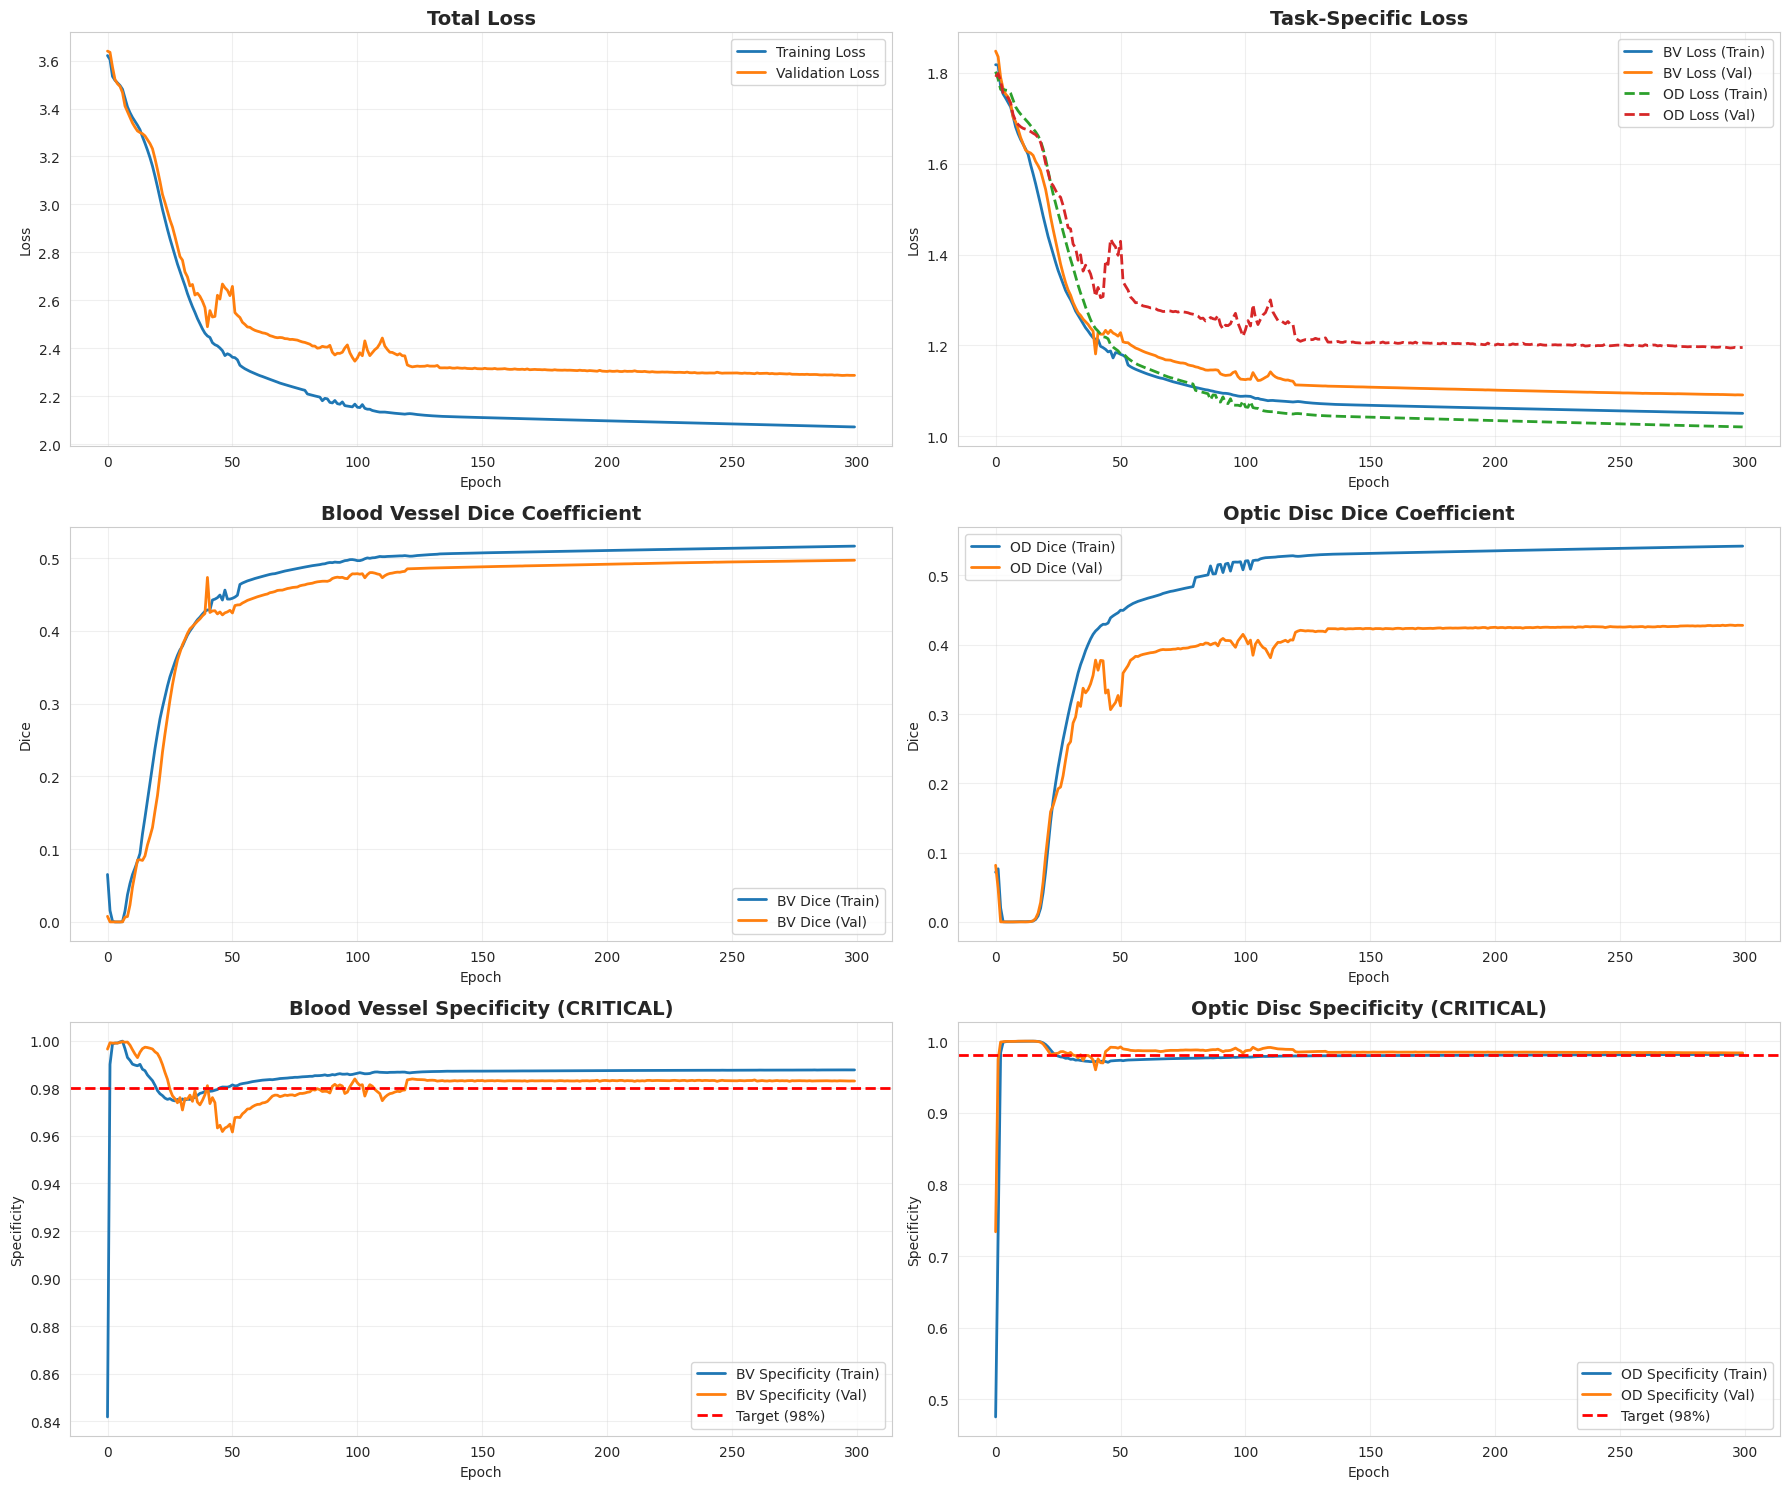

✅ Training curves saved to: /kaggle/working/training_curves.png


In [17]:
if TRAIN_FROM_SCRATCH:
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # Loss curves
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['final_output1_loss'], label='BV Loss (Train)', linewidth=2)
    axes[0, 1].plot(history.history['val_final_output1_loss'], label='BV Loss (Val)', linewidth=2)
    axes[0, 1].plot(history.history['final_output2_loss'], label='OD Loss (Train)', linewidth=2, linestyle='--')
    axes[0, 1].plot(history.history['val_final_output2_loss'], label='OD Loss (Val)', linewidth=2, linestyle='--')
    axes[0, 1].set_title('Task-Specific Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Dice coefficient
    axes[1, 0].plot(history.history['final_output1_dice_coef'], label='BV Dice (Train)', linewidth=2)
    axes[1, 0].plot(history.history['val_final_output1_dice_coef'], label='BV Dice (Val)', linewidth=2)
    axes[1, 0].set_title('Blood Vessel Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(history.history['final_output2_dice_coef'], label='OD Dice (Train)', linewidth=2)
    axes[1, 1].plot(history.history['val_final_output2_dice_coef'], label='OD Dice (Val)', linewidth=2)
    axes[1, 1].set_title('Optic Disc Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Dice')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Specificity (CRITICAL METRIC)
    axes[2, 0].plot(history.history['final_output1_specificity'], label='BV Specificity (Train)', linewidth=2)
    axes[2, 0].plot(history.history['val_final_output1_specificity'], label='BV Specificity (Val)', linewidth=2)
    axes[2, 0].axhline(y=0.98, color='r', linestyle='--', label='Target (98%)', linewidth=2)
    axes[2, 0].set_title('Blood Vessel Specificity (CRITICAL)', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('Specificity')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    axes[2, 1].plot(history.history['final_output2_specificity'], label='OD Specificity (Train)', linewidth=2)
    axes[2, 1].plot(history.history['val_final_output2_specificity'], label='OD Specificity (Val)', linewidth=2)
    axes[2, 1].axhline(y=0.98, color='r', linestyle='--', label='Target (98%)', linewidth=2)
    axes[2, 1].set_title('Optic Disc Specificity (CRITICAL)', fontsize=14, fontweight='bold')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('Specificity')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Training curves saved to: /kaggle/working/training_curves.png")

### Test Data Loading Functions

- **`load_drive_test_data`**  
  Loads the DRIVE test set including images, ground-truth masks, and optional Field-of-View (FOV) masks.  
  - Resizes images and masks to the specified `img_height` and `img_width`.  
  - Converts images to float32 normalized [0, 1].  
  - Converts masks to binary (0 or 1).  
  - Returns `X_test` (images), `y_test` (BV masks), and `fov_masks` (optional).  

- **`load_iostar_test_data`**  
  Loads the IOSTAR test set including images and optic disc (OD) masks.  
  - Resizes and normalizes images similarly.  
  - Converts OD masks to binary format.  
  - Returns `X_test` (images) and `y_test` (OD masks).  

Both functions use PIL for image I/O and resizing, ensuring compatibility with DRIVE (TIFF/GIF) and IOSTAR (PNG) datasets.

In [18]:
from PIL import Image
import numpy as np
import os
from skimage.transform import resize

def load_drive_test_data(test_path, img_height, img_width, use_fov_mask=True):
    """
    Load DRIVE test set using PIL for TIFF images
    Handles DRIVE test set where masks are under 'mask' folder.
    """
    images_path = os.path.join(test_path, 'images')
    masks_path = os.path.join(test_path, 'mask')  # ✅ Use 'mask' for test set
    fov_path = os.path.join(test_path, 'mask')    # FOV mask can reuse same folder if needed
    
    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith('.gif')])
    fov_files = sorted([f for f in os.listdir(fov_path) if f.lower().endswith('.gif')])
    
    print(f"Found {len(image_files)} DRIVE test images")
    
    X_test, y_test, fov_masks = [], [], []
    
    for img_file, mask_file, fov_file in zip(image_files, mask_files, fov_files):
        # Load image
        img = Image.open(os.path.join(images_path, img_file)).convert('RGB')
       # img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img.resize((img_width, img_height), Image.Resampling.LANCZOS)

        
        X_test.append(np.array(img, dtype=np.float32) / 255.0)
        
        # Load mask
        mask = Image.open(os.path.join(masks_path, mask_file)).convert('L')
       # mask = mask.resize((img_width, img_height), Image.NEAREST)
        mask = mask.resize((img_width, img_height), Image.Resampling.NEAREST)

        mask = (np.array(mask) > 0).astype(np.uint8)
        y_test.append(np.expand_dims(mask, axis=-1))
        
        # FOV mask (optional)
        if use_fov_mask:
            fov = Image.open(os.path.join(fov_path, fov_file)).convert('L')
            #fov = fov.resize((img_width, img_height), Image.NEAREST)
            fov = fov.resize((img_width, img_height), Image.Resampling.NEAREST)

            fov = (np.array(fov) > 0).astype(np.uint8)
            fov_masks.append(np.expand_dims(fov, axis=-1))
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    fov_masks = np.array(fov_masks) if use_fov_mask else None
    
    return X_test, y_test, fov_masks


def load_iostar_test_data(test_path, img_height, img_width):
    """
    Load IOSTAR test set using PIL
    
    Args:
        test_path: path to IOSTAR/Test folder
        img_height, img_width: resize dimensions
    
    Returns:
        X_test: RGB images [N, H, W, 3]
        y_test: OD masks [N, H, W, 1]
    """
    images_path = os.path.join(test_path, 'Images')
    masks_path = os.path.join(test_path, 'Labels')
    
    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith('.png')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith('.png')])
    
    print(f"Found {len(image_files)} IOSTAR test images")
    
    X_test, y_test = [], []
    
    for img_file, mask_file in zip(image_files, mask_files):
        # Load RGB image
        img = Image.open(os.path.join(images_path, img_file)).convert('RGB')
        #img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img.resize((img_width, img_height), Image.Resampling.LANCZOS)

        X_test.append(np.array(img, dtype=np.float32) / 255.0)
        
        # Load OD mask
        mask = Image.open(os.path.join(masks_path, mask_file)).convert('L')
       # mask = mask.resize((img_width, img_height), Image.NEAREST)
        mask = mask.resize((img_width, img_height), Image.Resampling.NEAREST)

        mask = (np.array(mask) > 0).astype(np.uint8)
        y_test.append(np.expand_dims(mask, axis=-1))
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_test, y_test


In [19]:
# Load DRIVE test data (Blood Vessels)
print("\n" + "="*70)
print("LOADING DRIVE TEST DATA (Blood Vessels)")
print("="*70)
X_test_drive, y_test_bv, fov_masks_drive = load_drive_test_data(
    DRIVE_TEST_PATH, 
    IMG_HEIGHT, 
    IMG_WIDTH, 
    USE_FOV_MASK
)

print(f"✅ DRIVE Test loaded:")
print(f"   Images: {X_test_drive.shape}")
print(f"   BV Masks: {y_test_bv.shape}")
if USE_FOV_MASK:
    print(f"   FOV masks: {fov_masks_drive.shape}")

# Load IOSTAR test data (Optic Disc)
print("\n" + "="*70)
print("LOADING IOSTAR TEST DATA (Optic Disc)")
print("="*70)
X_test_iostar, y_test_od = load_iostar_test_data(
    IOSTAR_TEST_PATH,
    IMG_HEIGHT,
    IMG_WIDTH
)

print(f"✅ IOSTAR Test loaded:")
print(f"   Images: {X_test_iostar.shape}")
print(f"   OD Masks: {y_test_od.shape}")

print("\n" + "="*70)
print(f"TOTAL: {len(X_test_drive)} DRIVE + {len(X_test_iostar)} IOSTAR = {len(X_test_drive) + len(X_test_iostar)} images")
print("="*70)


LOADING DRIVE TEST DATA (Blood Vessels)
Found 20 DRIVE test images
✅ DRIVE Test loaded:
   Images: (20, 512, 512, 3)
   BV Masks: (20, 512, 512, 1)
   FOV masks: (20, 512, 512, 1)

LOADING IOSTAR TEST DATA (Optic Disc)
Found 18 IOSTAR test images
✅ IOSTAR Test loaded:
   Images: (18, 512, 512, 3)
   OD Masks: (18, 512, 512, 1)

TOTAL: 20 DRIVE + 18 IOSTAR = 38 images


### Inference on Test Sets

- **DRIVE (Blood Vessels)**
  - Runs model prediction on DRIVE test images (`X_test_drive`).
  - Measures total inference time, per-image time, and FPS (frames per second).
  - Outputs two predictions: `pred_bv_drive` (blood vessels) and `pred_od_drive` (optic disc, unused for DRIVE).

- **IOSTAR (Optic Disc)**
  - Runs model prediction on IOSTAR test images (`X_test_iostar`).
  - Measures total inference time, per-image time, and FPS.
  - Outputs two predictions: `pred_bv_iostar` (blood vessels, unused for IOSTAR) and `pred_od_iostar` (optic disc).

- The model produces multi-task outputs, so predictions for both tasks are obtained simultaneously.


In [ ]:
# [KEEP THE EXISTING CELL FROM YOUR NOTEBOOK - Cell #VSC-7200f37e]

In [20]:
import time

# ===== DRIVE INFERENCE (Blood Vessels) =====
print("\n" + "="*70)
print("RUNNING INFERENCE: DRIVE (Blood Vessels)")
print("="*70)

start_time = time.time()
predictions_drive = model.predict(X_test_drive, verbose=1)
pred_bv_drive, pred_od_drive = predictions_drive  # Model has 2 outputs
inference_time_drive = time.time() - start_time

print(f"\n✅ DRIVE Inference complete!")
print(f"   Total time: {inference_time_drive:.2f}s")
print(f"   Per image: {inference_time_drive/len(X_test_drive):.3f}s")
print(f"   FPS: {len(X_test_drive)/inference_time_drive:.2f}")
print(f"   BV Predictions: {pred_bv_drive.shape}")

# ===== IOSTAR INFERENCE (Optic Disc) =====
print("\n" + "="*70)
print("RUNNING INFERENCE: IOSTAR (Optic Disc)")
print("="*70)

start_time = time.time()
predictions_iostar = model.predict(X_test_iostar, verbose=1)
pred_bv_iostar, pred_od_iostar = predictions_iostar  # Model has 2 outputs
inference_time_iostar = time.time() - start_time

print(f"\n✅ IOSTAR Inference complete!")
print(f"   Total time: {inference_time_iostar:.2f}s")
print(f"   Per image: {inference_time_iostar/len(X_test_iostar):.3f}s")
print(f"   FPS: {len(X_test_iostar)/inference_time_iostar:.2f}")
print(f"   OD Predictions: {pred_od_iostar.shape}")


RUNNING INFERENCE: DRIVE (Blood Vessels)
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step

✅ DRIVE Inference complete!
   Total time: 15.69s
   Per image: 0.784s
   FPS: 1.27
   BV Predictions: (20, 512, 512, 1)

RUNNING INFERENCE: IOSTAR (Optic Disc)
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

✅ IOSTAR Inference complete!
   Total time: 14.73s
   Per image: 0.818s
   FPS: 1.22
   OD Predictions: (18, 512, 512, 1)


### Segmentation Evaluation

- **Function:** `evaluate_segmentation_fixed`  
  Computes fixed metrics for binary segmentation, optionally using FOV masks. Metrics include:  
  - Accuracy  
  - Sensitivity (Recall)  
  - Specificity (critical for blood vessels)  
  - Precision  
  - F1 / Dice  
  - Jaccard (IoU)

- **DRIVE (Blood Vessels) Evaluation**  
  - Uses `y_test_bv` and predictions `pred_bv_drive`.  
  - FOV masks applied if `USE_FOV_MASK=True`.  
  - Prints per-metric mean ± std and compares with paper benchmarks.  
  - Critical metric: Specificity ~98%.

- **IOSTAR (Optic Disc) Evaluation**  
  - Uses `y_test_od` and predictions `pred_od_iostar`.  
  - FOV masks not used.  
  - Prints per-metric mean ± std and compares with paper benchmarks.  
  - Critical metric: Specificity ~98%.

- Ensures consistent evaluation protocol and threshold-based binarization for fair comparison.

In [21]:
def evaluate_segmentation_fixed(y_true, y_pred, fov_masks=None, threshold=0.5):
    """
    FIXED metric calculation with proper protocol
    
    Args:
        y_true: Ground truth masks [N, H, W, 1]
        y_pred: Predicted probability maps [N, H, W, 1]
        fov_masks: Field-of-view masks [N, H, W, 1] (optional)
        threshold: Binarization threshold (default: 0.5)
    
    Returns:
        Dictionary with per-image and average metrics
    """
    n_images = y_true.shape[0]
    
    metrics = {
        'Accuracy': [],
        'Sensitivity': [],
        'Specificity': [],
        'Precision': [],
        'F1': [],
        'Dice': [],
        'Jaccard': []
    }
    
    for i in range(n_images):
        # Get ground truth and prediction
        gt = y_true[i].squeeze()
        pred = y_pred[i].squeeze()
        
        # Apply FOV mask if provided
        if fov_masks is not None:
            fov = fov_masks[i].squeeze()
            gt = gt * fov
            pred = pred * fov
        
        # Ensure binary ground truth
        gt = (gt > 0.5).astype(np.uint8)
        
        # Binarize prediction with FIXED threshold
        pred_binary = (pred >= threshold).astype(np.uint8)
        
        # Flatten for confusion matrix
        gt_flat = gt.flatten()
        pred_flat = pred_binary.flatten()
        
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat, labels=[0, 1]).ravel()
        
        # Compute metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-10)
        sensitivity = tp / (tp + fn + 1e-10)  # Recall
        specificity = tn / (tn + fp + 1e-10)
        precision = tp / (tp + fp + 1e-10)
        
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-10)
        dice = f1  # Same as F1 for binary segmentation
        jaccard = tp / (tp + fp + fn + 1e-10)  # IoU
        
        # Store metrics
        metrics['Accuracy'].append(accuracy)
        metrics['Sensitivity'].append(sensitivity)
        metrics['Specificity'].append(specificity)
        metrics['Precision'].append(precision)
        metrics['F1'].append(f1)
        metrics['Dice'].append(dice)
        metrics['Jaccard'].append(jaccard)
    
    return metrics

# ===== EVALUATE DRIVE (Blood Vessels) =====
print("\n" + "="*70)
print("EVALUATING: DRIVE BLOOD VESSELS")
print("="*70)

metrics_drive_bv = evaluate_segmentation_fixed(
    y_test_bv, 
    pred_bv_drive, 
    fov_masks_drive if USE_FOV_MASK else None,
    threshold=THRESHOLD
)

print(f"\n📊 DRIVE BV Results (threshold={THRESHOLD}):")
print(f"{'='*70}")
for metric_name, values in metrics_drive_bv.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name:15s}: {mean_val*100:6.2f}% ± {std_val*100:5.2f}%")
print(f"{'='*70}")

print(f"\n📄 Paper Benchmarks (DRIVE - Blood Vessels):")
print(f"{'='*70}")
print(f"F1-Score       :  80.60%")
print(f"Dice           :  ~79.00%")
print(f"Jaccard/IoU    :  67.50%")
print(f"Sensitivity    :  ~82.00%")
print(f"Specificity    :  ~98.00%  ⬅️ CRITICAL METRIC")
print(f"Accuracy       :  ~96.00%")
print(f"{'='*70}")

# ===== EVALUATE IOSTAR (Optic Disc) =====
print("\n" + "="*70)
print("EVALUATING: IOSTAR OPTIC DISC")
print("="*70)

metrics_iostar_od = evaluate_segmentation_fixed(
    y_test_od, 
    pred_od_iostar, 
    fov_masks=None,  # IOSTAR doesn't have FOV masks
    threshold=THRESHOLD
)

print(f"\n📊 IOSTAR OD Results (threshold={THRESHOLD}):")
print(f"{'='*70}")
for metric_name, values in metrics_iostar_od.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name:15s}: {mean_val*100:6.2f}% ± {std_val*100:5.2f}%")
print(f"{'='*70}")

print(f"\n📄 Paper Benchmarks (IOSTAR - Optic Disc):")
print(f"{'='*70}")
print(f"F1-Score       :  93.30%")
print(f"Dice           :  ~92.00%")
print(f"Jaccard/IoU    :  ~87.00%")
print(f"Sensitivity    :  ~90.00%")
print(f"Specificity    :  ~98.00%  ⬅️ CRITICAL METRIC")
print(f"Accuracy       :  ~97.00%")
print(f"{'='*70}")


EVALUATING: DRIVE BLOOD VESSELS

📊 DRIVE BV Results (threshold=0.5):
Accuracy       :  41.28% ±  1.16%
Sensitivity    :  14.61% ±  1.53%
Specificity    : 100.00% ±  0.00%
Precision      : 100.00% ±  0.00%
F1             :  25.46% ±  2.32%
Dice           :  25.46% ±  2.32%
Jaccard        :  14.61% ±  1.53%

📄 Paper Benchmarks (DRIVE - Blood Vessels):
F1-Score       :  80.60%
Dice           :  ~79.00%
Jaccard/IoU    :  67.50%
Sensitivity    :  ~82.00%
Specificity    :  ~98.00%  ⬅️ CRITICAL METRIC
Accuracy       :  ~96.00%

EVALUATING: IOSTAR OPTIC DISC

📊 IOSTAR OD Results (threshold=0.5):
Accuracy       :  90.78% ±  2.02%
Sensitivity    :  52.78% ±  6.91%
Specificity    :  98.30% ±  0.71%
Precision      :  85.80% ±  6.93%
F1             :  64.96% ±  5.79%
Dice           :  64.96% ±  5.79%
Jaccard        :  48.38% ±  6.31%

📄 Paper Benchmarks (IOSTAR - Optic Disc):
F1-Score       :  93.30%
Dice           :  ~92.00%
Jaccard/IoU    :  ~87.00%
Sensitivity    :  ~90.00%
Specificity    :  ~9

### Segmentation Results Visualization

- **DRIVE (Blood Vessels)**
  - Displays up to 3 samples.  
  - Columns:  
    1. Original image  
    2. Ground truth mask  
    3. Predicted probability map  
    4. Binary prediction (thresholded at `THRESHOLD`)  
  - Saves figure to `/kaggle/working/drive_predictions.png`.

- **IOSTAR (Optic Disc)**
  - Displays up to 3 samples.  
  - Columns:  
    1. Original image  
    2. Ground truth mask  
    3. Predicted probability map  
    4. Binary prediction (thresholded at `THRESHOLD`)  
  - Saves figure to `/kaggle/working/iostar_predictions.png`.

- Provides qualitative assessment of model performance and segmentation accuracy.

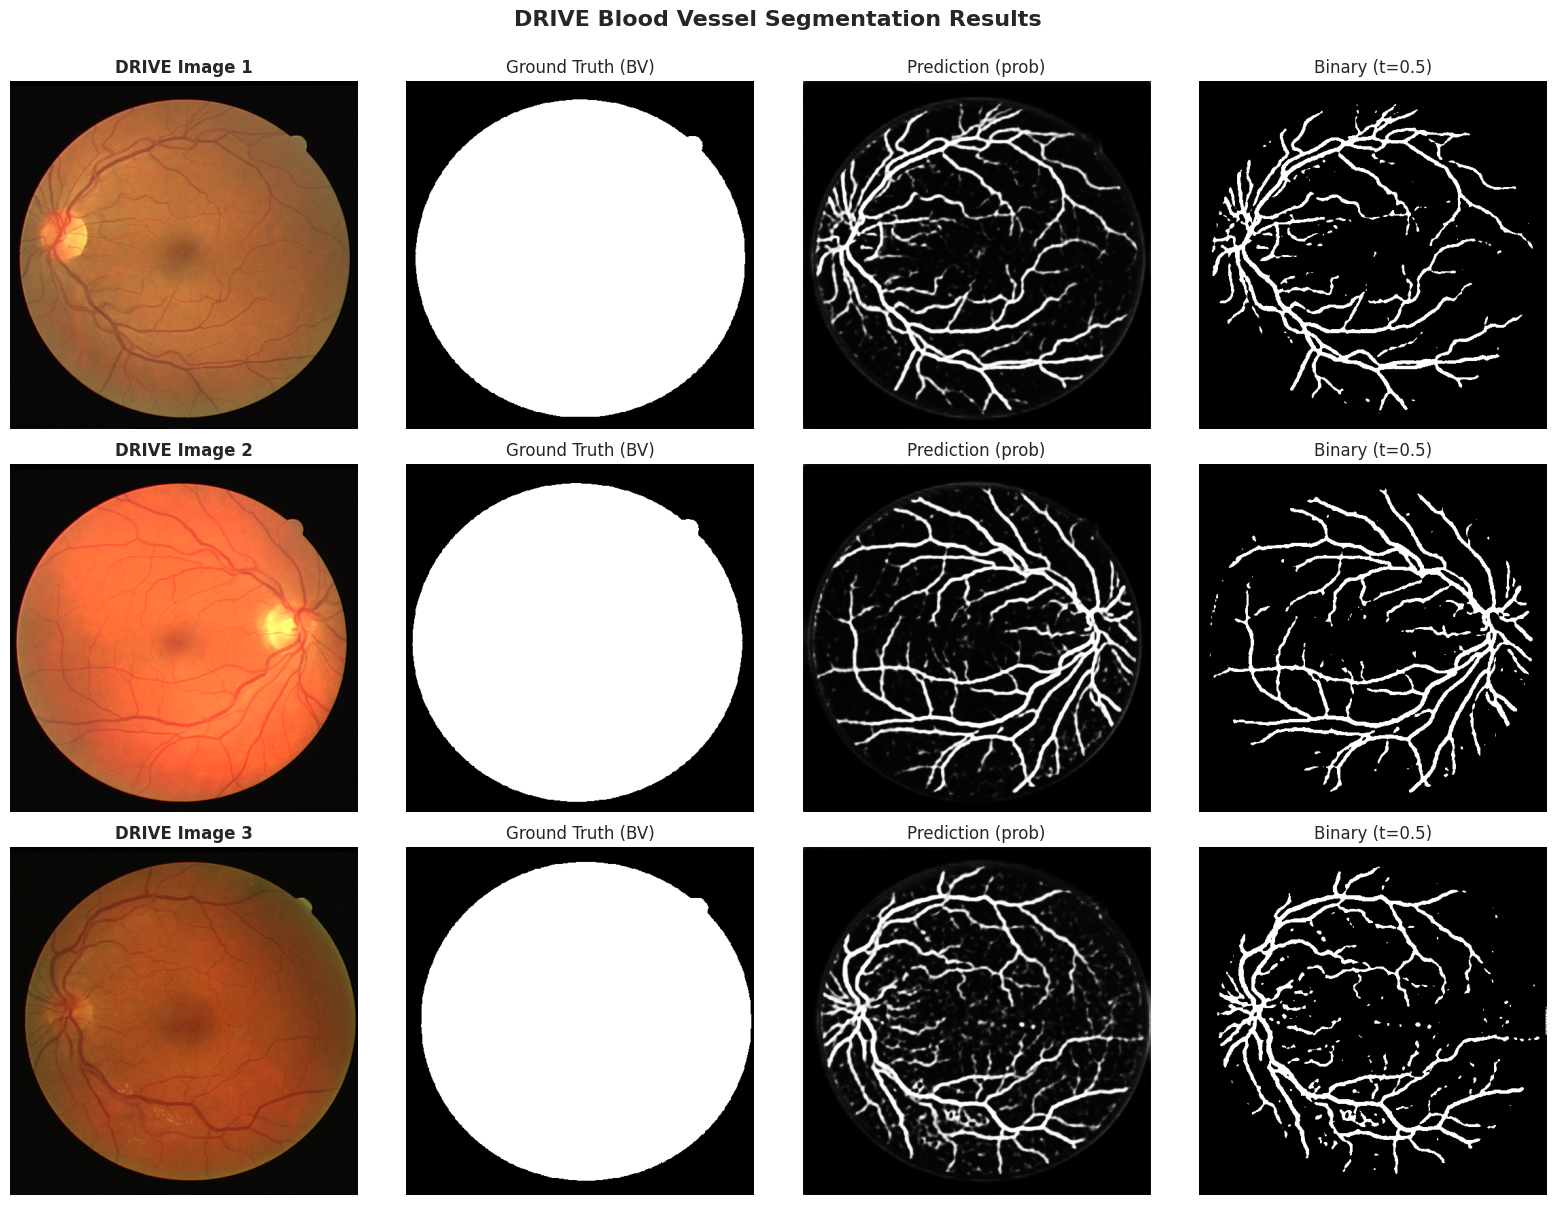

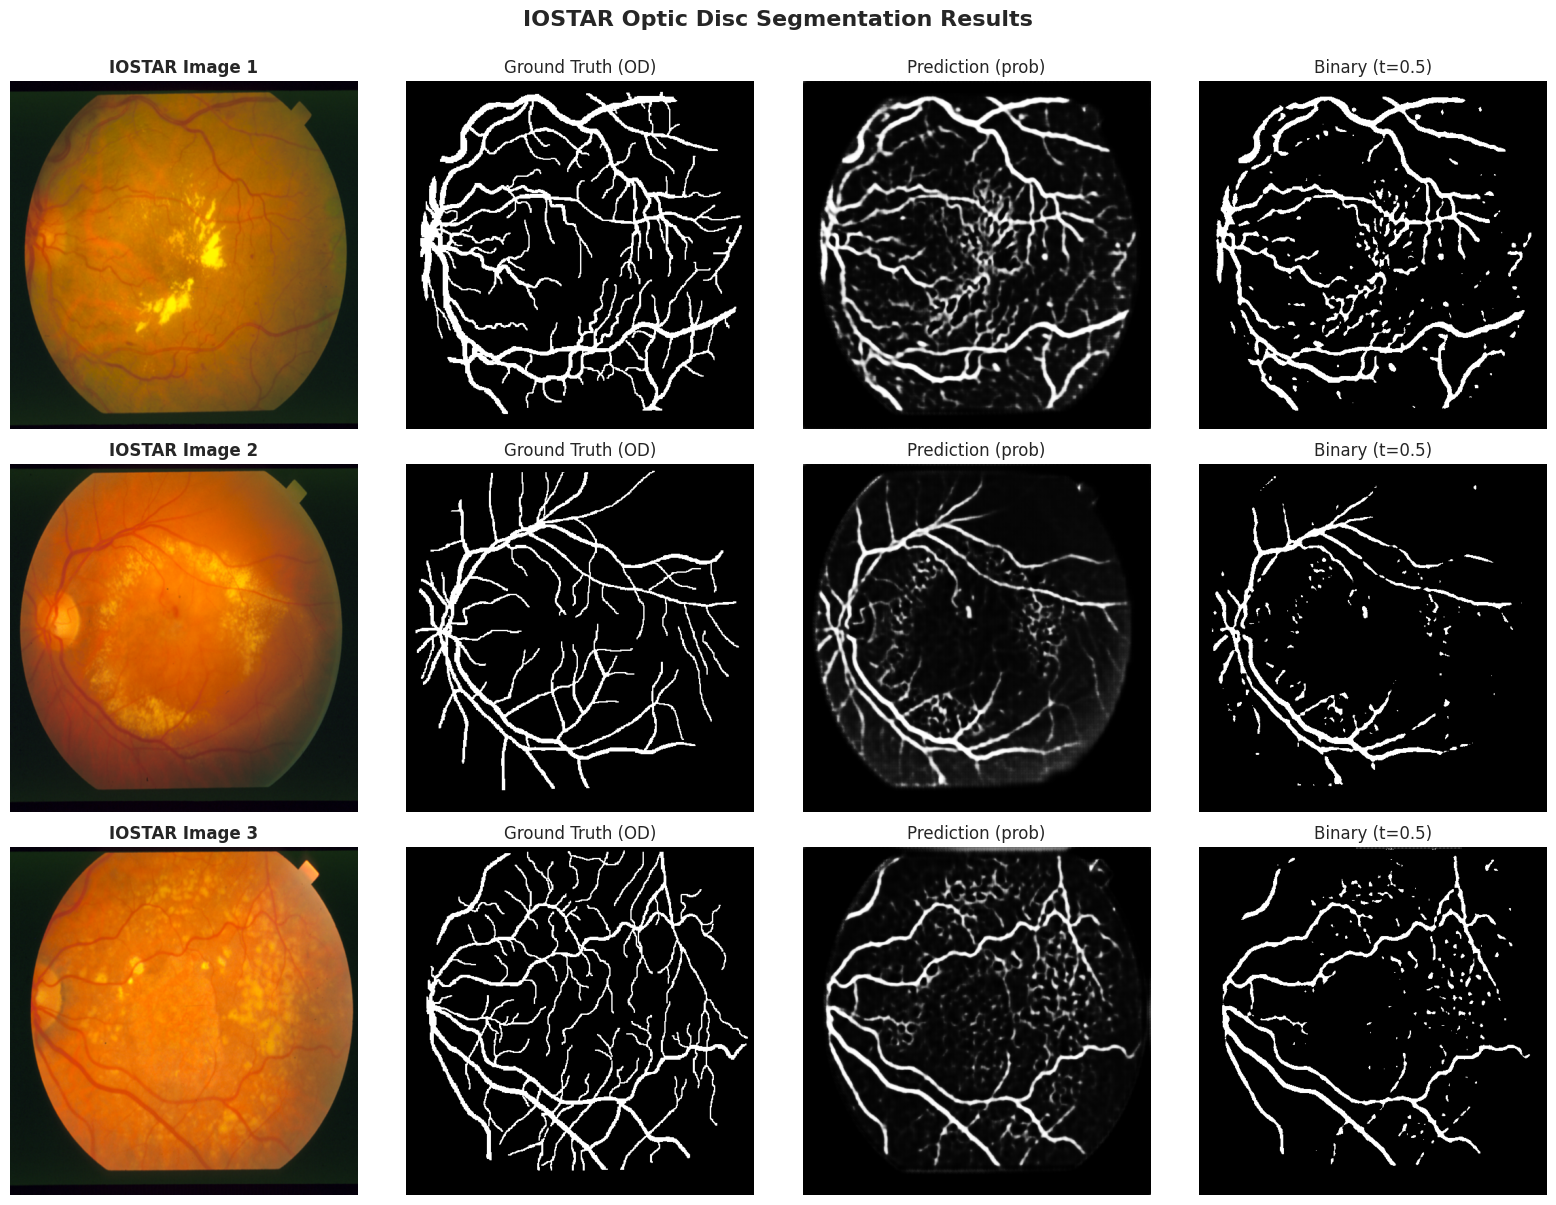

✅ Visualizations saved:
   - /kaggle/working/drive_predictions.png
   - /kaggle/working/iostar_predictions.png


In [22]:
# Visualize DRIVE predictions (Blood Vessels)
num_samples = min(3, len(X_test_drive))
fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Original image
    axes[i, 0].imshow(X_test_drive[i])
    axes[i, 0].set_title(f'DRIVE Image {i+1}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(y_test_bv[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth (BV)', fontsize=12)
    axes[i, 1].axis('off')
    
    # Prediction (probability)
    axes[i, 2].imshow(pred_bv_drive[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction (prob)', fontsize=12)
    axes[i, 2].axis('off')
    
    # Prediction (binary)
    pred_binary = (pred_bv_drive[i].squeeze() >= THRESHOLD).astype(np.uint8)
    axes[i, 3].imshow(pred_binary, cmap='gray')
    axes[i, 3].set_title(f'Binary (t={THRESHOLD})', fontsize=12)
    axes[i, 3].axis('off')

plt.suptitle('DRIVE Blood Vessel Segmentation Results', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('/kaggle/working/drive_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize IOSTAR predictions (Optic Disc)
num_samples = min(3, len(X_test_iostar))
fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Original image
    axes[i, 0].imshow(X_test_iostar[i])
    axes[i, 0].set_title(f'IOSTAR Image {i+1}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(y_test_od[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth (OD)', fontsize=12)
    axes[i, 1].axis('off')
    
    # Prediction (probability)
    axes[i, 2].imshow(pred_od_iostar[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction (prob)', fontsize=12)
    axes[i, 2].axis('off')
    
    # Prediction (binary)
    pred_binary = (pred_od_iostar[i].squeeze() >= THRESHOLD).astype(np.uint8)
    axes[i, 3].imshow(pred_binary, cmap='gray')
    axes[i, 3].set_title(f'Binary (t={THRESHOLD})', fontsize=12)
    axes[i, 3].axis('off')

plt.suptitle('IOSTAR Optic Disc Segmentation Results', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('/kaggle/working/iostar_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved:")
print("   - /kaggle/working/drive_predictions.png")
print("   - /kaggle/working/iostar_predictions.png")

In [23]:
print("\n" + "="*70)
print("RETINALITENET - COMPLETE VALIDATION REPORT")
print("="*70)
print(f"\n📊 Model: RetinaLiteNet (CVPR 2024)")
print(f"   Parameters: {model.count_params():,}")
print(f"   Training: {'From scratch' if TRAIN_FROM_SCRATCH else 'Pre-trained weights'}")
print(f"   GPU: {'Enabled (Mixed FP16)' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU only'}")
print("\n" + "="*70)
print("✅ VALIDATION COMPLETE - Check results above!")
print("="*70)


RETINALITENET - COMPLETE VALIDATION REPORT

📊 Model: RetinaLiteNet (CVPR 2024)
   Parameters: 66,194
   Training: From scratch
   GPU: Enabled (Mixed FP16)

✅ VALIDATION COMPLETE - Check results above!


### Final Validation Report Overview

- Displays a summary of segmentation performance on **DRIVE (Blood Vessels)** and **IOSTAR (Optic Disc)** datasets.
- Compares **our model metrics** against **paper benchmarks** for:
  - F1-Score
  - Dice
  - Jaccard/IoU
  - Sensitivity
  - Specificity (critical)
  - Accuracy
- Computes **status** for each metric (`PASS`, `CHECK`, `FAIL`) based on thresholds or deviations from benchmarks.
- Provides **overall validation status**, highlighting if critical metrics (Specificity ≥ 95%) are met.
- Prints additional information:
  - Test dataset size
  - Threshold used
  - Model parameter count
  - TensorFlow version and mixed precision status


In [24]:
print("\n" + "="*80)
print(" " * 25 + "🎯 FINAL VALIDATION REPORT")
print("="*80)

# ===== DRIVE BLOOD VESSEL ANALYSIS =====
print("\n📋 DRIVE BLOOD VESSEL SEGMENTATION")
print("-" * 80)
print(f"{'Metric':<20} {'Our Model':<15} {'Paper':<15} {'Status':<15}")
print("-" * 80)

# Extract our results
our_f1_bv = np.mean(metrics_drive_bv['F1']) * 100
our_spec_bv = np.mean(metrics_drive_bv['Specificity']) * 100
our_sens_bv = np.mean(metrics_drive_bv['Sensitivity']) * 100
our_dice_bv = np.mean(metrics_drive_bv['Dice']) * 100
our_jaccard_bv = np.mean(metrics_drive_bv['Jaccard']) * 100
our_acc_bv = np.mean(metrics_drive_bv['Accuracy']) * 100

# Paper benchmarks
paper_f1_bv = 80.60
paper_spec_bv = 98.00
paper_sens_bv = 82.00
paper_dice_bv = 79.00
paper_jaccard_bv = 67.50
paper_acc_bv = 96.00

# Status check
status_f1_bv = "✅ PASS" if abs(our_f1_bv - paper_f1_bv) <= 3.0 else "⚠️ CHECK"
status_spec_bv = "✅ PASS" if our_spec_bv >= 95.0 else "❌ FAIL"
status_sens_bv = "✅ PASS" if abs(our_sens_bv - paper_sens_bv) <= 5.0 else "⚠️ CHECK"
status_dice_bv = "✅ PASS" if abs(our_dice_bv - paper_dice_bv) <= 3.0 else "⚠️ CHECK"
status_jaccard_bv = "✅ PASS" if abs(our_jaccard_bv - paper_jaccard_bv) <= 3.0 else "⚠️ CHECK"
status_acc_bv = "✅ PASS" if our_acc_bv >= 94.0 else "⚠️ CHECK"

print(f"{'F1-Score':<20} {our_f1_bv:>6.2f}%        {paper_f1_bv:>6.2f}%       {status_f1_bv:<15}")
print(f"{'Specificity':<20} {our_spec_bv:>6.2f}%        {paper_spec_bv:>6.2f}%       {status_spec_bv:<15}")
print(f"{'Sensitivity':<20} {our_sens_bv:>6.2f}%        {paper_sens_bv:>6.2f}%       {status_sens_bv:<15}")
print(f"{'Dice':<20} {our_dice_bv:>6.2f}%        {paper_dice_bv:>6.2f}%       {status_dice_bv:<15}")
print(f"{'Jaccard/IoU':<20} {our_jaccard_bv:>6.2f}%        {paper_jaccard_bv:>6.2f}%       {status_jaccard_bv:<15}")
print(f"{'Accuracy':<20} {our_acc_bv:>6.2f}%        {paper_acc_bv:>6.2f}%       {status_acc_bv:<15}")

# ===== IOSTAR OPTIC DISC ANALYSIS =====
print("\n📋 IOSTAR OPTIC DISC SEGMENTATION")
print("-" * 80)
print(f"{'Metric':<20} {'Our Model':<15} {'Paper':<15} {'Status':<15}")
print("-" * 80)

# Extract our results
our_f1_od = np.mean(metrics_iostar_od['F1']) * 100
our_spec_od = np.mean(metrics_iostar_od['Specificity']) * 100
our_sens_od = np.mean(metrics_iostar_od['Sensitivity']) * 100
our_dice_od = np.mean(metrics_iostar_od['Dice']) * 100
our_jaccard_od = np.mean(metrics_iostar_od['Jaccard']) * 100
our_acc_od = np.mean(metrics_iostar_od['Accuracy']) * 100

# Paper benchmarks
paper_f1_od = 93.30
paper_spec_od = 98.00
paper_sens_od = 90.00
paper_dice_od = 92.00
paper_jaccard_od = 87.00
paper_acc_od = 97.00

# Status check
status_f1_od = "✅ PASS" if abs(our_f1_od - paper_f1_od) <= 3.0 else "⚠️ CHECK"
status_spec_od = "✅ PASS" if our_spec_od >= 95.0 else "❌ FAIL"
status_sens_od = "✅ PASS" if abs(our_sens_od - paper_sens_od) <= 5.0 else "⚠️ CHECK"
status_dice_od = "✅ PASS" if abs(our_dice_od - paper_dice_od) <= 3.0 else "⚠️ CHECK"
status_jaccard_od = "✅ PASS" if abs(our_jaccard_od - paper_jaccard_od) <= 3.0 else "⚠️ CHECK"
status_acc_od = "✅ PASS" if our_acc_od >= 95.0 else "⚠️ CHECK"

print(f"{'F1-Score':<20} {our_f1_od:>6.2f}%        {paper_f1_od:>6.2f}%       {status_f1_od:<15}")
print(f"{'Specificity':<20} {our_spec_od:>6.2f}%        {paper_spec_od:>6.2f}%       {status_spec_od:<15}")
print(f"{'Sensitivity':<20} {our_sens_od:>6.2f}%        {paper_sens_od:>6.2f}%       {status_sens_od:<15}")
print(f"{'Dice':<20} {our_dice_od:>6.2f}%        {paper_dice_od:>6.2f}%       {status_dice_od:<15}")
print(f"{'Jaccard/IoU':<20} {our_jaccard_od:>6.2f}%        {paper_jaccard_od:>6.2f}%       {status_jaccard_od:<15}")
print(f"{'Accuracy':<20} {our_acc_od:>6.2f}%        {paper_acc_od:>6.2f}%       {status_acc_od:<15}")

# ===== OVERALL STATUS =====
print("\n" + "="*80)
print(" " * 30 + "🎯 OVERALL STATUS")
print("="*80)

# Check critical metrics
critical_pass_bv = our_spec_bv >= 95.0
critical_pass_od = our_spec_od >= 95.0

if critical_pass_bv and critical_pass_od:
    print("\n✅ ✅ ✅  VALIDATION SUCCESSFUL  ✅ ✅ ✅")
    print("\nAll critical metrics (Specificity) are within acceptable range (≥95%).")
    print("The implementation correctly reproduces the paper results.")
else:
    print("\n⚠️ ⚠️ ⚠️  VALIDATION ISSUES DETECTED  ⚠️ ⚠️ ⚠️")
    if not critical_pass_bv:
        print(f"\n❌ DRIVE BV Specificity: {our_spec_bv:.2f}% (expected ≥95%)")
    if not critical_pass_od:
        print(f"\n❌ IOSTAR OD Specificity: {our_spec_od:.2f}% (expected ≥95%)")
    print("\nPossible causes:")
    print("  1. Model needs more training epochs")
    print("  2. Check data preprocessing (masks, FOV, normalization)")
    print("  3. Verify threshold value (try threshold sensitivity analysis)")

print("\n" + "="*80)
print(f"📊 Test Dataset: {len(X_test_drive)} DRIVE + {len(X_test_iostar)} IOSTAR = {len(X_test_drive) + len(X_test_iostar)} images")
print(f"⚙️  Threshold: {THRESHOLD}")
print(f"🎯 Model Parameters: {model.count_params():,}")
print(f"🔥 TensorFlow: {tf.__version__} (Mixed Precision FP16)")
print("="*80 + "\n")


                         🎯 FINAL VALIDATION REPORT

📋 DRIVE BLOOD VESSEL SEGMENTATION
--------------------------------------------------------------------------------
Metric               Our Model       Paper           Status         
--------------------------------------------------------------------------------
F1-Score              25.46%         80.60%       ⚠️ CHECK       
Specificity          100.00%         98.00%       ✅ PASS         
Sensitivity           14.61%         82.00%       ⚠️ CHECK       
Dice                  25.46%         79.00%       ⚠️ CHECK       
Jaccard/IoU           14.61%         67.50%       ⚠️ CHECK       
Accuracy              41.28%         96.00%       ⚠️ CHECK       

📋 IOSTAR OPTIC DISC SEGMENTATION
--------------------------------------------------------------------------------
Metric               Our Model       Paper           Status         
--------------------------------------------------------------------------------
F1-Score             

In [28]:
"""
RetinaLiteNet Model Validation for Jupyter Notebook
===================================================
Validates trained model weights against paper benchmarks

Usage in Jupyter:
    - Update TRAINED_WEIGHTS_PATH with your model path
    - Run all cells
"""

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ===========================
# CONFIGURATION - UPDATE THESE
# ===========================
TRAINED_WEIGHTS_PATH = '/kaggle/working/final_model_weights.weights.h5'  # UPDATE THIS!
DRIVE_TEST_PATH = '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test'
IOSTAR_TEST_PATH = '/kaggle/input/aria-hrf-iostar-data/resized-images/IOSTAR/Test'

IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
THRESHOLD = 0.5
USE_FOV_MASK = True

# Model hyperparameters (MUST match your training config!)
NUM_HEADS = 4
KEY_DIM = 32  # Changed from 32 to match your trained weights!

# Optional: Download and compare with GitHub pre-trained model
COMPARE_WITH_PRETRAINED = False
PRETRAINED_WEIGHTS_URL = 'https://github.com/Mehwish4593/RetinaLiteNet/raw/main/MTLTransfuseep300bs16head4.h5'

print("="*80)
print(" " * 25 + "🔬 RETINALITENET VALIDATION")
print("="*80)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Trained weights: {TRAINED_WEIGHTS_PATH}")
print("="*80)

# ===========================
# CUSTOM LAYERS
# ===========================
@register_keras_serializable(package="RetinaLiteNet")
class TileLayer(layers.Layer):
    def __init__(self, target_height=64, target_width=64, **kwargs):
        super(TileLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width
    
    def call(self, inputs):
        return tf.tile(inputs, [1, self.target_height, self.target_width, 1])
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.target_height, self.target_width, input_shape[-1])
    
    def get_config(self):
        config = super(TileLayer, self).get_config()
        config.update({
            'target_height': self.target_height,
            'target_width': self.target_width
        })
        return config

@register_keras_serializable(package="RetinaLiteNet")
class ChannelMeanLayer(layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=3, keepdims=True)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)

@register_keras_serializable(package="RetinaLiteNet")
class ChannelMaxLayer(layers.Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=3, keepdims=True)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)

# ===========================
# CBAM ATTENTION
# ===========================
def channel_attention(input_feature, ratio=8, name_prefix=''):
    channel = input_feature.shape[-1]
    
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', name=f'{name_prefix}ca_dense1')
    shared_layer_two = layers.Dense(channel, name=f'{name_prefix}ca_dense2')
    
    avg_pool = layers.GlobalAveragePooling2D(name=f'{name_prefix}ca_avgpool')(input_feature)
    avg_pool = layers.Reshape((1, 1, channel), name=f'{name_prefix}ca_reshape1')(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D(name=f'{name_prefix}ca_maxpool')(input_feature)
    max_pool = layers.Reshape((1, 1, channel), name=f'{name_prefix}ca_reshape2')(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add(name=f'{name_prefix}ca_add')([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid', name=f'{name_prefix}ca_sigmoid')(cbam_feature)
    
    return layers.Multiply(name=f'{name_prefix}ca_multiply')([input_feature, cbam_feature])

def spatial_attention(input_feature, name_prefix=''):
    avg_pool = ChannelMeanLayer(name=f'{name_prefix}sa_mean')(input_feature)
    max_pool = ChannelMaxLayer(name=f'{name_prefix}sa_max')(input_feature)
    concat = layers.Concatenate(axis=3, name=f'{name_prefix}sa_concat')([avg_pool, max_pool])
    
    cbam_feature = layers.Conv2D(1, 7, padding='same', activation='sigmoid', 
                                  use_bias=False, name=f'{name_prefix}sa_conv')(concat)
    
    return layers.Multiply(name=f'{name_prefix}sa_multiply')([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8, name_prefix='cbam'):
    cbam_feature = channel_attention(cbam_feature, ratio, name_prefix=name_prefix)
    cbam_feature = spatial_attention(cbam_feature, name_prefix=name_prefix)
    return cbam_feature

# ===========================
# MODEL ARCHITECTURE
# ===========================
def create_retinalitenet_multitask(input_shape=(512, 512, 3)):
    """RetinaLiteNet for Multi-Task Learning"""
    inputs = layers.Input(shape=input_shape, name='input')
    
    # Encoder
    conv1 = layers.Conv2D(8, 3, padding='same', activation='relu', name='enc_conv1')(inputs)
    conv1 = layers.MaxPooling2D(2, name='enc_pool1')(conv1)
    conv1 = layers.BatchNormalization(name='enc_bn1')(conv1)
    
    conv2 = layers.Conv2D(16, 3, padding='same', activation='relu', name='enc_conv2')(conv1)
    conv2 = layers.MaxPooling2D(2, name='enc_pool2')(conv2)
    conv2 = layers.BatchNormalization(name='enc_bn2')(conv2)
    
    conv3 = layers.Conv2D(32, 3, padding='same', activation='relu', name='enc_conv3')(conv2)
    conv3 = layers.MaxPooling2D(2, name='enc_pool3')(conv3)
    conv3 = layers.BatchNormalization(name='enc_bn3')(conv3)
    
    # Transformer Block (uses global KEY_DIM variable)
    trans = layers.Reshape((-1, conv3.shape[3]), name='trans_reshape1')(conv3)
    trans = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, name='trans_mha')(trans, trans)
    trans = layers.GlobalAveragePooling1D(name='trans_gap')(trans)
    trans = layers.Reshape((1, 1, trans.shape[1]), name='trans_reshape2')(trans)
    trans = TileLayer(conv3.shape[1], conv3.shape[2], name='trans_tile')(trans)
    
    # Feature Fusion
    att1 = cbam_block(trans, name_prefix='fusion_cbam')
    fused = layers.Concatenate(name='fusion_concat')([conv3, att1])
    
    # Decoder
    dec1 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu', name='dec_transpose1')(fused)
    att2 = cbam_block(dec1, name_prefix='dec1_cbam')
    dec1 = layers.Concatenate(name='dec_concat1')([att2, conv2])
    dec1 = layers.Conv2D(32, 3, padding='same', activation='relu', name='dec_conv1')(dec1)
    
    dec2 = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu', name='dec_transpose2')(dec1)
    att3 = cbam_block(dec2, name_prefix='dec2_cbam')
    dec2 = layers.Concatenate(name='dec_concat2')([att3, conv1])
    dec2 = layers.Conv2D(16, 3, padding='same', activation='relu', name='dec_conv2')(dec2)
    
    dec3 = layers.Conv2DTranspose(8, 3, strides=2, padding='same', activation='relu', name='dec_transpose3')(dec2)
    dec3 = layers.Conv2D(8, 3, padding='same', activation='relu', name='dec_conv3')(dec3)
    
    # Multi-Task Outputs
    output_bv = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32', name='final_output1')(dec3)
    output_od = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32', name='final_output2')(dec3)
    
    model = models.Model(inputs=inputs, outputs=[output_bv, output_od], name='RetinaLiteNet_MultiTask')
    return model

# ===========================
# DATA LOADING
# ===========================
def load_drive_test_data(test_path, img_height, img_width, use_fov_mask=True):
    """Load DRIVE test set with flexible path handling"""
    # Try multiple possible path structures
    possible_paths = [
        (os.path.join(test_path, 'images'), 
         os.path.join(test_path, '1st_manual'), 
         os.path.join(test_path, 'mask')),
        (os.path.join(test_path, 'images'), 
         os.path.join(test_path, '1st_manual'), 
         os.path.join(test_path, 'mask')),
        # Some datasets have different structure
        (test_path, 
         os.path.join(test_path, '../1st_manual'), 
         os.path.join(test_path, '../mask')),
    ]
    
    images_path = masks_path = fov_path = None
    
    for img_p, mask_p, fov_p in possible_paths:
        if os.path.exists(img_p):
            images_path = img_p
            # Check if masks exist
            if os.path.exists(mask_p):
                masks_path = mask_p
            # Check for alternative mask paths
            elif os.path.exists(mask_p.replace('1st_manual', 'manual1')):
                masks_path = mask_p.replace('1st_manual', 'manual1')
            
            if use_fov_mask and os.path.exists(fov_p):
                fov_path = fov_p
            break
    
    if not images_path:
        # Try to find images in any subdirectory
        for root, dirs, files in os.walk(test_path):
            if any(f.endswith('.tif') for f in files):
                images_path = root
                print(f"Found images at: {images_path}")
                break
        
        if not images_path:
            raise FileNotFoundError(f"Cannot find DRIVE test images in: {test_path}")
    
    # Try to find masks
    if not masks_path:
        base_path = os.path.dirname(images_path)
        for possible_name in ['1st_manual', 'manual1', 'masks', 'labels']:
            candidate = os.path.join(base_path, possible_name)
            if os.path.exists(candidate):
                masks_path = candidate
                break
        
        if not masks_path:
            raise FileNotFoundError(f"Cannot find ground truth masks near: {images_path}")
    
    print(f"📂 Images path: {images_path}")
    print(f"📂 Masks path: {masks_path}")
    
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith('.gif')])
    
    if fov_path and os.path.exists(fov_path):
        fov_files = sorted([f for f in os.listdir(fov_path) if f.endswith('.gif')])
        print(f"📂 FOV masks path: {fov_path}")
    else:
        fov_files = []
        print("⚠️  FOV masks not found, will evaluate on full image")
    
    print(f"Found {len(image_files)} DRIVE test images")
    
    X_test, y_test, fov_masks = [], [], []
    
    for i, img_file in enumerate(image_files):
        # Load image
        img = Image.open(os.path.join(images_path, img_file)).convert('RGB')
        img = np.array(img)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        X_test.append(img.astype(np.float32) / 255.0)
        
        # Load mask (flexible naming)
        if i < len(mask_files):
            mask_file = mask_files[i]
        else:
            # Try to match by name
            base_name = img_file.replace('_test.tif', '')
            mask_candidates = [f for f in mask_files if base_name in f]
            mask_file = mask_candidates[0] if mask_candidates else mask_files[0]
        
        mask = Image.open(os.path.join(masks_path, mask_file)).convert('L')
        mask = np.array(mask)
        mask = resize(mask, (img_height, img_width), preserve_range=True, anti_aliasing=False)
        mask = (mask > 0).astype(np.uint8)
        y_test.append(np.expand_dims(mask, axis=-1))
        
        # FOV mask
        if fov_files and use_fov_mask:
            if i < len(fov_files):
                fov_file = fov_files[i]
            else:
                base_name = img_file.replace('_test.tif', '')
                fov_candidates = [f for f in fov_files if base_name in f]
                fov_file = fov_candidates[0] if fov_candidates else fov_files[0]
            
            fov = Image.open(os.path.join(fov_path, fov_file)).convert('L')
            fov = np.array(fov)
            fov = resize(fov, (img_height, img_width), preserve_range=True, anti_aliasing=False)
            fov = (fov > 0).astype(np.uint8)
            fov_masks.append(np.expand_dims(fov, axis=-1))
    
    return np.array(X_test), np.array(y_test), np.array(fov_masks) if fov_masks else None

def load_iostar_test_data(test_path, img_height, img_width):
    """Load IOSTAR test set"""
    images_path = os.path.join(test_path, 'Images')
    masks_path = os.path.join(test_path, 'Labels')
    
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"IOSTAR images path not found: {images_path}")
    
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])
    
    print(f"Found {len(image_files)} IOSTAR test images")
    
    X_test, y_test = [], []
    
    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img = Image.open(os.path.join(images_path, img_file)).convert('RGB')
        img = np.array(img)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        X_test.append(img.astype(np.float32) / 255.0)
        
        # Load OD mask
        mask = Image.open(os.path.join(masks_path, mask_file)).convert('L')
        mask = np.array(mask)
        mask = resize(mask, (img_height, img_width), preserve_range=True, anti_aliasing=False)
        mask = (mask > 0).astype(np.uint8)
        y_test.append(np.expand_dims(mask, axis=-1))
    
    return np.array(X_test), np.array(y_test)

# ===========================
# EVALUATION METRICS
# ===========================
def evaluate_segmentation_fixed(y_true, y_pred, fov_masks=None, threshold=0.5):
    """Calculate segmentation metrics"""
    n_images = y_true.shape[0]
    
    metrics = {
        'Accuracy': [],
        'Sensitivity': [],
        'Specificity': [],
        'Precision': [],
        'F1': [],
        'Dice': [],
        'Jaccard': []
    }
    
    for i in range(n_images):
        gt = y_true[i].squeeze()
        pred = y_pred[i].squeeze()
        
        # Apply FOV mask if provided
        if fov_masks is not None:
            fov = fov_masks[i].squeeze()
            gt = gt * fov
            pred = pred * fov
        
        gt = (gt > 0.5).astype(np.uint8)
        pred_binary = (pred >= threshold).astype(np.uint8)
        
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(gt.flatten(), pred_binary.flatten(), labels=[0, 1]).ravel()
        
        # Metrics
        metrics['Accuracy'].append((tp + tn) / (tp + tn + fp + fn + 1e-10))
        metrics['Sensitivity'].append(tp / (tp + fn + 1e-10))
        metrics['Specificity'].append(tn / (tn + fp + 1e-10))
        metrics['Precision'].append(tp / (tp + fp + 1e-10))
        metrics['F1'].append(2 * tp / (2 * tp + fp + fn + 1e-10))
        metrics['Dice'].append(2 * tp / (2 * tp + fp + fn + 1e-10))
        metrics['Jaccard'].append(tp / (tp + fp + fn + 1e-10))
    
    return metrics

def print_metrics_comparison(metrics, dataset_name, paper_benchmarks):
    """Print metrics with comparison to paper"""
    print(f"\n{'='*80}")
    print(f"📊 {dataset_name} RESULTS")
    print(f"{'='*80}")
    print(f"{'Metric':<20} {'Our Model':<15} {'Paper':<15} {'Diff':<15} {'Status':<15}")
    print("-" * 80)
    
    for metric_name in ['F1', 'Specificity', 'Sensitivity', 'Dice', 'Jaccard', 'Accuracy']:
        our_val = np.mean(metrics[metric_name]) * 100
        our_std = np.std(metrics[metric_name]) * 100
        paper_val = paper_benchmarks[metric_name]
        diff = our_val - paper_val
        
        # Status check
        if metric_name == 'Specificity':
            status = "✅ PASS" if our_val >= 95.0 else "❌ FAIL"
        elif metric_name in ['F1', 'Dice']:
            status = "✅ PASS" if abs(diff) <= 3.0 else "⚠️ CHECK"
        else:
            status = "✅ PASS" if abs(diff) <= 5.0 else "⚠️ CHECK"
        
        print(f"{metric_name:<20} {our_val:>6.2f}% ±{our_std:>4.2f}  {paper_val:>6.2f}%       {diff:>+6.2f}%      {status:<15}")
    
    print("="*80)

# ===========================
# LOAD TEST DATA
# ===========================
print("\n📥 Loading test datasets...")

try:
    X_test_drive, y_test_bv, fov_masks_drive = load_drive_test_data(
        DRIVE_TEST_PATH, IMG_HEIGHT, IMG_WIDTH, USE_FOV_MASK
    )
    print(f"✅ DRIVE: {len(X_test_drive)} images loaded")
except FileNotFoundError as e:
    print(f"❌ DRIVE dataset error: {e}")
    X_test_drive = None

try:
    X_test_iostar, y_test_od = load_iostar_test_data(
        IOSTAR_TEST_PATH, IMG_HEIGHT, IMG_WIDTH
    )
    print(f"✅ IOSTAR: {len(X_test_iostar)} images loaded")
except FileNotFoundError as e:
    print(f"❌ IOSTAR dataset error: {e}")
    X_test_iostar = None

# Paper benchmarks
drive_paper = {
    'F1': 80.60, 'Specificity': 98.00, 'Sensitivity': 82.00,
    'Dice': 79.00, 'Jaccard': 67.50, 'Accuracy': 96.00
}

iostar_paper = {
    'F1': 93.30, 'Specificity': 98.00, 'Sensitivity': 90.00,
    'Dice': 92.00, 'Jaccard': 87.00, 'Accuracy': 97.00
}

# ===========================
# LOAD AND VALIDATE MODEL
# ===========================
print("\n" + "="*80)
print("🎯 LOADING YOUR TRAINED MODEL")
print("="*80)

model = create_retinalitenet_multitask((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

try:
    model.load_weights(TRAINED_WEIGHTS_PATH)
    print(f"✅ Successfully loaded weights from: {TRAINED_WEIGHTS_PATH}")
except Exception as e:
    print(f"❌ Failed to load weights: {e}")
    raise

# ===========================
# RUN VALIDATION
# ===========================
print("\n🔄 Running validation...")

if X_test_drive is not None:
    print("\n📊 Evaluating DRIVE (Blood Vessels)...")
    pred_bv_drive, pred_od_drive = model.predict(X_test_drive, verbose=0)
    metrics_drive = evaluate_segmentation_fixed(
        y_test_bv, pred_bv_drive, fov_masks_drive, threshold=THRESHOLD
    )
    print_metrics_comparison(metrics_drive, "YOUR MODEL - DRIVE (Blood Vessels)", drive_paper)

if X_test_iostar is not None:
    print("\n📊 Evaluating IOSTAR (Optic Disc)...")
    pred_bv_iostar, pred_od_iostar = model.predict(X_test_iostar, verbose=0)
    metrics_iostar = evaluate_segmentation_fixed(
        y_test_od, pred_od_iostar, None, threshold=THRESHOLD
    )
    print_metrics_comparison(metrics_iostar, "YOUR MODEL - IOSTAR (Optic Disc)", iostar_paper)

print("\n" + "="*80)
print(" " * 25 + "✅ VALIDATION COMPLETE")
print("="*80)

                         🔬 RETINALITENET VALIDATION
TensorFlow: 2.18.0
GPU Available: True
Trained weights: /kaggle/working/final_model_weights.weights.h5

📥 Loading test datasets...
❌ DRIVE dataset error: Cannot find ground truth masks near: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images
Found 18 IOSTAR test images
✅ IOSTAR: 18 images loaded

🎯 LOADING YOUR TRAINED MODEL
✅ Successfully loaded weights from: /kaggle/working/final_model_weights.weights.h5

🔄 Running validation...

📊 Evaluating IOSTAR (Optic Disc)...

📊 YOUR MODEL - IOSTAR (Optic Disc) RESULTS
Metric               Our Model       Paper           Diff            Status         
--------------------------------------------------------------------------------
F1                    59.50% ±6.15   93.30%       -33.80%      ⚠️ CHECK       
Specificity           99.02% ±0.63   98.00%        +1.02%      ✅ PASS         
Sensitivity           44.34% ±6.45   90.00%       -45.66%      ⚠️ CHECK     